In [196]:
# ============================================================
# ============================================================
# COMPREHENSIVE COX ELASTIC NET MODEL PIPELINE
# Dual Outcome Analysis: HF Hospitalization & All-Cause Mortality
# ============================================================
# ============================================================

# =============================================
# PART 1: IMPORTS AND SETUP
# =============================================
import warnings

warnings.filterwarnings('ignore')

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind, chi2_contingency, fisher_exact, chi2
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines.statistics import proportional_hazard_test, multivariate_logrank_test, pairwise_logrank_test
from lifelines.plotting import add_at_risk_counts

# =============================================
# PLOT SETTINGS
# =============================================
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# Color palette (Nature/Lancet/JACC standard)
COLORS = {
    'blue': '#3C5488',
    'red': '#E64B35',
    'teal': '#00A087',
    'orange': '#F39B7F',
    'green': '#4DBBD5',
    'purple': '#8491B4',
}

print("=" * 90)
print("COMPREHENSIVE COX ELASTIC NET MODEL PIPELINE")
print("Dual Outcome Analysis: HF Hospitalization & All-Cause Mortality")
print("=" * 90)


COMPREHENSIVE COX ELASTIC NET MODEL PIPELINE
Dual Outcome Analysis: HF Hospitalization & All-Cause Mortality


In [197]:
# =============================================
# PART 2: CONFIGURATION & DATA LOADING
# =============================================
print("\n" + "=" * 90)
print("PART 2: CONFIGURATION & DATA LOADING")
print("=" * 90)

# Load data
model_df = pd.read_excel('model_df.xlsx', engine='openpyxl')
print(f"\nLoaded model_df: {model_df.shape[0]} patients, {model_df.shape[1]} variables")

# ─────────────────────────────────────────────
# CONFIGURATION
# ─────────────────────────────────────────────
CUTOFF_DAYS = 3652  # 10 years
RANDOM_STATE = 50

# Define BOTH outcomes
OUTCOMES = {
    'hf': {
        'time_col': 'days_hf_admission_new',
        'event_col': 'hHF_total',
        'label': 'HF Hospitalization',
        'color': COLORS['blue']
    },
    'death': {
        'time_col': 'days_death_new',
        'event_col': 'death',
        'label': 'All-Cause Mortality',
        'color': COLORS['red']
    }
}

# Define predictors
predictors = [
    # Demographics
    'sex', 'age', 'BMI', 'sbp', 'dbp', 'hr',
    # Comorbidities
    'smoker', 'htn', 'dm', 'hyperlipidemia', 'cad', 'stroke', 'baseline_af',
    # Laboratory
    'LDL', 'HDL', 'tg', 'eGFR', 'A1C', 'FBS',
    # LA parameters
    'LAVI', 'la_strain_avg',
    # LV parameters
    'rwt', 'IVSd', 'LVPWd', 'LVIDd', 'LVIDs', 'LVmass_index', 'LVEF', 'LV_volume_index', 'LVstrain_avg',
    # Diastolic function
    'TR_V', 'dt', 'ivrt', 'E', 'A', 'TDI_Ea_mean', 'E_Ea_mean'
]

# Verify columns exist
predictors = [p for p in predictors if p in model_df.columns]
print(f"\nPredictors available: {len(predictors)}")
print(predictors)

# Define categorical and numerical variables
categorical_vars = ['sex', 'smoker', 'htn', 'dm', 'hyperlipidemia', 'cad', 'stroke', 'baseline_af']
categorical_vars = [v for v in categorical_vars if v in predictors]
numerical_vars = [v for v in predictors if v not in categorical_vars]

print(f"\nCategorical variables: {len(categorical_vars)}")
print(f"Numerical variables: {len(numerical_vars)}")

# Variable labels for display
var_labels = {
    'sex': 'Sex', 'age': 'Age', 'BMI': 'BMI', 'sbp': 'SBP', 'dbp': 'DBP', 'hr': 'HR',
    'smoker': 'Smoker', 'htn': 'HTN', 'dm': 'DM', 'hyperlipidemia': 'Dyslipidemia',
    'cad': 'CAD', 'stroke': 'Stroke', 'baseline_af': 'AF',
    'LDL': 'LDL', 'HDL': 'HDL', 'tg': 'TG', 'eGFR': 'eGFR', 'A1C': 'HbA1c', 'FBS': 'FBS',
    'LAVI': 'LAVI', 'la_strain_avg': 'LA Strain',
    'rwt': 'RWT', 'IVSd': 'IVSd', 'LVPWd': 'LVPWd', 'LVIDd': 'LVIDd', 'LVIDs': 'LVIDs',
    'LVmass_index': 'LVMi', 'LVEF': 'LVEF',
    'LV_volume_index': 'LVVi', 'LVstrain_avg': 'LV GLS',
    'TR_V': 'TR Velocity', 'dt': 'DT', 'ivrt': 'IVRT',
    'E': 'E', 'A': 'A', 'TDI_Ea_mean': "e'",'E_Ea_mean': "E/e'"
}



PART 2: CONFIGURATION & DATA LOADING

Loaded model_df: 5908 patients, 65 variables

Predictors available: 37
['sex', 'age', 'BMI', 'sbp', 'dbp', 'hr', 'smoker', 'htn', 'dm', 'hyperlipidemia', 'cad', 'stroke', 'baseline_af', 'LDL', 'HDL', 'tg', 'eGFR', 'A1C', 'FBS', 'LAVI', 'la_strain_avg', 'rwt', 'IVSd', 'LVPWd', 'LVIDd', 'LVIDs', 'LVmass_index', 'LVEF', 'LV_volume_index', 'LVstrain_avg', 'TR_V', 'dt', 'ivrt', 'E', 'A', 'TDI_Ea_mean', 'E_Ea_mean']

Categorical variables: 8
Numerical variables: 29


In [198]:
# =============================================
# PART 3: DATA PREPARATION & CENSORING
# =============================================
print("\n" + "=" * 90)
print("PART 3: DATA PREPARATION & CENSORING")
print("=" * 90)

# ─────────────────────────────────────────────
# EXCLUDE LVEF < 50 (Keep only HFpEF)
# ─────────────────────────────────────────────
print(f"\nInitial sample size: {len(model_df)}")

# Ensure LVEF is numeric
model_df['LVEF'] = pd.to_numeric(model_df['LVEF'], errors='coerce')

# Count exclusions
n_lvef_missing = model_df['LVEF'].isna().sum()
n_lvef_below_50 = (model_df['LVEF'] < 50).sum()

print(f"\nExclusion criteria:")
print(f"  LVEF missing:  {n_lvef_missing}")
print(f"  LVEF < 50:     {n_lvef_below_50}")

# Apply filter: Keep only LVEF >= 50
model_df = model_df[model_df['LVEF'] >= 50].copy()

print(f"\nAfter exclusion (LVEF ≥ 50): {len(model_df)} patients")

# ─────────────────────────────────────────────
# APPLY 10-YEAR CENSORING FOR BOTH OUTCOMES
# ─────────────────────────────────────────────
print(f"\n" + "─" * 60)
print("Applying 10-year censoring...")

for outcome_key, outcome_info in OUTCOMES.items():
    time_col = outcome_info['time_col']
    event_col = outcome_info['event_col']

    # Ensure proper dtypes
    model_df[time_col] = pd.to_numeric(model_df[time_col], errors='coerce')
    model_df[event_col] = pd.to_numeric(model_df[event_col], errors='coerce').fillna(0).astype(int)

    # Apply 10-year censoring
    over_cutoff = model_df[time_col] > CUTOFF_DAYS
    model_df[time_col] = np.where(model_df[time_col].notna(),
                                  np.minimum(model_df[time_col], CUTOFF_DAYS),
                                  np.nan)
    model_df[event_col] = np.where(over_cutoff, 0, model_df[event_col]).astype(int)

    print(f"\n{outcome_info['label']}:")
    print(f"  Events after censoring: {model_df[event_col].sum()}")
    print(f"  Event rate: {model_df[event_col].mean() * 100:.1f}%")
    print(f"  Median follow-up: {model_df[time_col].median() / 365.25:.1f} years")

print(f"\n" + "─" * 60)
print(f"Final sample size: {len(model_df)} patients with LVEF ≥ 50%")


PART 3: DATA PREPARATION & CENSORING

Initial sample size: 5908

Exclusion criteria:
  LVEF missing:  0
  LVEF < 50:     419

After exclusion (LVEF ≥ 50): 5489 patients

────────────────────────────────────────────────────────────
Applying 10-year censoring...

HF Hospitalization:
  Events after censoring: 229
  Event rate: 4.2%
  Median follow-up: 7.7 years

All-Cause Mortality:
  Events after censoring: 96
  Event rate: 1.7%
  Median follow-up: 7.8 years

────────────────────────────────────────────────────────────
Final sample size: 5489 patients with LVEF ≥ 50%


In [199]:
# =============================================
# PART 4: TRAIN/TEST SPLIT (70/30)
# =============================================
print("\n" + "=" * 90)
print("PART 4: TRAIN/TEST SPLIT (70/30)")
print("=" * 90)

# Prepare analysis dataframe with both outcomes
outcome_cols = []
for outcome_info in OUTCOMES.values():
    outcome_cols.extend([outcome_info['time_col'], outcome_info['event_col']])

analysis_cols = predictors + outcome_cols
df_analysis = model_df[analysis_cols].copy()

# Convert all to numeric
for col in df_analysis.columns:
    df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')

# Stratified split (stratify by HF event as primary outcome)
train_df, test_df = train_test_split(
    df_analysis,
    test_size=0.30,
    random_state=RANDOM_STATE,
    stratify=df_analysis[OUTCOMES['hf']['event_col']]
)

print(f"\nTotal samples:  {len(df_analysis)}")
print(f"Training set:   {len(train_df)} ({len(train_df) / len(df_analysis) * 100:.1f}%)")
print(f"Test set:       {len(test_df)} ({len(test_df) / len(df_analysis) * 100:.1f}%)")

print(f"\nOutcome distribution:")
for outcome_key, outcome_info in OUTCOMES.items():
    event_col = outcome_info['event_col']
    print(f"\n  {outcome_info['label']}:")
    print(f"    Training - Events: {train_df[event_col].sum()} ({train_df[event_col].mean() * 100:.1f}%)")
    print(f"    Test     - Events: {test_df[event_col].sum()} ({test_df[event_col].mean() * 100:.1f}%)")

# Save splits
train_df.to_excel('train_df.xlsx', index=False)
test_df.to_excel('test_df.xlsx', index=False)
print("\n📁 Saved: train_df.xlsx, test_df.xlsx")



PART 4: TRAIN/TEST SPLIT (70/30)

Total samples:  5489
Training set:   3842 (70.0%)
Test set:       1647 (30.0%)

Outcome distribution:

  HF Hospitalization:
    Training - Events: 160 (4.2%)
    Test     - Events: 69 (4.2%)

  All-Cause Mortality:
    Training - Events: 68 (1.8%)
    Test     - Events: 28 (1.7%)

📁 Saved: train_df.xlsx, test_df.xlsx


In [200]:
# =============================================
# PART 5: BASELINE CHARACTERISTICS & SMD (TRAIN vs TEST)
# =============================================
print("\n" + "=" * 90)
print("PART 5: BASELINE CHARACTERISTICS & SMD (TRAIN vs TEST)")
print("=" * 90)


def _smd_numeric(x, y):
    """SMD for continuous variables."""
    x = pd.to_numeric(pd.Series(x), errors='coerce').dropna()
    y = pd.to_numeric(pd.Series(y), errors='coerce').dropna()
    if len(x) == 0 or len(y) == 0:
        return np.nan
    vx, vy = np.var(x, ddof=1), np.var(y, ddof=1)
    denom = np.sqrt((vx + vy) / 2.0)
    return (np.mean(x) - np.mean(y)) / denom if denom > 0 else 0.0


def _smd_binary(x, y):
    """SMD for binary categorical variables."""
    x = pd.Series(x).dropna()
    y = pd.Series(y).dropna()
    if len(x) == 0 or len(y) == 0:
        return np.nan
    levels = sorted(pd.unique(pd.concat([x, y], ignore_index=True)))
    if len(levels) != 2:
        return np.nan
    one = levels[-1]
    px = np.mean(x == one)
    py = np.mean(y == one)
    p = (px + py) / 2.0
    denom = np.sqrt(p * (1 - p))
    return (px - py) / denom if denom > 0 else 0.0


def _fmt_mean_sd(series):
    """Format mean ± SD for numeric variables."""
    s = pd.to_numeric(series, errors='coerce').dropna()
    if len(s) == 0:
        return "NA"
    return f"{s.mean():.2f} ± {s.std(ddof=1):.2f}"


def _fmt_n_pct(series):
    """Format n (%) for binary categorical variables."""
    s = pd.Series(series).dropna()
    if len(s) == 0:
        return "NA"
    n_pos = ((s == 1) | (s.astype(str).str.strip() == '1')).sum()
    pct = n_pos / len(s) * 100
    return f"{int(n_pos)} ({pct:.1f}%)"


def _fmt_p(p):
    """Format p-value."""
    if p is None or (isinstance(p, float) and np.isnan(p)):
        return ""
    return "<0.001" if p < 0.001 else f"{p:.3f}"


def baseline_smd_train_test(train_df, test_df, predictors, categorical_vars, smd_flag=0.10):
    """
    Calculate baseline characteristics and SMD between train and test sets.
    Follows the order of predictors list.
    """
    N_train = len(train_df)
    N_test = len(test_df)

    rows = []

    # Add N row
    rows.append({
        'Variable': 'N',
        f'Train (n={N_train})': str(N_train),
        f'Test (n={N_test})': str(N_test),
        'SMD': '',
        'P-value': '',
        'Flag': ''
    })

    # Iterate through predictors in order
    for col in predictors:
        if col not in train_df.columns or col not in test_df.columns:
            continue

        x, y = train_df[col], test_df[col]

        if col in categorical_vars:
            # Categorical variable
            smd = _smd_binary(x, y)
            tbl = pd.crosstab(pd.Series(['train'] * len(x)), x, dropna=True)
            tbl2 = pd.crosstab(pd.Series(['test'] * len(y)), y, dropna=True)
            cont = pd.concat([tbl, tbl2], axis=0).fillna(0).astype(int)
            try:
                _, pval, _, _ = chi2_contingency(cont.values)
            except:
                pval = np.nan

            rows.append({
                'Variable': var_labels.get(col, col),
                f'Train (n={N_train})': _fmt_n_pct(x),
                f'Test (n={N_test})': _fmt_n_pct(y),
                'SMD': round(smd, 2) if pd.notna(smd) else np.nan,
                'P-value': _fmt_p(pval),
                'Flag': '⚠️' if pd.notna(smd) and abs(smd) > smd_flag else '✅'
            })
        else:
            # Numeric variable
            smd = _smd_numeric(x, y)
            xv = pd.to_numeric(pd.Series(x), errors='coerce').dropna()
            yv = pd.to_numeric(pd.Series(y), errors='coerce').dropna()
            if len(xv) > 1 and len(yv) > 1:
                _, pval = ttest_ind(xv, yv, equal_var=False)
            else:
                pval = np.nan

            rows.append({
                'Variable': var_labels.get(col, col),
                f'Train (n={N_train})': _fmt_mean_sd(x),
                f'Test (n={N_test})': _fmt_mean_sd(y),
                'SMD': round(smd, 2) if pd.notna(smd) else np.nan,
                'P-value': _fmt_p(pval),
                'Flag': '⚠️' if pd.notna(smd) and abs(smd) > smd_flag else '✅'
            })

    return pd.DataFrame(rows)


# Generate baseline characteristics with SMD (follows predictor order)
baseline_smd = baseline_smd_train_test(train_df, test_df, predictors, categorical_vars)

print("\nBaseline Characteristics: Train vs Test")
print(baseline_smd.to_string(index=False))

n_imbalanced = (baseline_smd['Flag'] == '⚠️').sum()
print(f"\nVariables with |SMD| > 0.10: {n_imbalanced}/{len(baseline_smd) - 1}")  # -1 for N row
if n_imbalanced == 0:
    print("✅ Train and test sets are well balanced")

baseline_smd.to_excel('Baseline_Train_vs_Test.xlsx', index=False)
print("\n📁 Saved: Baseline_Train_vs_Test.xlsx")


PART 5: BASELINE CHARACTERISTICS & SMD (TRAIN vs TEST)

Baseline Characteristics: Train vs Test
    Variable Train (n=3842)  Test (n=1647)   SMD P-value Flag
           N           3842           1647                   
         Sex   2300 (59.9%)    972 (59.0%)  0.02   0.669    ✅
         Age  53.02 ± 12.29  52.66 ± 12.23  0.03   0.322    ✅
         BMI   24.77 ± 3.76   24.56 ± 3.66  0.06   0.057    ✅
         SBP 126.68 ± 19.18 126.22 ± 18.88  0.02   0.413    ✅
         DBP  76.53 ± 11.64  76.31 ± 11.74  0.02   0.524    ✅
          HR  67.11 ± 11.04  67.00 ± 10.73  0.01   0.735    ✅
      Smoker    483 (12.6%)    200 (12.1%)  0.01   0.229    ✅
         HTN   1319 (34.3%)    534 (32.4%)  0.04  <0.001    ✅
          DM    515 (13.4%)    196 (11.9%)  0.05   0.004    ✅
Dyslipidemia    790 (20.6%)    321 (19.5%)  0.03  <0.001    ✅
         CAD     205 (5.3%)      84 (5.1%)  0.01   0.009    ✅
      Stroke      31 (0.8%)      15 (0.9%) -0.01   0.557    ✅
          AF      14 (0.4%)       7

In [201]:
# =============================================
# PART 6: TABLE 1 ANALYSIS
# =============================================
print("\n" + "=" * 90)
print("PART 6: TABLE 1 ANALYSIS")
print("=" * 90)


def _cell_n_pct(n, den):
    if den == 0 or np.isnan(den):
        return "0 (0.0%)"
    return f"{int(n)} ({n / den * 100:.1f}%)"


def build_table1_by_event(data, event_col, event_label, predictors, categorical_vars):
    """Build Table 1 comparing event vs non-event, following predictor order."""
    g0 = data[data[event_col] == 0]
    g1 = data[data[event_col] == 1]
    N0, N1 = len(g0), len(g1)

    rows = []
    rows.append({
        'Variable': 'N',
        f'No {event_label} (n={N0})': str(N0),
        f'{event_label} (n={N1})': str(N1),
        'P-value': ''
    })

    # Iterate through predictors in order
    for v in predictors:
        if v not in data.columns:
            continue

        if v in categorical_vars:
            # Categorical variable
            s0, s1 = g0[v], g1[v]
            n0_non = int(s0.notna().sum())
            n1_non = int(s1.notna().sum())
            n0_1 = int(((s0 == 1) | (s0.astype(str).str.strip() == '1')).sum())
            n1_1 = int(((s1 == 1) | (s1.astype(str).str.strip() == '1')).sum())

            cont = np.array([[n0_1, n0_non - n0_1], [n1_1, n1_non - n1_1]])
            try:
                _, pval, _, exp = chi2_contingency(cont, correction=False)
                if (exp < 5).any():
                    pval = fisher_exact(cont)[1]
            except:
                pval = np.nan

            rows.append({
                'Variable': var_labels.get(v, v),
                f'No {event_label} (n={N0})': _cell_n_pct(n0_1, n0_non),
                f'{event_label} (n={N1})': _cell_n_pct(n1_1, n1_non),
                'P-value': _fmt_p(pval)
            })
        else:
            # Numerical variable
            x0 = pd.to_numeric(g0[v], errors='coerce')
            x1 = pd.to_numeric(g1[v], errors='coerce')
            n0, n1 = int(x0.notna().sum()), int(x1.notna().sum())
            pval = ttest_ind(x0.dropna(), x1.dropna(), equal_var=False).pvalue if n0 > 1 and n1 > 1 else np.nan

            rows.append({
                'Variable': var_labels.get(v, v),
                f'No {event_label} (n={N0})': _fmt_mean_sd(x0),
                f'{event_label} (n={N1})': _fmt_mean_sd(x1),
                'P-value': _fmt_p(pval)
            })

    return pd.DataFrame(rows)


# Build Table 1 for both outcomes (now follows predictor order)
for outcome_key, outcome_info in OUTCOMES.items():
    event_col = outcome_info['event_col']
    event_label = outcome_info['label']

    table1_event = build_table1_by_event(train_df, event_col, event_label, predictors, categorical_vars)
    print(f"\nTable 1: Train Set by {event_label}")
    print(table1_event.to_string(index=False))

    table1_event.to_excel(f'Table1_Train_by_{outcome_key}.xlsx', index=False)
    print(f"📁 Saved: Table1_Train_by_{outcome_key}.xlsx")


PART 6: TABLE 1 ANALYSIS

Table 1: Train Set by HF Hospitalization
    Variable No HF Hospitalization (n=3682) HF Hospitalization (n=160) P-value
           N                           3682                        160        
         Sex                   2210 (60.0%)                 90 (56.2%)   0.341
         Age                  52.50 ± 12.06              65.01 ± 11.42  <0.001
         BMI                   24.71 ± 3.72               26.00 ± 4.41  <0.001
         SBP                 126.38 ± 19.10             133.51 ± 19.70  <0.001
         DBP                  76.56 ± 11.64              75.80 ± 11.60   0.415
          HR                  66.92 ± 10.90              71.47 ± 13.28  <0.001
      Smoker                    453 (12.3%)                 30 (18.8%)   0.016
         HTN                   1219 (33.1%)                100 (62.5%)  <0.001
          DM                    452 (12.3%)                 63 (39.4%)  <0.001
Dyslipidemia                    712 (19.3%)                 78 


PART 6B: COMPETING RISKS ASSESSMENT

────────────────────────────────────────────────────────────
6B.1 Creating Competing Risks Data Structure
────────────────────────────────────────────────────────────
✅ Competing risks data structure created
   Columns added: 'cr_time', 'cr_event'

────────────────────────────────────────────────────────────
6B.2 Competing Risks Distribution
────────────────────────────────────────────────────────────

╔══════════════════════════════════════════════════════════════╗
║           COMPETING RISKS SUMMARY (Training Set)             ║
╠══════════════════════════════════════════════════════════════╣
║  Total patients:                      3842                  ║
╠══════════════════════════════════════════════════════════════╣
║  Censored (no event):                 3633 ( 94.6%)           ║
║  HF Hospitalization:                   160 (  4.2%)           ║
║  Death (competing risk):                49 (  1.3%)           ║
╠═════════════════════════════════

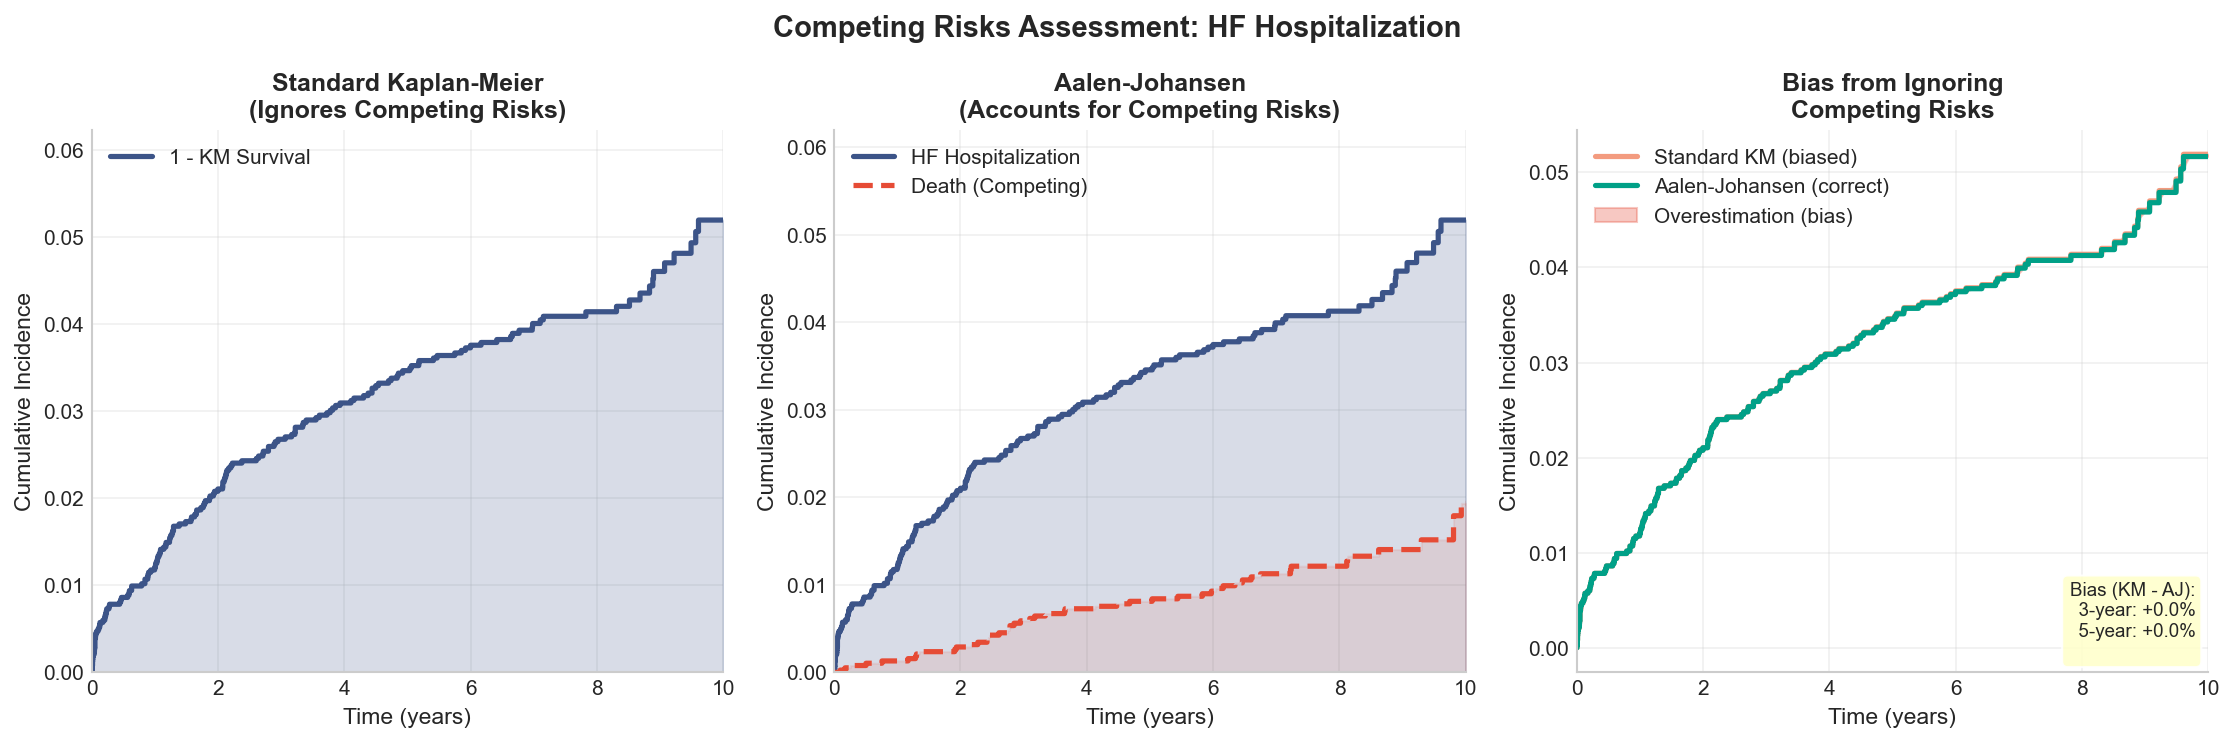


────────────────────────────────────────────────────────────
6B.5 Cumulative Incidence at Key Time Points
────────────────────────────────────────────────────────────

Cumulative Incidence Comparison:

 Time (years)  KM Cumulative Incidence (%)  AJ HF Incidence (%)  AJ Death Incidence (%)  Bias (KM - AJ) (%)
            1                          1.2                  1.2                     0.1                 0.0
            3                          2.7                  2.7                     0.6                 0.0
            5                          3.5                  3.5                     0.8                 0.0
           10                          NaN                  NaN                     NaN                 NaN

📁 Saved: cumulative_incidence_comparison.xlsx

6B.6 COMPETING RISKS ASSESSMENT SUMMARY

┌────────────────────────────────────────────────────────────────┐
│                    COMPETING RISKS SUMMARY                      │
├────────────────────────────────

In [228]:
# =============================================
# PART 6B: COMPETING RISKS ASSESSMENT
# =============================================
# PURPOSE: Determine if competing risks are substantial enough
#          to require Fine-Gray model instead of standard Cox
#
# Decision Rule:
#   - If competing event rate < 10%: Standard Cox is acceptable
#   - If competing event rate 10-20%: Report both Cox and Fine-Gray
#   - If competing event rate > 20%: Fine-Gray strongly recommended
# =============================================

print("\n" + "=" * 90)
print("PART 6B: COMPETING RISKS ASSESSMENT")
print("=" * 90)

from lifelines import AalenJohansenFitter

# ─────────────────────────────────────────────
# 6B.1 CREATE COMPETING RISKS DATA STRUCTURE
# ─────────────────────────────────────────────
print("\n" + "─" * 60)
print("6B.1 Creating Competing Risks Data Structure")
print("─" * 60)


def create_competing_risks_data(data, time_hf, event_hf, time_death, event_death):
    """
    Create competing risks dataset for HF hospitalization analysis.

    Event coding:
        0 = Censored (no event)
        1 = HF hospitalization (event of interest)
        2 = Death without prior HF hospitalization (competing event)

    Parameters:
    -----------
    data : DataFrame
    time_hf : str - Column name for time to HF hospitalization
    event_hf : str - Column name for HF event indicator
    time_death : str - Column name for time to death
    event_death : str - Column name for death indicator

    Returns:
    --------
    DataFrame with additional columns: cr_time, cr_event
    """
    df = data.copy()

    # Ensure numeric
    df[time_hf] = pd.to_numeric(df[time_hf], errors='coerce')
    df[time_death] = pd.to_numeric(df[time_death], errors='coerce')
    df[event_hf] = pd.to_numeric(df[event_hf], errors='coerce').fillna(0).astype(int)
    df[event_death] = pd.to_numeric(df[event_death], errors='coerce').fillna(0).astype(int)

    # Initialize
    df['cr_event'] = 0  # Default: censored
    df['cr_time'] = df[[time_hf, time_death]].min(axis=1)  # First event time

    # Classify events
    for idx in df.index:
        hf_occurred = df.loc[idx, event_hf] == 1
        death_occurred = df.loc[idx, event_death] == 1
        t_hf = df.loc[idx, time_hf]
        t_death = df.loc[idx, time_death]

        if hf_occurred and death_occurred:
            # Both events occurred - which was first?
            if t_hf <= t_death:
                df.loc[idx, 'cr_event'] = 1  # HF first
                df.loc[idx, 'cr_time'] = t_hf
            else:
                df.loc[idx, 'cr_event'] = 2  # Death first (competing)
                df.loc[idx, 'cr_time'] = t_death
        elif hf_occurred:
            df.loc[idx, 'cr_event'] = 1  # HF only
            df.loc[idx, 'cr_time'] = t_hf
        elif death_occurred:
            df.loc[idx, 'cr_event'] = 2  # Death only (competing)
            df.loc[idx, 'cr_time'] = t_death
        else:
            df.loc[idx, 'cr_event'] = 0  # Censored
            df.loc[idx, 'cr_time'] = min(t_hf, t_death)

    return df


# Apply to training data
train_cr = create_competing_risks_data(
    train_df,
    time_hf=OUTCOMES['hf']['time_col'],
    event_hf=OUTCOMES['hf']['event_col'],
    time_death=OUTCOMES['death']['time_col'],
    event_death=OUTCOMES['death']['event_col']
)

print("✅ Competing risks data structure created")
print(f"   Columns added: 'cr_time', 'cr_event'")

# ─────────────────────────────────────────────
# 6B.2 SUMMARIZE COMPETING RISKS
# ─────────────────────────────────────────────
print("\n" + "─" * 60)
print("6B.2 Competing Risks Distribution")
print("─" * 60)


def summarize_competing_risks(data, cr_event_col='cr_event'):
    """Summarize the distribution of competing risks."""
    n_total = len(data)
    n_censored = (data[cr_event_col] == 0).sum()
    n_hf = (data[cr_event_col] == 1).sum()
    n_death_competing = (data[cr_event_col] == 2).sum()

    # Calculate rates
    pct_censored = n_censored / n_total * 100
    pct_hf = n_hf / n_total * 100
    pct_death = n_death_competing / n_total * 100

    # Competing risk ratio: deaths / (deaths + HF events)
    total_events = n_hf + n_death_competing
    competing_ratio = n_death_competing / total_events * 100 if total_events > 0 else 0

    summary = {
        'n_total': n_total,
        'n_censored': n_censored,
        'n_hf': n_hf,
        'n_death_competing': n_death_competing,
        'pct_censored': pct_censored,
        'pct_hf': pct_hf,
        'pct_death': pct_death,
        'competing_ratio': competing_ratio
    }

    return summary


cr_summary = summarize_competing_risks(train_cr)

print(f"""
╔══════════════════════════════════════════════════════════════╗
║           COMPETING RISKS SUMMARY (Training Set)             ║
╠══════════════════════════════════════════════════════════════╣
║  Total patients:                    {cr_summary['n_total']:>6}                  ║
╠══════════════════════════════════════════════════════════════╣
║  Censored (no event):               {cr_summary['n_censored']:>6} ({cr_summary['pct_censored']:>5.1f}%)           ║
║  HF Hospitalization:                {cr_summary['n_hf']:>6} ({cr_summary['pct_hf']:>5.1f}%)           ║
║  Death (competing risk):            {cr_summary['n_death_competing']:>6} ({cr_summary['pct_death']:>5.1f}%)           ║
╠══════════════════════════════════════════════════════════════╣
║  Competing Risk Ratio*:                    {cr_summary['competing_ratio']:>5.1f}%              ║
╚══════════════════════════════════════════════════════════════╝

*Competing Risk Ratio = Deaths / (Deaths + HF Events)
""")

# ─────────────────────────────────────────────
# 6B.3 DECISION: IS FINE-GRAY NEEDED?
# ─────────────────────────────────────────────
print("─" * 60)
print("6B.3 Model Selection Decision")
print("─" * 60)

competing_ratio = cr_summary['competing_ratio']
death_rate = cr_summary['pct_death']

if death_rate < 10:
    decision = "STANDARD_COX"
    recommendation = """
    ✅ Standard Cox regression is appropriate

    Rationale:
    - Competing event (death) rate < 10%
    - Bias from ignoring competing risks is minimal
    - Fine-Gray not required, but can report as sensitivity analysis
    """
elif death_rate < 20:
    decision = "REPORT_BOTH"
    recommendation = """
    ⚠️ Moderate competing risk - Report BOTH analyses

    Rationale:
    - Competing event (death) rate 10-20%
    - Standard Cox may slightly overestimate HF cumulative incidence
    - Recommend: Primary analysis with Cox, sensitivity with Fine-Gray
    """
else:
    decision = "FINE_GRAY_RECOMMENDED"
    recommendation = """
    🔴 Substantial competing risk - Fine-Gray strongly recommended

    Rationale:
    - Competing event (death) rate > 20%
    - Standard Cox will overestimate HF cumulative incidence
    - Fine-Gray subdistribution hazard model preferred
    - At minimum: Report both and discuss differences
    """

print(recommendation)

# Store decision for later use
COMPETING_RISKS_DECISION = {
    'decision': decision,
    'death_rate': death_rate,
    'competing_ratio': competing_ratio,
    'summary': cr_summary
}

# ─────────────────────────────────────────────
# 6B.4 VISUALIZE: KM vs AALEN-JOHANSEN
# ─────────────────────────────────────────────
print("\n" + "─" * 60)
print("6B.4 Cumulative Incidence Comparison")
print("─" * 60)


def plot_km_vs_aalen_johansen(data, time_hf, event_hf, cr_time, cr_event,
                              max_years=10, out_path=None):
    """
    Compare standard Kaplan-Meier (1-S(t)) with Aalen-Johansen cumulative incidence.
    Shows the bias introduced by ignoring competing risks.
    """
    df = data.copy()
    df['_time_hf_years'] = df[time_hf] / 365.25
    df['_cr_time_years'] = df[cr_time] / 365.25

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # ─────────────────────────────────────────────
    # Panel 1: Standard Kaplan-Meier (1 - Survival)
    # ─────────────────────────────────────────────
    ax1 = axes[0]

    kmf = KaplanMeierFitter()
    kmf.fit(df['_time_hf_years'], df[event_hf], label='KM Estimate')

    times_km = kmf.survival_function_.index
    cum_inc_km = 1 - kmf.survival_function_.iloc[:, 0]

    ax1.step(times_km, cum_inc_km, where='post', color=COLORS['blue'],
             linewidth=2.5, label='1 - KM Survival')
    ax1.fill_between(times_km, cum_inc_km, step='post', alpha=0.2, color=COLORS['blue'])

    ax1.set_xlabel('Time (years)', fontsize=11)
    ax1.set_ylabel('Cumulative Incidence', fontsize=11)
    ax1.set_title('Standard Kaplan-Meier\n(Ignores Competing Risks)', fontsize=12, fontweight='bold')
    ax1.set_xlim([0, max_years])
    ax1.set_ylim([0, min(1, cum_inc_km.max() * 1.2)])
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')

    # ─────────────────────────────────────────────
    # Panel 2: Aalen-Johansen (Competing Risks)
    # ─────────────────────────────────────────────
    ax2 = axes[1]

    try:
        # HF hospitalization (event of interest)
        aj_hf = AalenJohansenFitter()
        aj_hf.fit(df['_cr_time_years'], df[cr_event], event_of_interest=1)

        times_aj = aj_hf.cumulative_density_.index
        ci_hf = aj_hf.cumulative_density_.iloc[:, 0]

        ax2.step(times_aj, ci_hf, where='post', color=COLORS['blue'],
                 linewidth=2.5, label='HF Hospitalization')
        ax2.fill_between(times_aj, ci_hf, step='post', alpha=0.2, color=COLORS['blue'])

        # Death (competing risk)
        aj_death = AalenJohansenFitter()
        aj_death.fit(df['_cr_time_years'], df[cr_event], event_of_interest=2)

        times_death = aj_death.cumulative_density_.index
        ci_death = aj_death.cumulative_density_.iloc[:, 0]

        ax2.step(times_death, ci_death, where='post', color=COLORS['red'],
                 linewidth=2.5, linestyle='--', label='Death (Competing)')
        ax2.fill_between(times_death, ci_death, step='post', alpha=0.1, color=COLORS['red'])

        aj_success = True

    except Exception as e:
        ax2.text(0.5, 0.5, f'Aalen-Johansen failed:\n{str(e)[:50]}',
                 ha='center', va='center', transform=ax2.transAxes, fontsize=10)
        aj_success = False

    ax2.set_xlabel('Time (years)', fontsize=11)
    ax2.set_ylabel('Cumulative Incidence', fontsize=11)
    ax2.set_title('Aalen-Johansen\n(Accounts for Competing Risks)', fontsize=12, fontweight='bold')
    ax2.set_xlim([0, max_years])
    ax2.set_ylim([0, min(1, max(ci_hf.max(), ci_death.max()) * 1.2) if aj_success else 1])
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left')

    # ─────────────────────────────────────────────
    # Panel 3: Direct Comparison (Bias Visualization)
    # ─────────────────────────────────────────────
    ax3 = axes[2]

    if aj_success:
        # Plot both on same axes
        ax3.step(times_km, cum_inc_km, where='post', color=COLORS['orange'],
                 linewidth=2.5, label='Standard KM (biased)')
        ax3.step(times_aj, ci_hf, where='post', color=COLORS['teal'],
                 linewidth=2.5, label='Aalen-Johansen (correct)')

        # Shade the bias area
        # Interpolate to common time points for shading
        common_times = np.linspace(0, min(times_km.max(), times_aj.max()), 100)
        km_interp = np.interp(common_times, times_km, cum_inc_km)
        aj_interp = np.interp(common_times, times_aj, ci_hf)

        ax3.fill_between(common_times, km_interp, aj_interp,
                         alpha=0.3, color=COLORS['red'], label='Overestimation (bias)')

        # Calculate bias at specific time points
        bias_text = "Bias (KM - AJ):\n"
        for t in [3, 5, 10]:
            if t <= min(times_km.max(), times_aj.max()):
                km_at_t = np.interp(t, times_km, cum_inc_km)
                aj_at_t = np.interp(t, times_aj, ci_hf)
                bias = (km_at_t - aj_at_t) * 100  # Convert to percentage points
                bias_text += f"  {t}-year: +{bias:.1f}%\n"

        ax3.text(0.98, 0.02, bias_text, transform=ax3.transAxes, fontsize=9,
                 ha='right', va='bottom', bbox=dict(boxstyle='round', facecolor='#FFFFCC', alpha=0.9))

    ax3.set_xlabel('Time (years)', fontsize=11)
    ax3.set_ylabel('Cumulative Incidence', fontsize=11)
    ax3.set_title('Bias from Ignoring\nCompeting Risks', fontsize=12, fontweight='bold')
    ax3.set_xlim([0, max_years])
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='upper left')

    plt.suptitle('Competing Risks Assessment: HF Hospitalization',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()

    if out_path:
        plt.savefig(out_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"📁 Saved: {out_path}")

    plt.show()

    return aj_success


# Generate comparison plot
aj_success = plot_km_vs_aalen_johansen(
    train_cr,
    time_hf=OUTCOMES['hf']['time_col'],
    event_hf=OUTCOMES['hf']['event_col'],
    cr_time='cr_time',
    cr_event='cr_event',
    max_years=10,
    out_path='competing_risks_comparison.png'
)

# ─────────────────────────────────────────────
# 6B.5 CUMULATIVE INCIDENCE TABLE
# ─────────────────────────────────────────────
print("\n" + "─" * 60)
print("6B.5 Cumulative Incidence at Key Time Points")
print("─" * 60)


def calculate_cumulative_incidence_table(data, time_hf, event_hf, cr_time, cr_event,
                                         time_points=[1, 3, 5, 10]):
    """
    Calculate cumulative incidence at specific time points.
    Compare standard KM vs Aalen-Johansen.
    """
    df = data.copy()
    df['_time_hf_years'] = df[time_hf] / 365.25
    df['_cr_time_years'] = df[cr_time] / 365.25

    results = []

    # Fit models
    kmf = KaplanMeierFitter()
    kmf.fit(df['_time_hf_years'], df[event_hf])

    try:
        aj_hf = AalenJohansenFitter()
        aj_hf.fit(df['_cr_time_years'], df[cr_event], event_of_interest=1)

        aj_death = AalenJohansenFitter()
        aj_death.fit(df['_cr_time_years'], df[cr_event], event_of_interest=2)

        aj_success = True
    except:
        aj_success = False

    for t in time_points:
        row = {'Time (years)': t}

        # Standard KM
        if t <= kmf.survival_function_.index.max():
            km_surv = kmf.survival_function_at_times(t).values[0]
            row['KM Cumulative Incidence (%)'] = round((1 - km_surv) * 100, 1)
        else:
            row['KM Cumulative Incidence (%)'] = np.nan

        if aj_success:
            # Aalen-Johansen for HF
            if t <= aj_hf.cumulative_density_.index.max():
                ci_hf = np.interp(t, aj_hf.cumulative_density_.index,
                                  aj_hf.cumulative_density_.iloc[:, 0])
                row['AJ HF Incidence (%)'] = round(ci_hf * 100, 1)
            else:
                row['AJ HF Incidence (%)'] = np.nan

            # Aalen-Johansen for Death
            if t <= aj_death.cumulative_density_.index.max():
                ci_death = np.interp(t, aj_death.cumulative_density_.index,
                                     aj_death.cumulative_density_.iloc[:, 0])
                row['AJ Death Incidence (%)'] = round(ci_death * 100, 1)
            else:
                row['AJ Death Incidence (%)'] = np.nan

            # Bias
            if pd.notna(row.get('KM Cumulative Incidence (%)')) and pd.notna(row.get('AJ HF Incidence (%)')):
                row['Bias (KM - AJ) (%)'] = round(
                    row['KM Cumulative Incidence (%)'] - row['AJ HF Incidence (%)'], 1
                )

        results.append(row)

    return pd.DataFrame(results)


ci_table = calculate_cumulative_incidence_table(
    train_cr,
    time_hf=OUTCOMES['hf']['time_col'],
    event_hf=OUTCOMES['hf']['event_col'],
    cr_time='cr_time',
    cr_event='cr_event'
)

print("\nCumulative Incidence Comparison:\n")
print(ci_table.to_string(index=False))

ci_table.to_excel('cumulative_incidence_comparison.xlsx', index=False)
print(f"\n📁 Saved: cumulative_incidence_comparison.xlsx")

# ─────────────────────────────────────────────
# 6B.6 FINAL SUMMARY & RECOMMENDATION
# ─────────────────────────────────────────────
print("\n" + "=" * 90)
print("6B.6 COMPETING RISKS ASSESSMENT SUMMARY")
print("=" * 90)

print(f"""
┌────────────────────────────────────────────────────────────────┐
│                    COMPETING RISKS SUMMARY                      │
├────────────────────────────────────────────────────────────────┤
│  Event of Interest:     HF Hospitalization                      │
│  Competing Event:       Death (without prior HF)                │
├────────────────────────────────────────────────────────────────┤
│  HF Events:             {cr_summary['n_hf']:>5} ({cr_summary['pct_hf']:.1f}%)                         │
│  Competing Deaths:      {cr_summary['n_death_competing']:>5} ({cr_summary['pct_death']:.1f}%)                         │
│  Censored:              {cr_summary['n_censored']:>5} ({cr_summary['pct_censored']:.1f}%)                         │
├────────────────────────────────────────────────────────────────┤
│  Competing Risk Ratio:  {cr_summary['competing_ratio']:.1f}%                                   │
├────────────────────────────────────────────────────────────────┤
│  DECISION: {decision:<52}│
└────────────────────────────────────────────────────────────────┘
""")

# Print recommendation for manuscript
if decision == "STANDARD_COX":
    manuscript_text = """
MANUSCRIPT TEXT (Methods):
"Death without prior HF hospitalization was treated as a censoring
event in the primary analysis. Given the relatively low competing
event rate ({:.1f}%), standard Cox proportional hazards regression
was deemed appropriate."
""".format(death_rate)

elif decision == "REPORT_BOTH":
    manuscript_text = """
MANUSCRIPT TEXT (Methods):
"For the HF hospitalization outcome, death without prior HF
hospitalization represents a competing risk ({:.1f}% of patients).
The primary analysis used cause-specific Cox regression, with
Fine-Gray subdistribution hazard models reported as sensitivity
analysis to account for competing risks."
""".format(death_rate)

else:  # FINE_GRAY_RECOMMENDED
    manuscript_text = """
MANUSCRIPT TEXT (Methods):
"Given the substantial competing risk from death ({:.1f}% of patients
died without prior HF hospitalization), Fine-Gray subdistribution
hazard models were used as the primary analysis for HF hospitalization.
Cause-specific Cox regression results are reported in supplementary
materials for comparison."
""".format(death_rate)

print(manuscript_text)

print("\n" + "=" * 90)
print("✅ COMPETING RISKS ASSESSMENT COMPLETE")
print("=" * 90)


PART 7: KAPLAN-MEIER CURVES

HF Hospitalization - Overall Kaplan-Meier:
  1-year survival: 98.8%
  3-year survival: 97.3%
  5-year survival: 96.5%
📁 Saved: km_train_hf_overall.png


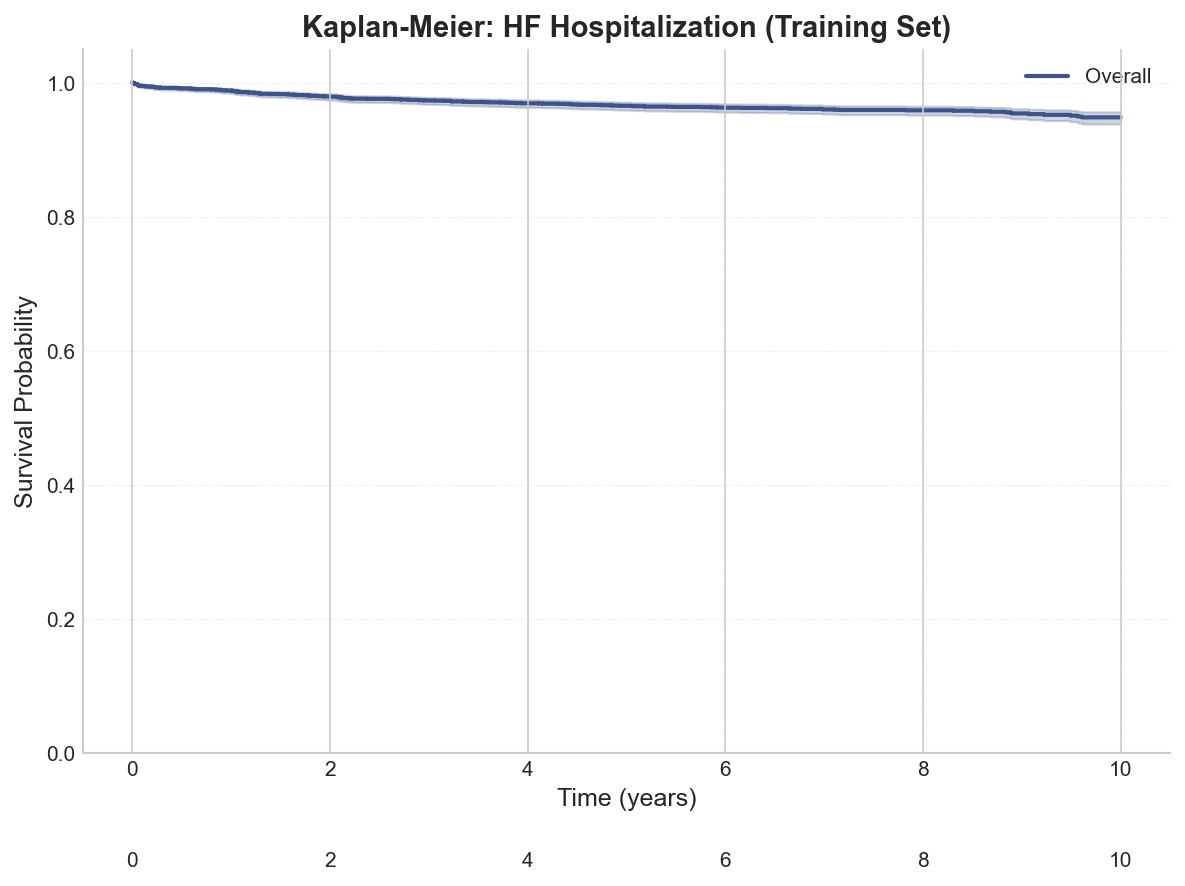


All-Cause Mortality - Overall Kaplan-Meier:
  1-year survival: 99.8%
  3-year survival: 99.3%
  5-year survival: 99.0%
📁 Saved: km_train_death_overall.png


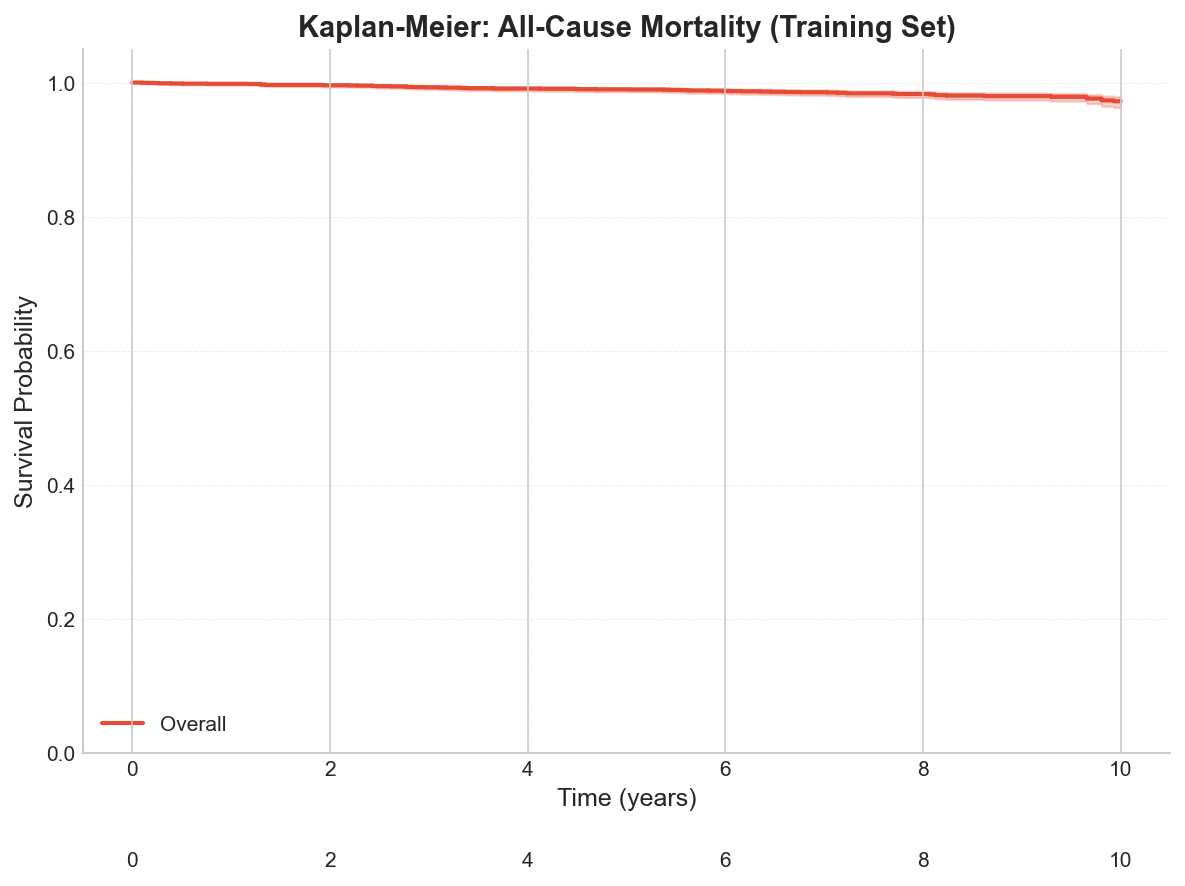

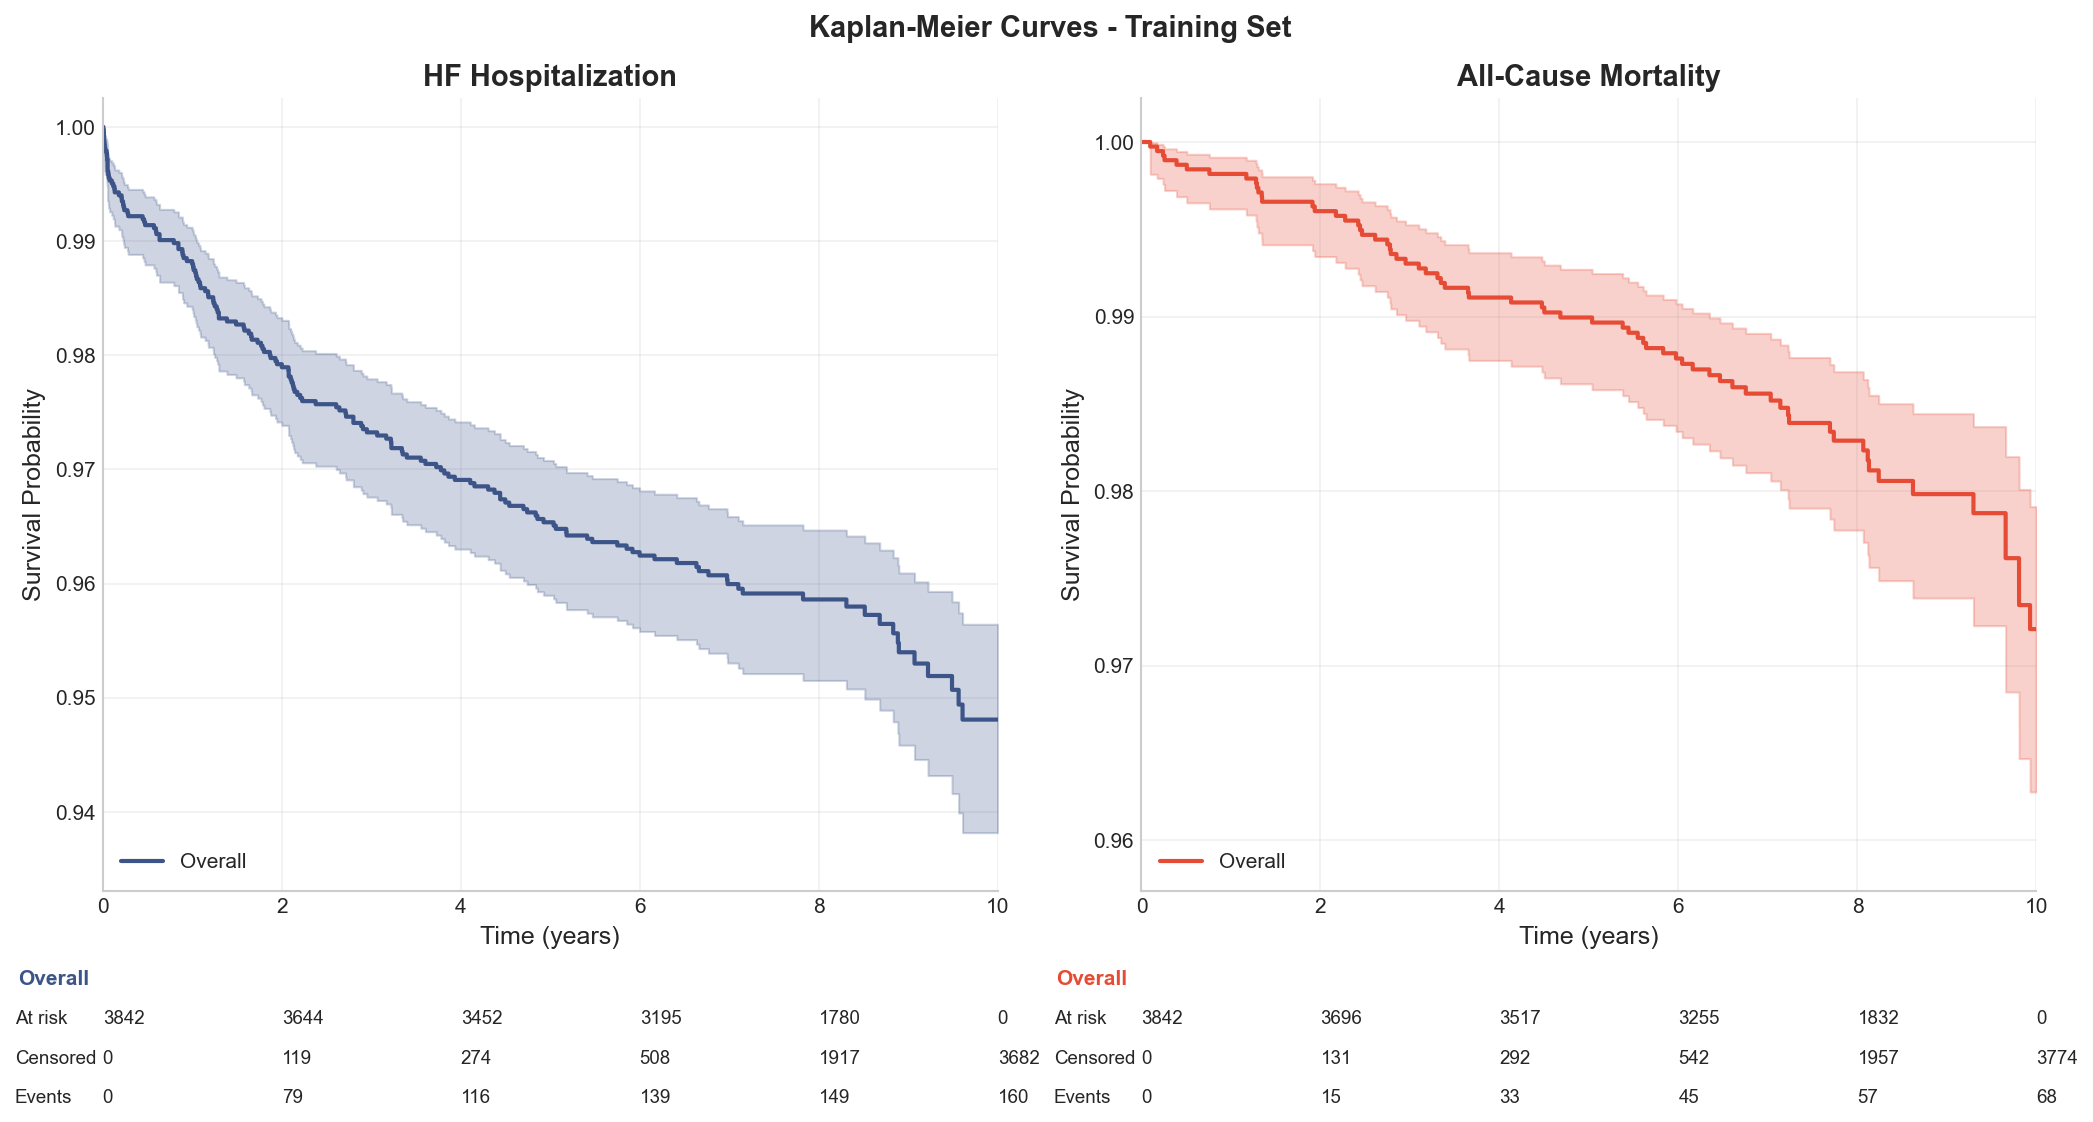

📁 Saved: km_train_both_outcomes.png


In [213]:
# =============================================
# PART 7: KAPLAN-MEIER CURVES
# =============================================
print("\n" + "=" * 90)
print("PART 7: KAPLAN-MEIER CURVES")
print("=" * 90)


def plot_km(data, time_col, event_col, group_col=None, to_years=True,
            title=None, out_path=None, color=COLORS['blue']):
    """Plot Kaplan-Meier curves."""
    df = data[[time_col, event_col] + ([group_col] if group_col else [])].copy()
    df = df.dropna(subset=[time_col, event_col])
    df[event_col] = df[event_col].astype(int)

    x_factor = 365.25 if to_years else 1.0
    x_label = "Time (years)" if to_years else "Time (days)"
    df['_time'] = df[time_col] / x_factor

    kmfs = []
    fig, ax = plt.subplots(figsize=(8, 6))

    if group_col is None:
        kmf = KaplanMeierFitter()
        kmf.fit(durations=df['_time'], event_observed=df[event_col], label='Overall')
        kmf.plot(ax=ax, ci_show=True, color=color, linewidth=2)
        kmfs.append(kmf)

        # Survival estimates
        for t in [1, 3, 5, 10]:
            if t <= df['_time'].max():
                surv = kmf.survival_function_at_times(t).values[0]
                print(f"  {t}-year survival: {surv * 100:.1f}%")
    else:
        df[group_col] = df[group_col].astype(object).fillna('Missing')
        groups = sorted(df[group_col].unique(), key=lambda x: str(x))
        colors_list = [COLORS['blue'], COLORS['red'], COLORS['teal']]

        for i, g in enumerate(groups):
            sub = df[df[group_col] == g]
            if len(sub) == 0:
                continue
            kmf = KaplanMeierFitter()
            kmf.fit(durations=sub['_time'], event_observed=sub[event_col],
                    label=f'{var_labels.get(group_col, group_col)}={g}')
            kmf.plot(ax=ax, ci_show=True, color=colors_list[i % len(colors_list)], linewidth=2)
            kmfs.append(kmf)

        lr = multivariate_logrank_test(df['_time'], df[group_col], df[event_col])
        ax.text(0.95, 0.95, f'Log-rank p = {lr.p_value:.4f}',
                transform=ax.transAxes, ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='#FFFFCC', alpha=0.8))

    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel('Survival Probability', fontsize=12)
    ax.set_title(title or 'Kaplan-Meier Curve', fontsize=14, fontweight='bold')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)
    ax.set_ylim([0, 1.05])

    try:
        add_at_risk_counts(*kmfs, ax=ax)
    except:
        pass

    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"📁 Saved: {out_path}")
    plt.show()


def calculate_at_risk_table(times, events, time_points):
    """
    Calculate at-risk, censored, and events at each time point.

    Parameters:
    -----------
    times : array-like
        Follow-up times
    events : array-like
        Event indicators (1=event, 0=censored)
    time_points : list
        Time points to calculate counts

    Returns:
    --------
    dict with 'at_risk', 'censored', 'events' lists
    """
    times = np.array(times)
    events = np.array(events)

    at_risk = []
    censored = []
    n_events = []

    prev_time = 0
    cumulative_censored = 0
    cumulative_events = 0

    for t in time_points:
        # At risk: still being followed at time t
        n_at_risk = np.sum(times >= t)
        at_risk.append(n_at_risk)

        # Events up to time t (cumulative)
        events_up_to_t = np.sum((times <= t) & (events == 1))
        n_events.append(events_up_to_t)

        # Censored up to time t (cumulative)
        censored_up_to_t = np.sum((times <= t) & (events == 0))
        censored.append(censored_up_to_t)

    return {
        'at_risk': at_risk,
        'censored': censored,
        'events': n_events
    }


# KM curves for both outcomes
for outcome_key, outcome_info in OUTCOMES.items():
    print(f"\n{outcome_info['label']} - Overall Kaplan-Meier:")
    plot_km(train_df, outcome_info['time_col'], outcome_info['event_col'],
            to_years=True,
            title=f"Kaplan-Meier: {outcome_info['label']} (Training Set)",
            out_path=f'km_train_{outcome_key}_overall.png',
            color=outcome_info['color'])

# ─────────────────────────────────────────────
# Combined KM plot for both outcomes with at-risk table
# ─────────────────────────────────────────────
time_points = [0, 2, 4, 6, 8, 10]

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

for idx, (outcome_key, outcome_info) in enumerate(OUTCOMES.items()):
    ax = axes[idx]

    # Prepare data
    df = train_df[[outcome_info['time_col'], outcome_info['event_col']]].dropna()
    df['_time'] = df[outcome_info['time_col']] / 365.25

    # Fit KM
    kmf = KaplanMeierFitter()
    kmf.fit(df['_time'], df[outcome_info['event_col']], label='Overall')
    kmf.plot(ax=ax, ci_show=True, color=outcome_info['color'], linewidth=2)

    # Calculate at-risk table
    table_data = calculate_at_risk_table(
        df['_time'].values,
        df[outcome_info['event_col']].values,
        time_points
    )

    # Plot settings
    ax.set_xlabel('Time (years)', fontsize=12)
    ax.set_ylabel('Survival Probability', fontsize=12)
    ax.set_title(f"{outcome_info['label']}", fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 10])

    # Adjust y-axis based on data
    min_surv = kmf.survival_function_.min().values[0]
    ax.set_ylim([max(0, min_surv - 0.015), 1.0025])

    ax.legend(loc='lower left')

    # ─────────────────────────────────────────────
    # Add at-risk table below plot
    # ─────────────────────────────────────────────
    # Create table text
    row_labels = ['Overall', 'At risk', 'Censored', 'Events']
    table_values = [
        [''] + ['' for _ in time_points],  # Overall label row
        ['At risk'] + [str(v) for v in table_data['at_risk']],
        ['Censored'] + [str(v) for v in table_data['censored']],
        ['Events'] + [str(v) for v in table_data['events']]
    ]

    # Add table using axis text
    table_y_start = -0.1
    row_height = 0.05

    # Column positions (normalized to axis)
    col_positions = [t / 10 for t in time_points]  # Normalize to 0-1 range

    # Add "Overall" header
    ax.text(-0.095, table_y_start, 'Overall', transform=ax.transAxes,
            fontsize=10, fontweight='bold', ha='left', va='top',
            color=outcome_info['color'])

    # Add row labels and values
    for row_idx, (row_label, row_values) in enumerate(zip(
        ['At risk', 'Censored', 'Events'],
        [table_data['at_risk'], table_data['censored'], table_data['events']]
    )):
        y_pos = table_y_start - (row_idx + 1) * row_height

        # Row label
        ax.text(-0.098, y_pos, row_label, transform=ax.transAxes,
                fontsize=9, ha='left', va='top')

        # Values at each time point
        for col_idx, (t, val) in enumerate(zip(time_points, row_values)):
            x_pos = t / 10  # Normalize time to axis coordinates
            ax.text(x_pos, y_pos, str(val), transform=ax.transAxes,
                    fontsize=9, ha='left', va='top')

plt.suptitle('Kaplan-Meier Curves - Training Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Make room for table
plt.savefig('km_train_both_outcomes.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("📁 Saved: km_train_both_outcomes.png")


PART 7B: KAPLAN-MEIER CURVES BY DIABETES STATUS


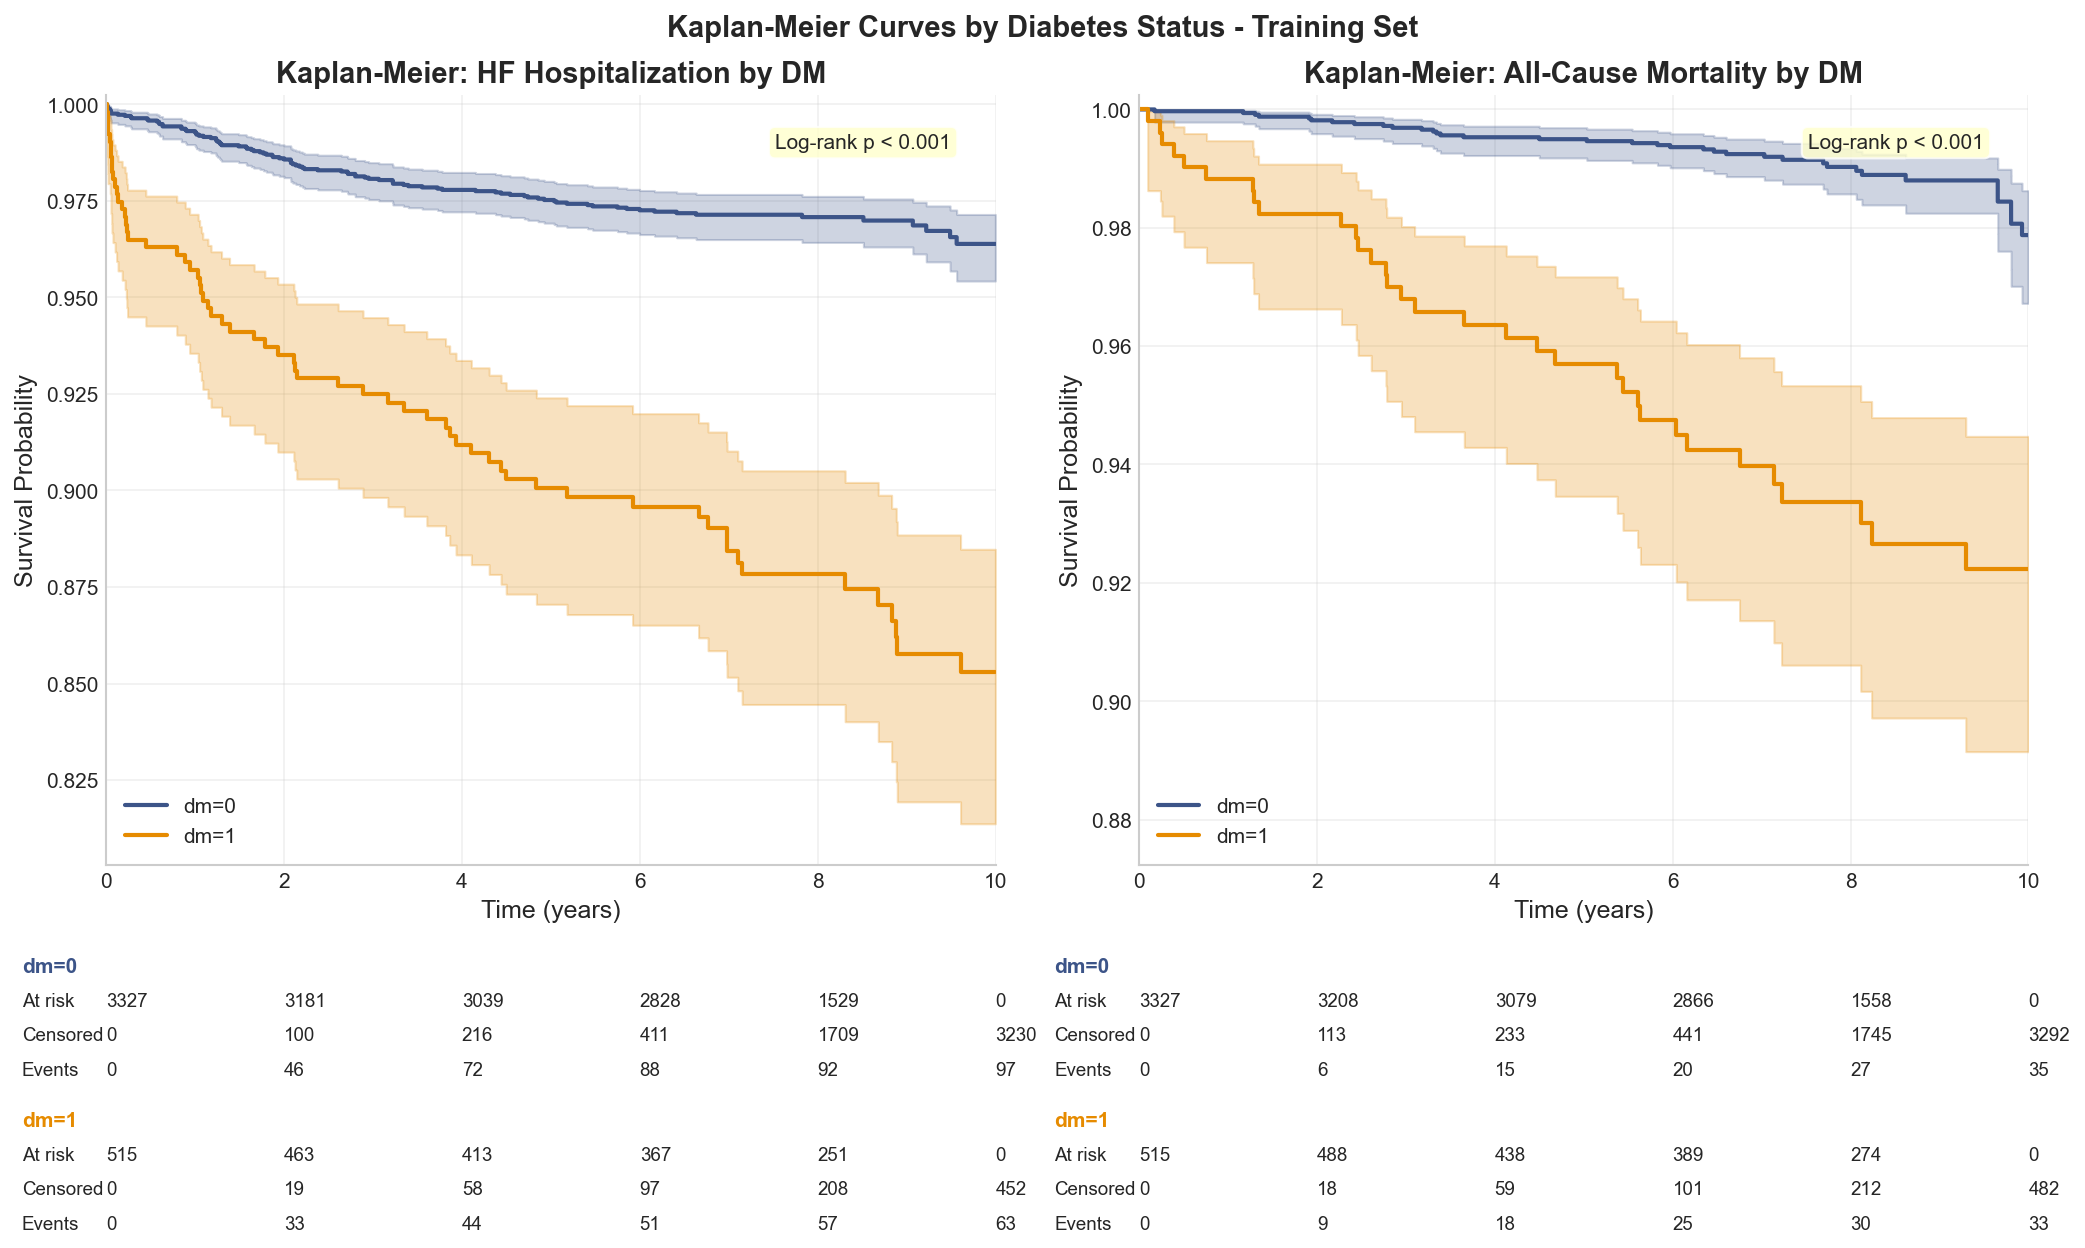


📁 Saved: km_train_by_dm.png

────────────────────────────────────────────────────────────
Summary: Event Rates by Diabetes Status
────────────────────────────────────────────────────────────

HF Hospitalization:
  dm=0: 97/3327 (2.9%), Median FU: 7.6 years
  dm=1: 63/515 (12.2%), Median FU: 7.8 years
  Log-rank p-value: < 0.001

All-Cause Mortality:
  dm=0: 35/3327 (1.1%), Median FU: 7.7 years
  dm=1: 33/515 (6.4%), Median FU: 8.3 years
  Log-rank p-value: < 0.001


In [203]:
# =============================================
# PART 7B: KAPLAN-MEIER CURVES BY DIABETES STATUS
# =============================================
print("\n" + "=" * 90)
print("PART 7B: KAPLAN-MEIER CURVES BY DIABETES STATUS")
print("=" * 90)


def calculate_at_risk_table_by_group(times, events, groups, time_points):
    """
    Calculate at-risk, censored, and events at each time point by group.
    """
    times = np.array(times)
    events = np.array(events)
    groups = np.array(groups)

    unique_groups = sorted(np.unique(groups))
    result = {}

    for grp in unique_groups:
        mask = groups == grp
        grp_times = times[mask]
        grp_events = events[mask]

        at_risk = []
        censored = []
        n_events = []

        for t in time_points:
            n_at_risk = np.sum(grp_times >= t)
            at_risk.append(n_at_risk)

            events_up_to_t = np.sum((grp_times <= t) & (grp_events == 1))
            n_events.append(events_up_to_t)

            censored_up_to_t = np.sum((grp_times <= t) & (grp_events == 0))
            censored.append(censored_up_to_t)

        result[grp] = {
            'at_risk': at_risk,
            'censored': censored,
            'events': n_events
        }

    return result


# ─────────────────────────────────────────────
# Combined KM plot by DM for both outcomes
# ─────────────────────────────────────────────
time_points = [0, 2, 4, 6, 8, 10]

# Colors and labels for DM groups
dm_colors = {
    0: COLORS['blue'],
    1: '#E68B00'  # Orange
}

dm_labels = {
    0: 'dm=0',
    1: 'dm=1'
}

fig, axes = plt.subplots(1, 2, figsize=(14, 9))

for idx, (outcome_key, outcome_info) in enumerate(OUTCOMES.items()):
    ax = axes[idx]

    # Prepare data
    cols_needed = [outcome_info['time_col'], outcome_info['event_col'], 'dm']
    df = train_df[cols_needed].dropna()
    df['_time'] = df[outcome_info['time_col']] / 365.25
    df['dm'] = df['dm'].astype(int)

    # Fit KM for each DM group
    kmfs = {}
    min_survs = []
    for dm_val in [0, 1]:
        subset = df[df['dm'] == dm_val]
        if len(subset) == 0:
            continue

        kmf = KaplanMeierFitter()
        kmf.fit(
            durations=subset['_time'],
            event_observed=subset[outcome_info['event_col']],
            label=dm_labels[dm_val]
        )
        kmf.plot(ax=ax, ci_show=True, color=dm_colors[dm_val], linewidth=2)
        kmfs[dm_val] = kmf
        min_survs.append(kmf.survival_function_.min().values[0])

    # Log-rank test
    lr = multivariate_logrank_test(df['_time'], df['dm'], df[outcome_info['event_col']])
    p_text = f"p < 0.001" if lr.p_value < 0.001 else f"p = {lr.p_value:.3f}"
    ax.text(0.95, 0.95, f'Log-rank {p_text}',
            transform=ax.transAxes, ha='right', va='top',
            fontsize=10, bbox=dict(boxstyle='round', facecolor='#FFFFCC', alpha=0.8))

    # Calculate at-risk table by group
    table_data = calculate_at_risk_table_by_group(
        df['_time'].values,
        df[outcome_info['event_col']].values,
        df['dm'].values,
        time_points
    )

    # Plot settings
    ax.set_xlabel('Time (years)', fontsize=12)
    ax.set_ylabel('Survival Probability', fontsize=12)
    ax.set_title(f"Kaplan-Meier: {outcome_info['label']} by DM", fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 10])

    # Adjust y-axis
    min_surv = min(min_survs)
    ax.set_ylim([max(0, min_surv - 0.05), 1.0025])
    ax.legend(loc='lower left', fontsize=10)

    # ─────────────────────────────────────────────
    # Add at-risk table below plot (for both DM groups)
    # ─────────────────────────────────────────────
    table_y_start = -0.12
    row_height = 0.045
    group_spacing = 0.02  # Extra space between groups

    current_y = table_y_start

    for dm_val in [0, 1]:
        grp_data = table_data[dm_val]

        # Group header (dm=0 or dm=1)
        ax.text(-0.095, current_y, dm_labels[dm_val], transform=ax.transAxes,
                fontsize=10, fontweight='bold', ha='left', va='top',
                color=dm_colors[dm_val])

        # Add rows: At risk, Censored, Events
        for row_idx, (row_label, row_values) in enumerate(zip(
            ['At risk', 'Censored', 'Events'],
            [grp_data['at_risk'], grp_data['censored'], grp_data['events']]
        )):
            y_pos = current_y - (row_idx + 1) * row_height

            # Row label
            ax.text(-0.095, y_pos, row_label, transform=ax.transAxes,
                    fontsize=9, ha='left', va='top')

            # Values at each time point
            for t, val in zip(time_points, row_values):
                x_pos = t / 10  # Normalize time to axis coordinates
                ax.text(x_pos, y_pos, str(val), transform=ax.transAxes,
                        fontsize=9, ha='left', va='top')

        # Move to next group
        current_y = current_y - 4 * row_height - group_spacing

plt.suptitle('Kaplan-Meier Curves by Diabetes Status - Training Set',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(bottom=0.35)  # Make room for table
plt.savefig('km_train_by_dm.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("\n📁 Saved: km_train_by_dm.png")

# ─────────────────────────────────────────────
# Print summary statistics
# ─────────────────────────────────────────────
print("\n" + "─" * 60)
print("Summary: Event Rates by Diabetes Status")
print("─" * 60)

for outcome_key, outcome_info in OUTCOMES.items():
    print(f"\n{outcome_info['label']}:")

    cols_needed = [outcome_info['time_col'], outcome_info['event_col'], 'dm']
    df = train_df[cols_needed].dropna()
    df['_time'] = df[outcome_info['time_col']] / 365.25

    for dm_val in [0, 1]:
        subset = df[df['dm'] == dm_val]
        n_total = len(subset)
        n_events = int(subset[outcome_info['event_col']].sum())
        rate = n_events / n_total * 100 if n_total > 0 else 0
        median_fu = subset['_time'].median()
        print(f"  {dm_labels[dm_val]}: {n_events}/{n_total} ({rate:.1f}%), Median FU: {median_fu:.1f} years")

    # Log-rank test
    lr = multivariate_logrank_test(df['_time'], df['dm'], df[outcome_info['event_col']])
    p_text = f"< 0.001" if lr.p_value < 0.001 else f"{lr.p_value:.3f}"
    print(f"  Log-rank p-value: {p_text}")


PART 8: CORRELATION MATRIX & VIF ANALYSIS

────────────────────────────────────────────────────────────
8.1 CORRELATION MATRIX
────────────────────────────────────────────────────────────
📁 Saved: correlation_matrix.xlsx

────────────────────────────────────────────────────────────
8.2 HIGH CORRELATION PAIRS (|r| > 0.5)
────────────────────────────────────────────────────────────

Found 17 pairs with |r| > 0.5:

Variable 1 Variable 2  Correlation   |r|
      IVSd      LVPWd        0.830 0.830
       RWT      LVPWd        0.815 0.815
     LVIDd      LVIDs        0.799 0.799
     LVPWd       LVMi        0.787 0.787
      IVSd       LVMi        0.752 0.752
       SBP        DBP        0.741 0.741
     HbA1c        FBS        0.704 0.704
       RWT       IVSd        0.678 0.678
       Age         e'       -0.662 0.662
        e'       E/e'       -0.652 0.652
         A       E/e'        0.630 0.630
       Age       eGFR       -0.604 0.604
     LVIDd       LVVi        0.554 0.554
     LVID

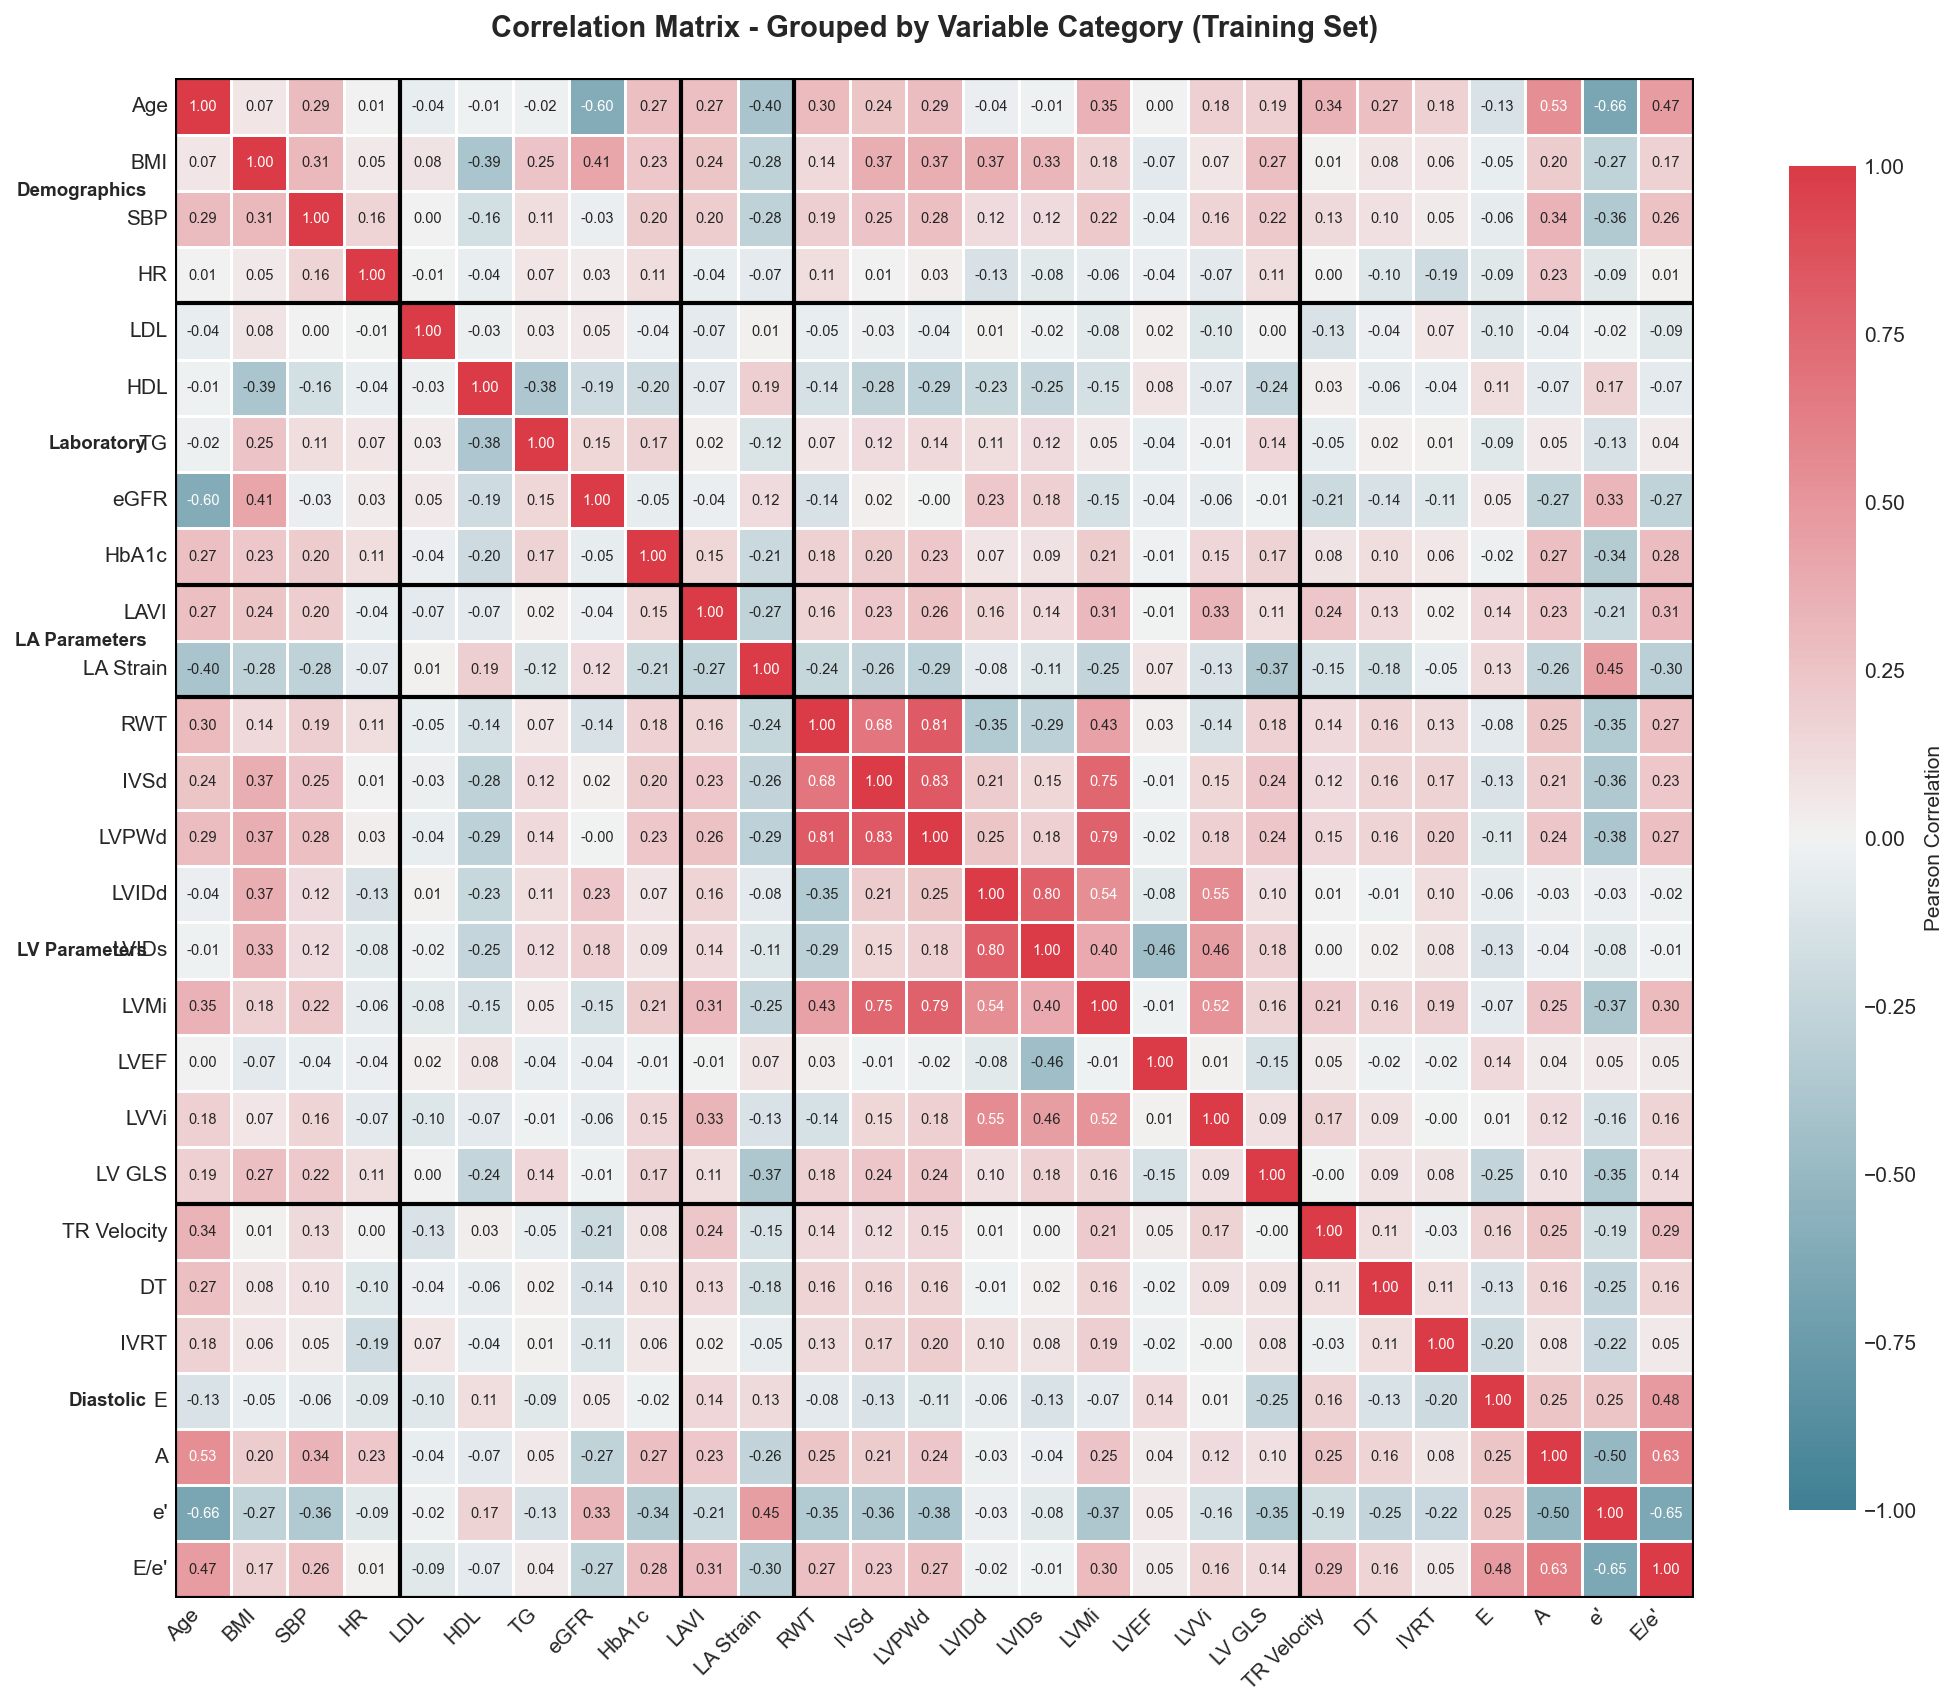

📁 Saved: correlation_heatmap_grouped.png

────────────────────────────────────────────────────────────
8.4 VARIANCE INFLATION FACTOR (VIF)
────────────────────────────────────────────────────────────

Samples for VIF: 3842 (after dropping missing)

VIF Results:
      Label   VIF     Status
      LVPWd 99.05    ⚠️ High
        RWT 97.02    ⚠️ High
      LVIDd 36.95    ⚠️ High
       LVMi 11.61    ⚠️ High
       E/e'  8.16 ⚡ Moderate
         e'  7.33 ⚡ Moderate
      LVIDs  5.11 ⚡ Moderate
          E  4.97       ✅ OK
       IVSd  4.96       ✅ OK
        Age  3.48       ✅ OK
        SBP  2.87       ✅ OK
        BMI  2.85       ✅ OK
        DBP  2.65       ✅ OK
       eGFR  2.47       ✅ OK
          A  2.28       ✅ OK
       LVVi  2.16       ✅ OK
      HbA1c  2.13       ✅ OK
        FBS  2.11       ✅ OK
       LVEF  1.82       ✅ OK
  LA Strain  1.49       ✅ OK
        HDL  1.45       ✅ OK
       LAVI  1.39       ✅ OK
     LV GLS  1.38       ✅ OK
         HR  1.30       ✅ OK
TR Velocity  

In [204]:
# =============================================
# PART 8: CORRELATION MATRIX & VIF ANALYSIS
# =============================================
print("\n" + "=" * 90)
print("PART 8: CORRELATION MATRIX & VIF ANALYSIS")
print("=" * 90)

# ─────────────────────────────────────────────
# 8.1 CORRELATION MATRIX
# ─────────────────────────────────────────────
print("\n" + "─" * 60)
print("8.1 CORRELATION MATRIX")
print("─" * 60)

numerical_predictor_cols = [c for c in numerical_vars if c in train_df.columns]
corr_matrix = train_df[numerical_predictor_cols].corr(method='pearson')

# Save correlation matrix
corr_matrix.to_excel('correlation_matrix.xlsx')
print("📁 Saved: correlation_matrix.xlsx")

# ─────────────────────────────────────────────
# 8.2 HIGH CORRELATION PAIRS
# ─────────────────────────────────────────────
print("\n" + "─" * 60)
print("8.2 HIGH CORRELATION PAIRS (|r| > 0.5)")
print("─" * 60)

upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_pairs = []
for col in upper_tri.columns:
    for idx in upper_tri.index:
        val = upper_tri.loc[idx, col]
        if pd.notna(val) and abs(val) > 0.5:
            high_corr_pairs.append({
                'Variable 1': var_labels.get(idx, idx),
                'Variable 2': var_labels.get(col, col),
                'Correlation': round(val, 3),
                '|r|': round(abs(val), 3)
            })

high_corr_df = pd.DataFrame(high_corr_pairs)
if len(high_corr_df) > 0:
    high_corr_df = high_corr_df.sort_values('|r|', ascending=False)
    print(f"\nFound {len(high_corr_df)} pairs with |r| > 0.5:\n")
    print(high_corr_df.to_string(index=False))
    high_corr_df.to_excel('high_correlation_pairs.xlsx', index=False)
    print("\n📁 Saved: high_correlation_pairs.xlsx")
else:
    print("\n✅ No pairs with |r| > 0.5 found.")

# ─────────────────────────────────────────────
# 8.3 GROUPED CORRELATION HEATMAP
# ─────────────────────────────────────────────
print("\n" + "─" * 60)
print("8.3 GROUPED CORRELATION HEATMAP")
print("─" * 60)

groups = {
    'Demographics': ['age', 'BMI', 'sbp', 'hr'],
    'Laboratory': ['LDL', 'HDL', 'tg', 'eGFR', 'A1C'],
    'LA Parameters': ['LAVI', 'la_strain_avg'],
    'LV Parameters': ['rwt', 'IVSd', 'LVPWd', 'LVIDd', 'LVIDs', 'LVmass_index', 'LVEF', 'LV_volume_index', 'LVstrain_avg'],
    'Diastolic': ['TR_V', 'dt', 'ivrt', 'E', 'A', 'TDI_Ea_mean', 'E_Ea_mean']
}

ordered_vars = []
group_boundaries = [0]
for group_name, vars_list in groups.items():
    existing = [v for v in vars_list if v in numerical_predictor_cols]
    ordered_vars.extend(existing)
    group_boundaries.append(len(ordered_vars))

corr_ordered = corr_matrix.loc[ordered_vars, ordered_vars]
ordered_labels = [var_labels.get(v, v) for v in ordered_vars]

cmap = sns.diverging_palette(220, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(14, 12))

sns.heatmap(
    corr_ordered, cmap=cmap, center=0, vmin=-1, vmax=1,
    annot=True, fmt='.2f', annot_kws={'size': 7}, square=True,
    linewidths=0.5, linecolor='white',
    xticklabels=ordered_labels, yticklabels=ordered_labels,
    cbar_kws={'shrink': 0.8, 'label': 'Pearson Correlation'}
)

for boundary in group_boundaries:
    ax.axhline(y=boundary, color='black', linewidth=2)
    ax.axvline(x=boundary, color='black', linewidth=2)

# Add group labels
group_names = list(groups.keys())
for i, (group_name, boundary_start) in enumerate(zip(group_names, group_boundaries[:-1])):
    boundary_end = group_boundaries[i + 1]
    mid_point = (boundary_start + boundary_end) / 2
    ax.text(-0.5, mid_point, group_name, ha='right', va='center', fontsize=9, fontweight='bold')

plt.title('Correlation Matrix - Grouped by Variable Category (Training Set)',
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('correlation_heatmap_grouped.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("📁 Saved: correlation_heatmap_grouped.png")

# ─────────────────────────────────────────────
# 8.4 VARIANCE INFLATION FACTOR (VIF)
# ─────────────────────────────────────────────
print("\n" + "─" * 60)
print("8.4 VARIANCE INFLATION FACTOR (VIF)")
print("─" * 60)

df_vif = train_df[numerical_predictor_cols].dropna()
print(f"\nSamples for VIF: {len(df_vif)} (after dropping missing)")

vif_data = []
X = df_vif.values
X_with_const = add_constant(X)

for i, col in enumerate(df_vif.columns):
    try:
        vif = variance_inflation_factor(X_with_const, i + 1)
        vif_data.append({'Variable': col, 'Label': var_labels.get(col, col), 'VIF': round(vif, 2)})
    except Exception as e:
        vif_data.append({'Variable': col, 'Label': var_labels.get(col, col), 'VIF': np.nan})

vif_df = pd.DataFrame(vif_data).sort_values('VIF', ascending=False)
vif_df['Status'] = vif_df['VIF'].apply(
    lambda x: '⚠️ High' if x >= 10 else ('⚡ Moderate' if x >= 5 else '✅ OK')
)

print("\nVIF Results:")
print(vif_df[['Label', 'VIF', 'Status']].to_string(index=False))

vif_df.to_excel('vif_analysis.xlsx', index=False)
print("\n📁 Saved: vif_analysis.xlsx")

# VIF bar plot
fig, ax = plt.subplots(figsize=(10, 10))

vif_plot = vif_df.sort_values('VIF', ascending=True)

colors_vif = []
for vif in vif_plot['VIF']:
    if vif >= 10:
        colors_vif.append(COLORS['red'])
    elif vif >= 5:
        colors_vif.append(COLORS['orange'])
    else:
        colors_vif.append(COLORS['blue'])

bars = ax.barh(vif_plot['Label'], vif_plot['VIF'], color=colors_vif, edgecolor='white', alpha=0.85)

ax.axvline(x=5, color=COLORS['orange'], linestyle='--', linewidth=2, label='Moderate (VIF=5)')
ax.axvline(x=10, color=COLORS['red'], linestyle='--', linewidth=2, label='High (VIF=10)')

for bar, vif in zip(bars, vif_plot['VIF']):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2,
            f'{vif:.1f}', va='center', fontsize=9)

ax.set_xlabel('Variance Inflation Factor (VIF)', fontsize=12)
ax.set_title('VIF Analysis - Multicollinearity Assessment', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.set_xlim(0, max(vif_plot['VIF']) * 1.15)

plt.tight_layout()
plt.savefig('vif_barplot.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("📁 Saved: vif_barplot.png")

# VIF Summary
low_vif = len(vif_df[vif_df['VIF'] < 5])
mod_vif = len(vif_df[(vif_df['VIF'] >= 5) & (vif_df['VIF'] < 10)])
high_vif = len(vif_df[vif_df['VIF'] >= 10])

print(f"\nVIF Summary:")
print(f"  Low (< 5):       {low_vif} variables ✅")
print(f"  Moderate (5-10): {mod_vif} variables ⚡")
print(f"  High (≥ 10):     {high_vif} variables ⚠️")

if high_vif > 0:
    print("\n⚠️ Variables with HIGH VIF (≥ 10):")
    for _, row in vif_df[vif_df['VIF'] >= 10].iterrows():
        print(f"   • {row['Label']}: VIF = {row['VIF']}")

In [205]:
# =============================================
# PART 9: STANDARDIZE NUMERICAL VARIABLES
# =============================================
print("\n" + "=" * 90)
print("PART 9: STANDARDIZE NUMERICAL VARIABLES")
print("=" * 90)

scaler = StandardScaler()
train_scaled = train_df.copy()
test_scaled = test_df.copy()

train_scaled[numerical_predictor_cols] = scaler.fit_transform(train_df[numerical_predictor_cols])
test_scaled[numerical_predictor_cols] = scaler.transform(test_df[numerical_predictor_cols])

print(f"Standardized {len(numerical_predictor_cols)} numerical predictors")



PART 9: STANDARDIZE NUMERICAL VARIABLES
Standardized 29 numerical predictors


In [206]:
# =============================================
# PART 10: COX MODEL BUILDING FUNCTIONS
# =============================================
print("\n" + "=" * 90)
print("PART 10: COX MODEL BUILDING FUNCTIONS")
print("=" * 90)


def cross_validate_cox(data, time_col, event_col, penalizer_range, l1_ratio=0.5,
                       n_folds=5, random_state=42, verbose=True):
    """Cross-validate Cox model to find optimal penalizer."""
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    results = []

    for penalizer in penalizer_range:
        fold_c_indices = []
        for fold_idx, (tr_idx, val_idx) in enumerate(kf.split(data)):
            train_fold = data.iloc[tr_idx]
            val_fold = data.iloc[val_idx]
            try:
                cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
                cph.fit(train_fold, duration_col=time_col, event_col=event_col)
                predictions = cph.predict_partial_hazard(val_fold)
                c_index = concordance_index(val_fold[time_col], -predictions, val_fold[event_col])
                fold_c_indices.append(c_index)
            except:
                fold_c_indices.append(np.nan)

        mean_c = np.nanmean(fold_c_indices)
        std_c = np.nanstd(fold_c_indices)
        results.append({
            'penalizer': penalizer,
            'mean_c_index': mean_c,
            'std_c_index': std_c
        })
        if verbose:
            print(f"  Penalizer: {penalizer:.5f} | C-index: {mean_c:.4f} ± {std_c:.4f}")

    return pd.DataFrame(results)


def stability_selection(data, time_col, event_col, penalizer_range, n_iterations=30,
                        l1_ratio=0.5, n_folds=5, verbose=True):
    """Run stability selection analysis."""
    all_coefficients = []
    all_penalizers = []
    all_c_indices = []

    for i in range(n_iterations):
        rs = 42 + i
        cv_res = cross_validate_cox(data, time_col, event_col, penalizer_range,
                                    l1_ratio=l1_ratio, n_folds=n_folds,
                                    random_state=rs, verbose=False)
        best_pen = cv_res.loc[cv_res['mean_c_index'].idxmax(), 'penalizer']
        best_c = cv_res.loc[cv_res['mean_c_index'].idxmax(), 'mean_c_index']

        cph_temp = CoxPHFitter(penalizer=best_pen, l1_ratio=l1_ratio)
        cph_temp.fit(data, duration_col=time_col, event_col=event_col)

        all_coefficients.append(cph_temp.params_)
        all_penalizers.append(best_pen)
        all_c_indices.append(best_c)

        if verbose and (i + 1) % 10 == 0:
            print(f"  Completed {i + 1}/{n_iterations} iterations")

    coef_df = pd.DataFrame(all_coefficients)

    stability_results = pd.DataFrame({
        'Variable': coef_df.columns,
        'Selection_Frequency': (coef_df != 0).mean(),
        'Mean_Coefficient': coef_df.mean(),
        'Std_Coefficient': coef_df.std(),
        'Mean_HR': np.exp(coef_df.mean()),
    })

    return stability_results, all_penalizers, all_c_indices, coef_df


def plot_km_by_risk_groups(data, time_col, event_col, title_suffix="", out_path=None):
    """Plot KM curves by risk groups."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    colors_risk = {'Low': COLORS['teal'], 'Medium': COLORS['orange'], 'High': COLORS['red']}

    data = data.copy()
    data['_time'] = data[time_col] / 365.25

    # Survival plot
    kmf_list = []
    for risk in ['Low', 'Medium', 'High']:
        subset = data[data['risk_group'] == risk]
        if len(subset) == 0:
            continue
        kmf = KaplanMeierFitter()
        kmf.fit(subset['_time'], subset[event_col], label=f'{risk}')
        kmf.plot(ax=ax1, color=colors_risk[risk], ci_show=True, linewidth=2)
        kmf_list.append(kmf)

    lr = multivariate_logrank_test(data['_time'], data['risk_group'], data[event_col])
    ax1.text(0.95, 0.95, f'p = {lr.p_value:.4e}', transform=ax1.transAxes,
             ha='right', va='top', bbox=dict(boxstyle='round', facecolor='#FFFFCC', alpha=0.8))

    ax1.set_xlabel('Time (years)', fontsize=12)
    ax1.set_ylabel('Survival Probability', fontsize=12)
    ax1.set_title(f'Kaplan-Meier {title_suffix}', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1.05])
    ax1.legend(loc='lower left')

    try:
        add_at_risk_counts(*kmf_list, ax=ax1)
    except:
        pass

    # Cumulative incidence
    for risk in ['Low', 'Medium', 'High']:
        subset = data[data['risk_group'] == risk]
        if len(subset) == 0:
            continue
        kmf = KaplanMeierFitter()
        kmf.fit(subset['_time'], subset[event_col])
        times = kmf.survival_function_.index
        cum_inc = 1 - kmf.survival_function_.iloc[:, 0]
        ax2.plot(times, cum_inc, color=colors_risk[risk], label=f'{risk}', linewidth=2)

    ax2.set_xlabel('Time (years)', fontsize=12)
    ax2.set_ylabel('Cumulative Incidence', fontsize=12)
    ax2.set_title(f'Cumulative Incidence {title_suffix}', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left')

    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"📁 Saved: {out_path}")
    plt.show()

    return lr


def calc_auc_at_time(data, time_col, event_col, t_days):
    """Calculate AUC at specific time point."""
    at_risk = data[data[time_col] >= t_days].copy()
    had_event = data[(data[time_col] < t_days) & (data[event_col] == 1)].copy()

    had_event['binary'] = 1
    at_risk['binary'] = 0

    combined = pd.concat([had_event[['risk_score', 'binary']], at_risk[['risk_score', 'binary']]])

    if len(combined) > 0 and combined['binary'].nunique() > 1:
        fpr, tpr, _ = roc_curve(combined['binary'], combined['risk_score'])
        return auc(fpr, tpr), fpr, tpr
    return np.nan, None, None


print("Model building functions defined.")


PART 10: COX MODEL BUILDING FUNCTIONS
Model building functions defined.



PART 11: BUILD MODELS FOR BOTH OUTCOMES

MODELING: HF HOSPITALIZATION

Sample Size Adequacy:
  Training samples: 3842
  Test samples: 1647
  Events: 160, Predictors: 37, EPV: 4.3
  ⚠️ EPV < 10: Regularization recommended

Searching for optimal penalizer (5-fold CV)...
  Penalizer: 0.00010 | C-index: 0.6889 ± 0.1763
  Penalizer: 0.00018 | C-index: 0.7926 ± 0.0546
  Penalizer: 0.00034 | C-index: 0.6946 ± 0.1315
  Penalizer: 0.00062 | C-index: 0.6574 ± 0.2396
  Penalizer: 0.00113 | C-index: 0.6858 ± 0.1919
  Penalizer: 0.00207 | C-index: 0.7705 ± 0.1014
  Penalizer: 0.00379 | C-index: 0.7114 ± 0.2176
  Penalizer: 0.00695 | C-index: 0.8288 ± 0.0335
  Penalizer: 0.01274 | C-index: 0.8277 ± 0.0331
  Penalizer: 0.02336 | C-index: 0.8263 ± 0.0324
  Penalizer: 0.04281 | C-index: 0.8204 ± 0.0326
  Penalizer: 0.07848 | C-index: 0.7727 ± 0.0533
  Penalizer: 0.14384 | C-index: 0.8120 ± 0.0352
  Penalizer: 0.26367 | C-index: 0.8114 ± 0.0352
  Penalizer: 0.48329 | C-index: 0.8113 ± 0.0353
  Penalize

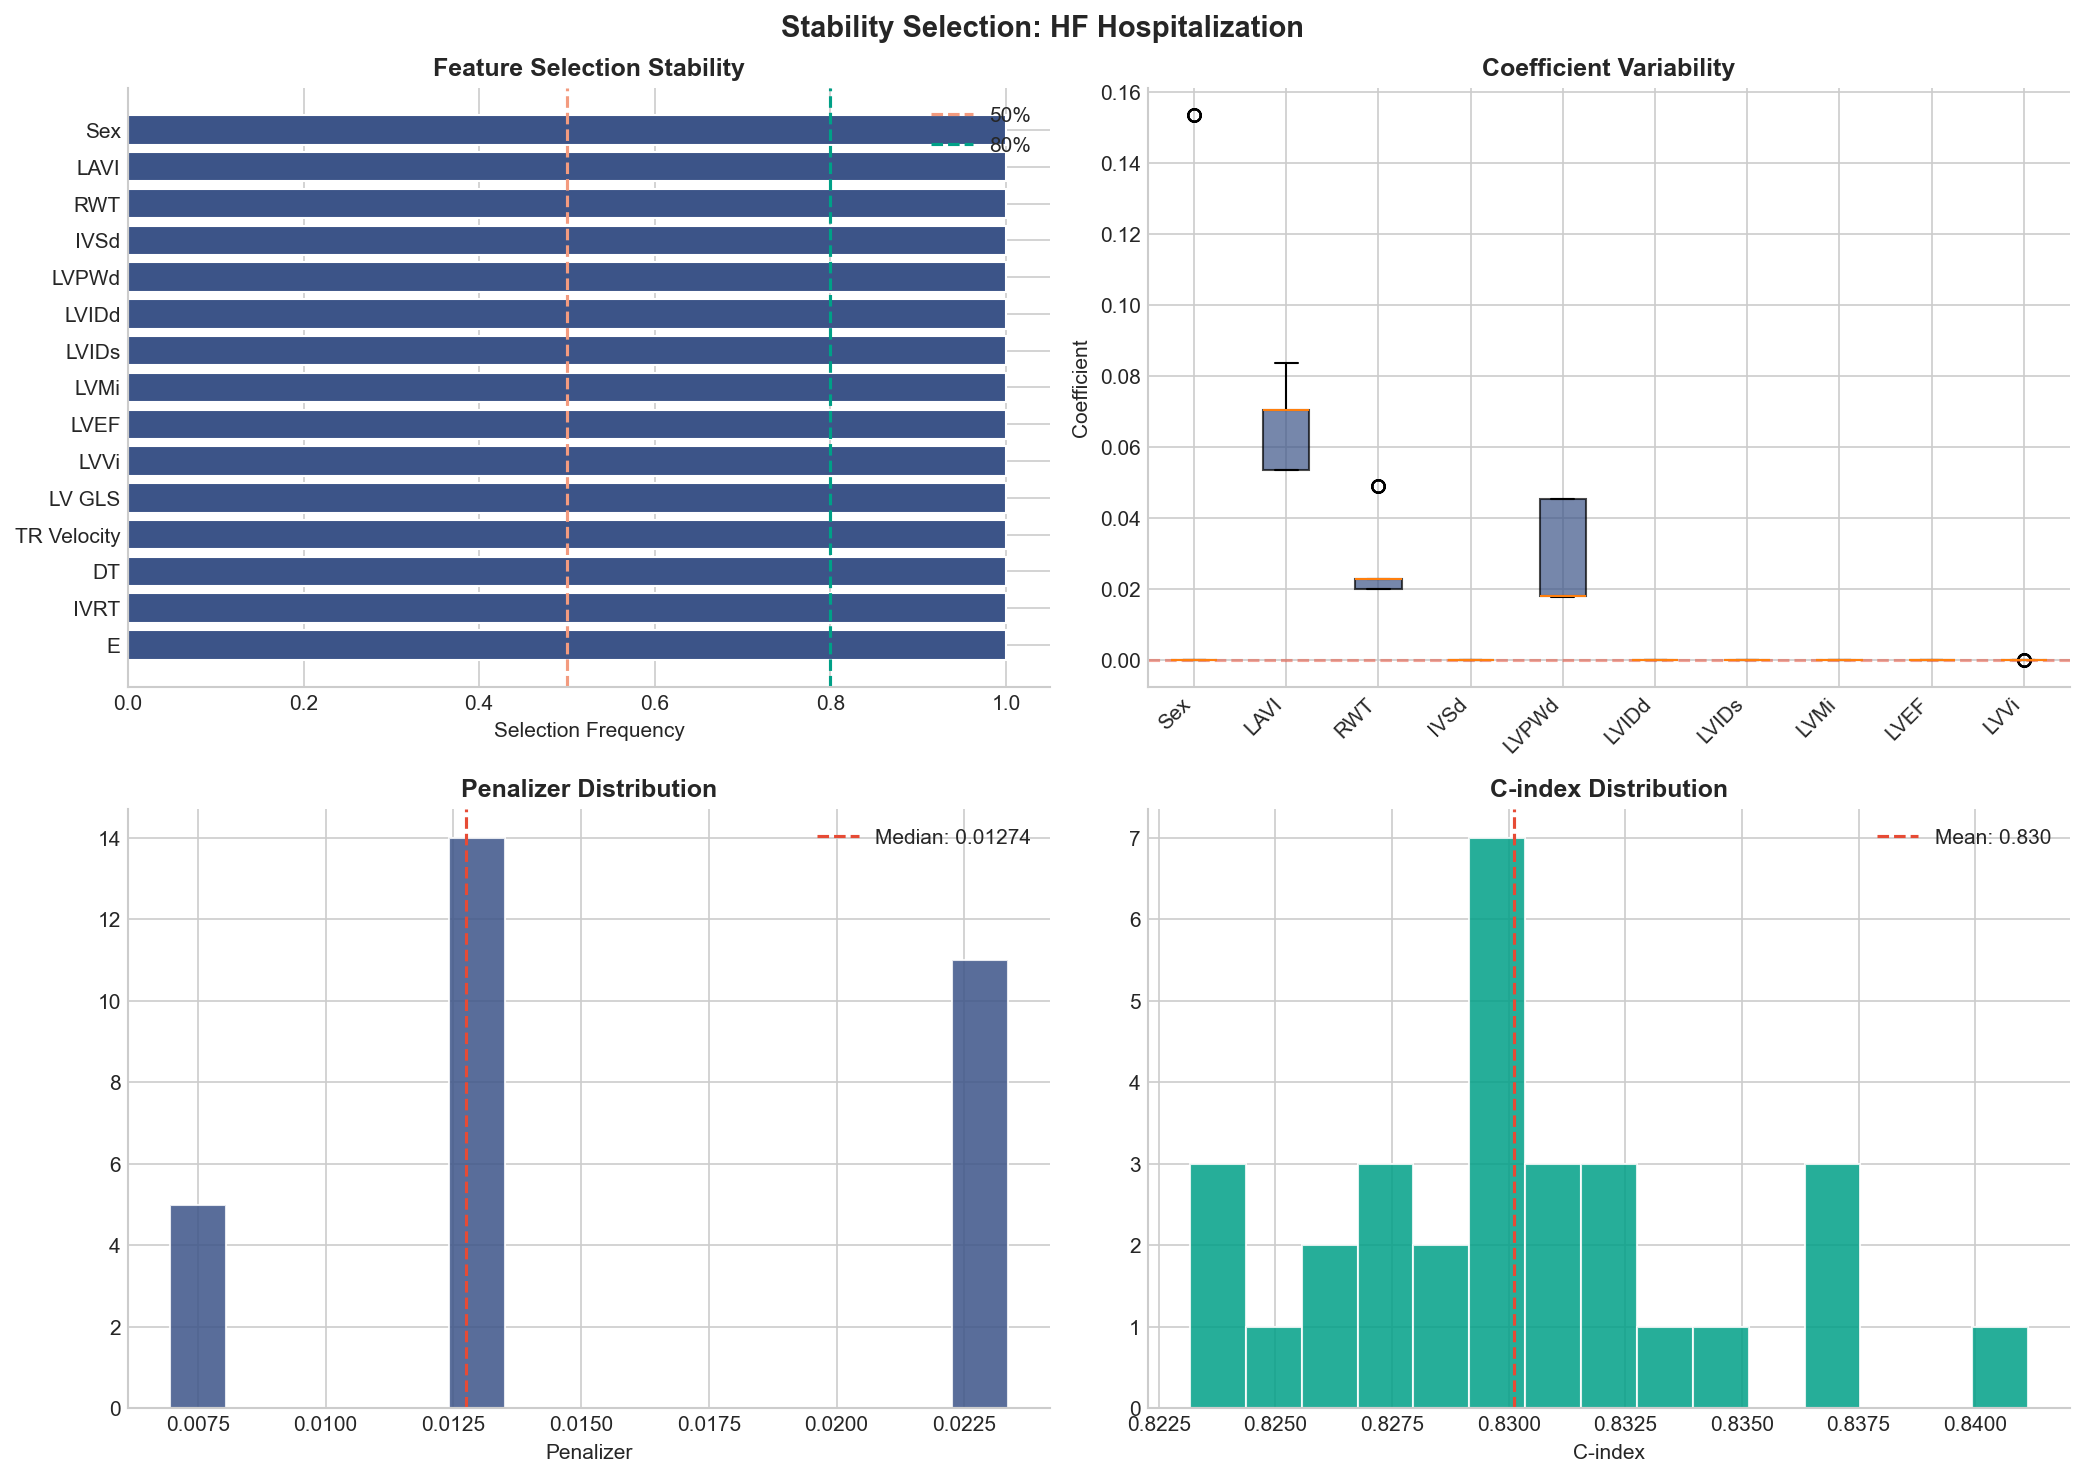

📁 Saved: stability_analysis_hf.png

Risk Stratification (Tertiles)...

Event Rates by Risk Group (Test Set):
  Low: 3/582 (0.5%)
  Medium: 7/532 (1.3%)
  High: 59/533 (11.1%)

Generating KM curves by risk groups...
📁 Saved: km_risk_groups_hf_train.png
📁 Saved: km_risk_groups_hf_test.png

Generating forest plot...


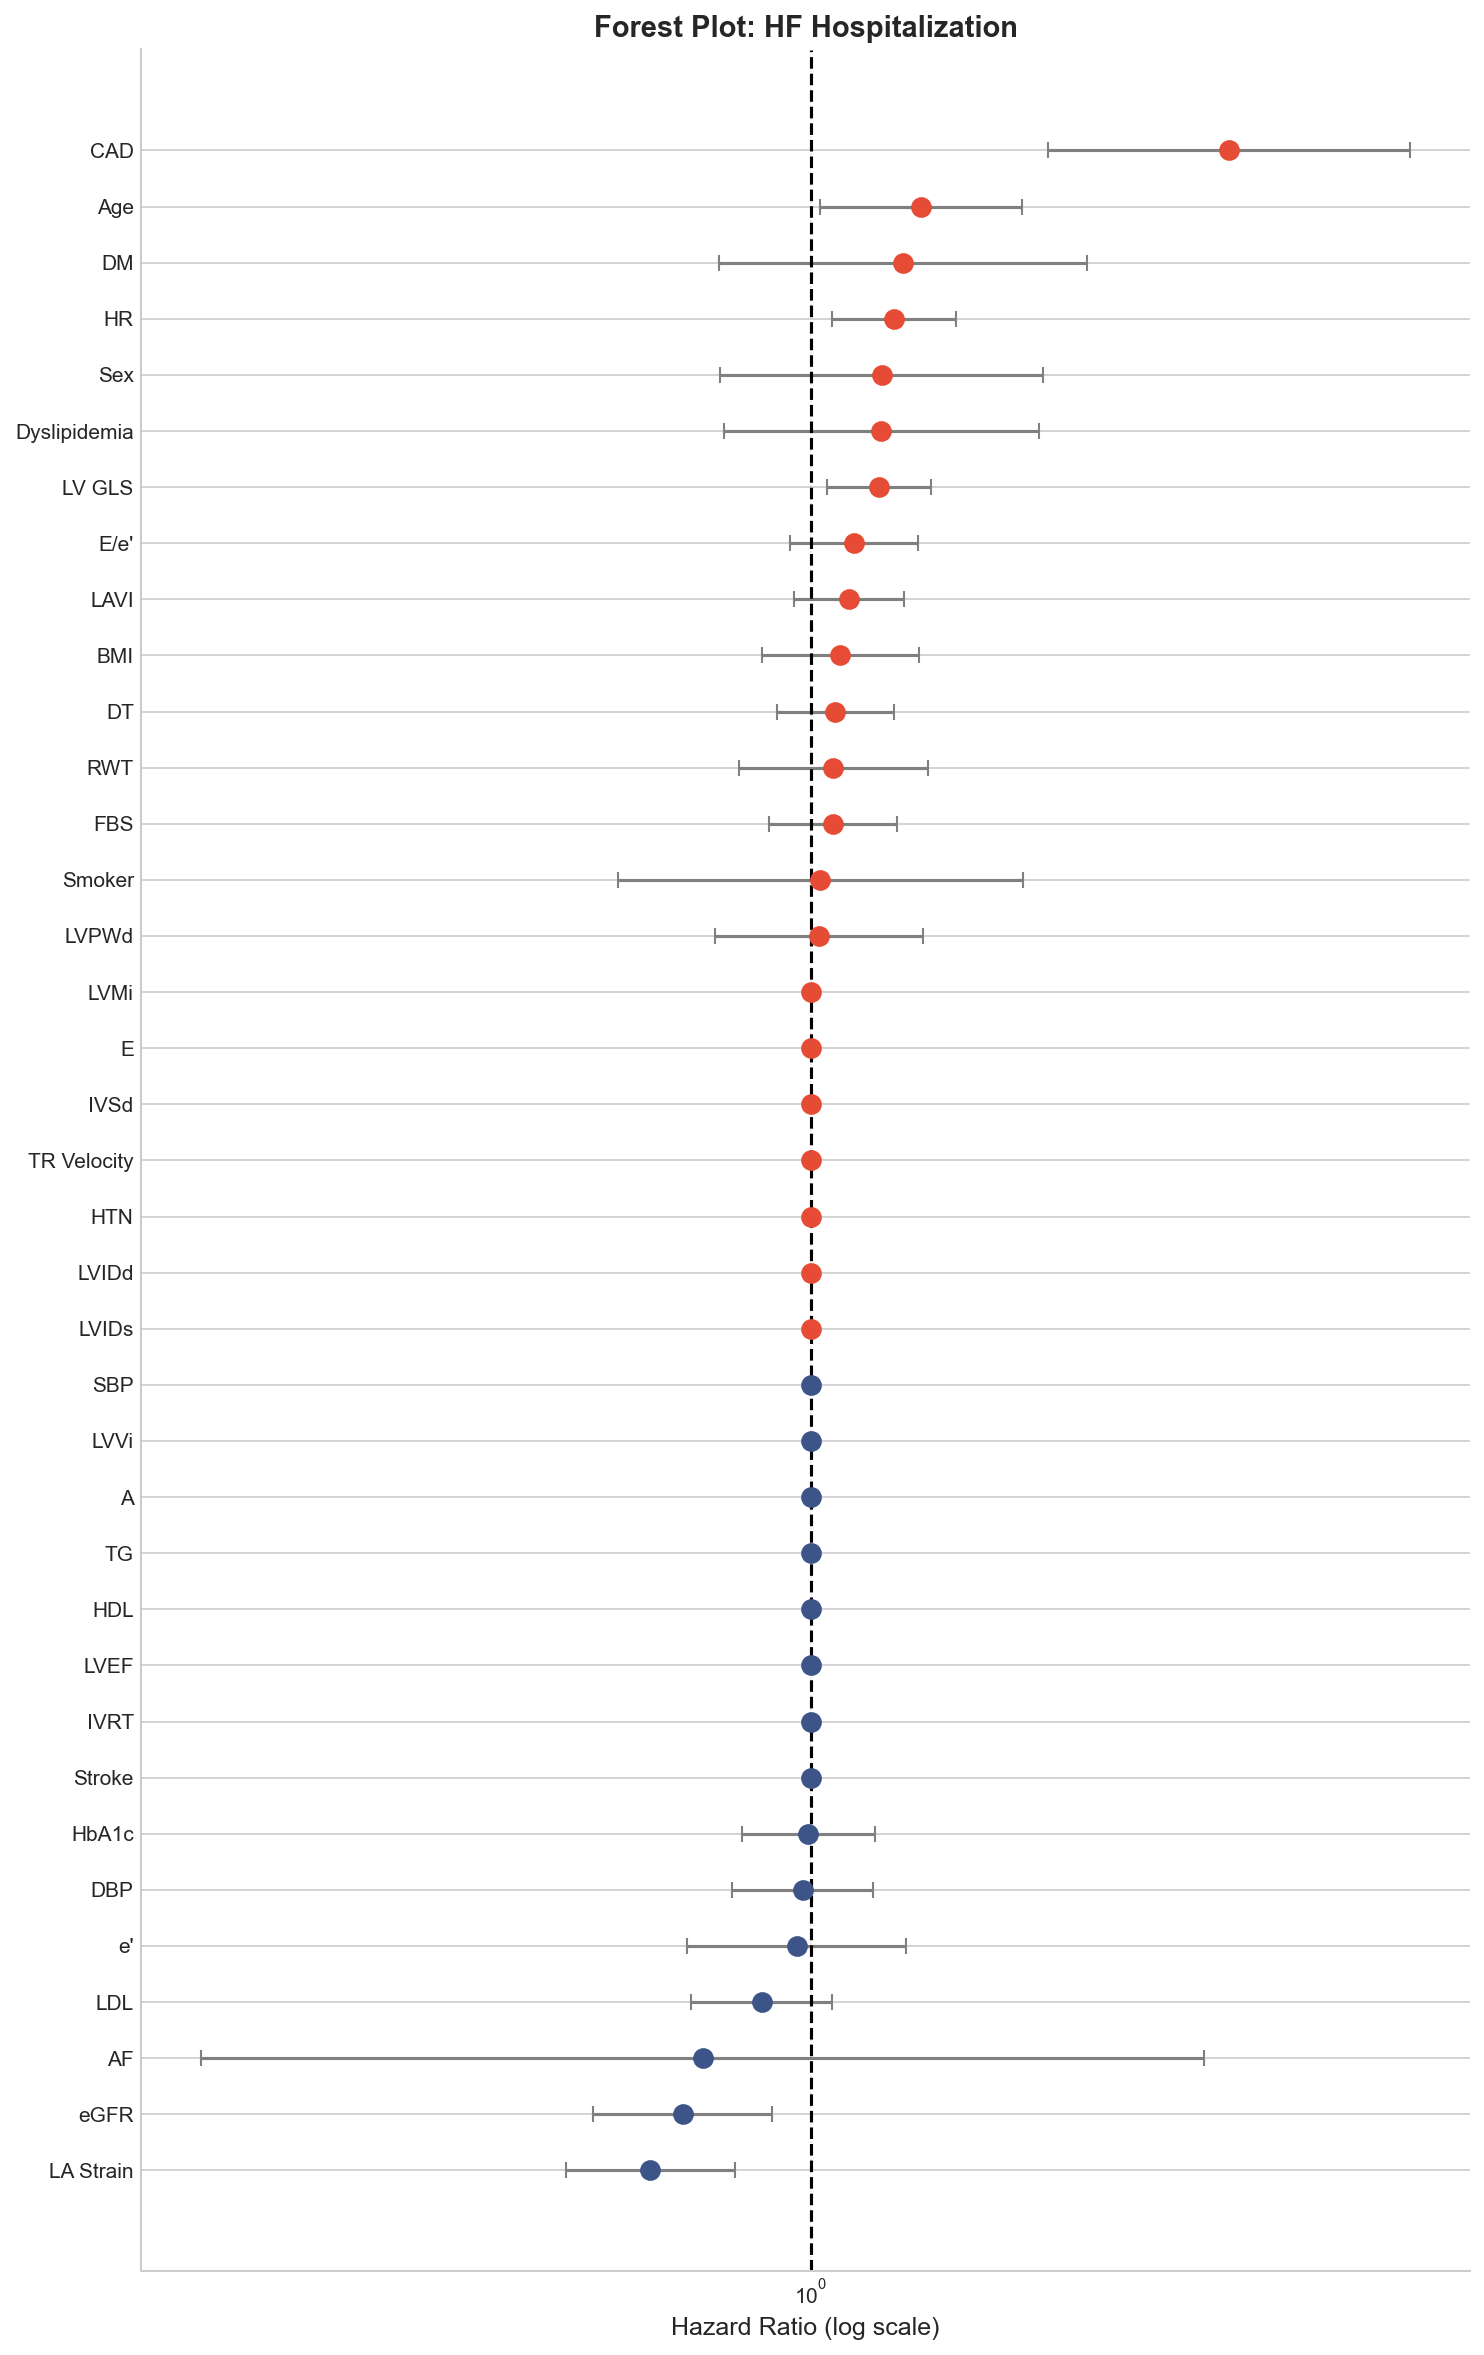

📁 Saved: forest_plot_hf.png

Calculating time-dependent ROC...


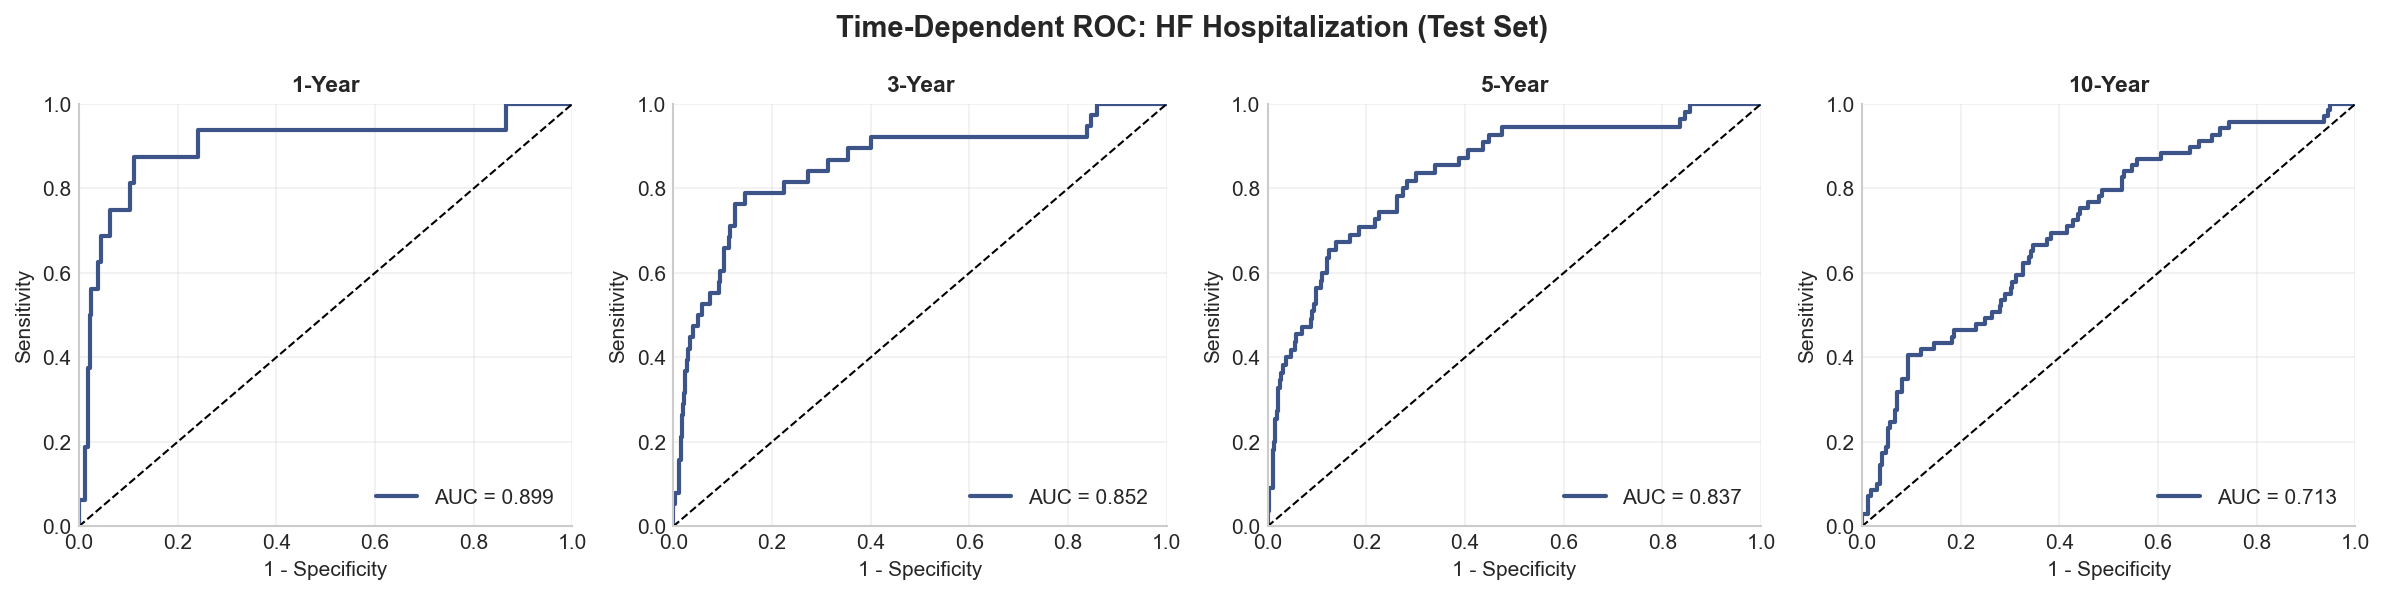

📁 Saved: roc_hf.png

Test Set AUCs:
  1-year: 0.899
  3-year: 0.852
  5-year: 0.837
  10-year: 0.713

MODELING: ALL-CAUSE MORTALITY

Sample Size Adequacy:
  Training samples: 3842
  Test samples: 1647
  Events: 68, Predictors: 37, EPV: 1.8
  ⚠️ EPV < 10: Regularization recommended

Searching for optimal penalizer (5-fold CV)...
  Penalizer: 0.00010 | C-index: 0.7570 ± 0.1803
  Penalizer: 0.00018 | C-index: 0.7532 ± 0.1854
  Penalizer: 0.00034 | C-index: 0.8771 ± 0.0469
  Penalizer: 0.00062 | C-index: 0.8806 ± 0.0452
  Penalizer: 0.00113 | C-index: 0.8845 ± 0.0428
  Penalizer: 0.00207 | C-index: 0.8832 ± 0.0385
  Penalizer: 0.00379 | C-index: 0.8925 ± 0.0339
  Penalizer: 0.00695 | C-index: 0.8616 ± 0.0728
  Penalizer: 0.01274 | C-index: 0.8882 ± 0.0331
  Penalizer: 0.02336 | C-index: 0.8710 ± 0.0347
  Penalizer: 0.04281 | C-index: 0.8693 ± 0.0334
  Penalizer: 0.07848 | C-index: 0.8785 ± 0.0357
  Penalizer: 0.14384 | C-index: 0.8777 ± 0.0354
  Penalizer: 0.26367 | C-index: 0.8777 ± 0.035

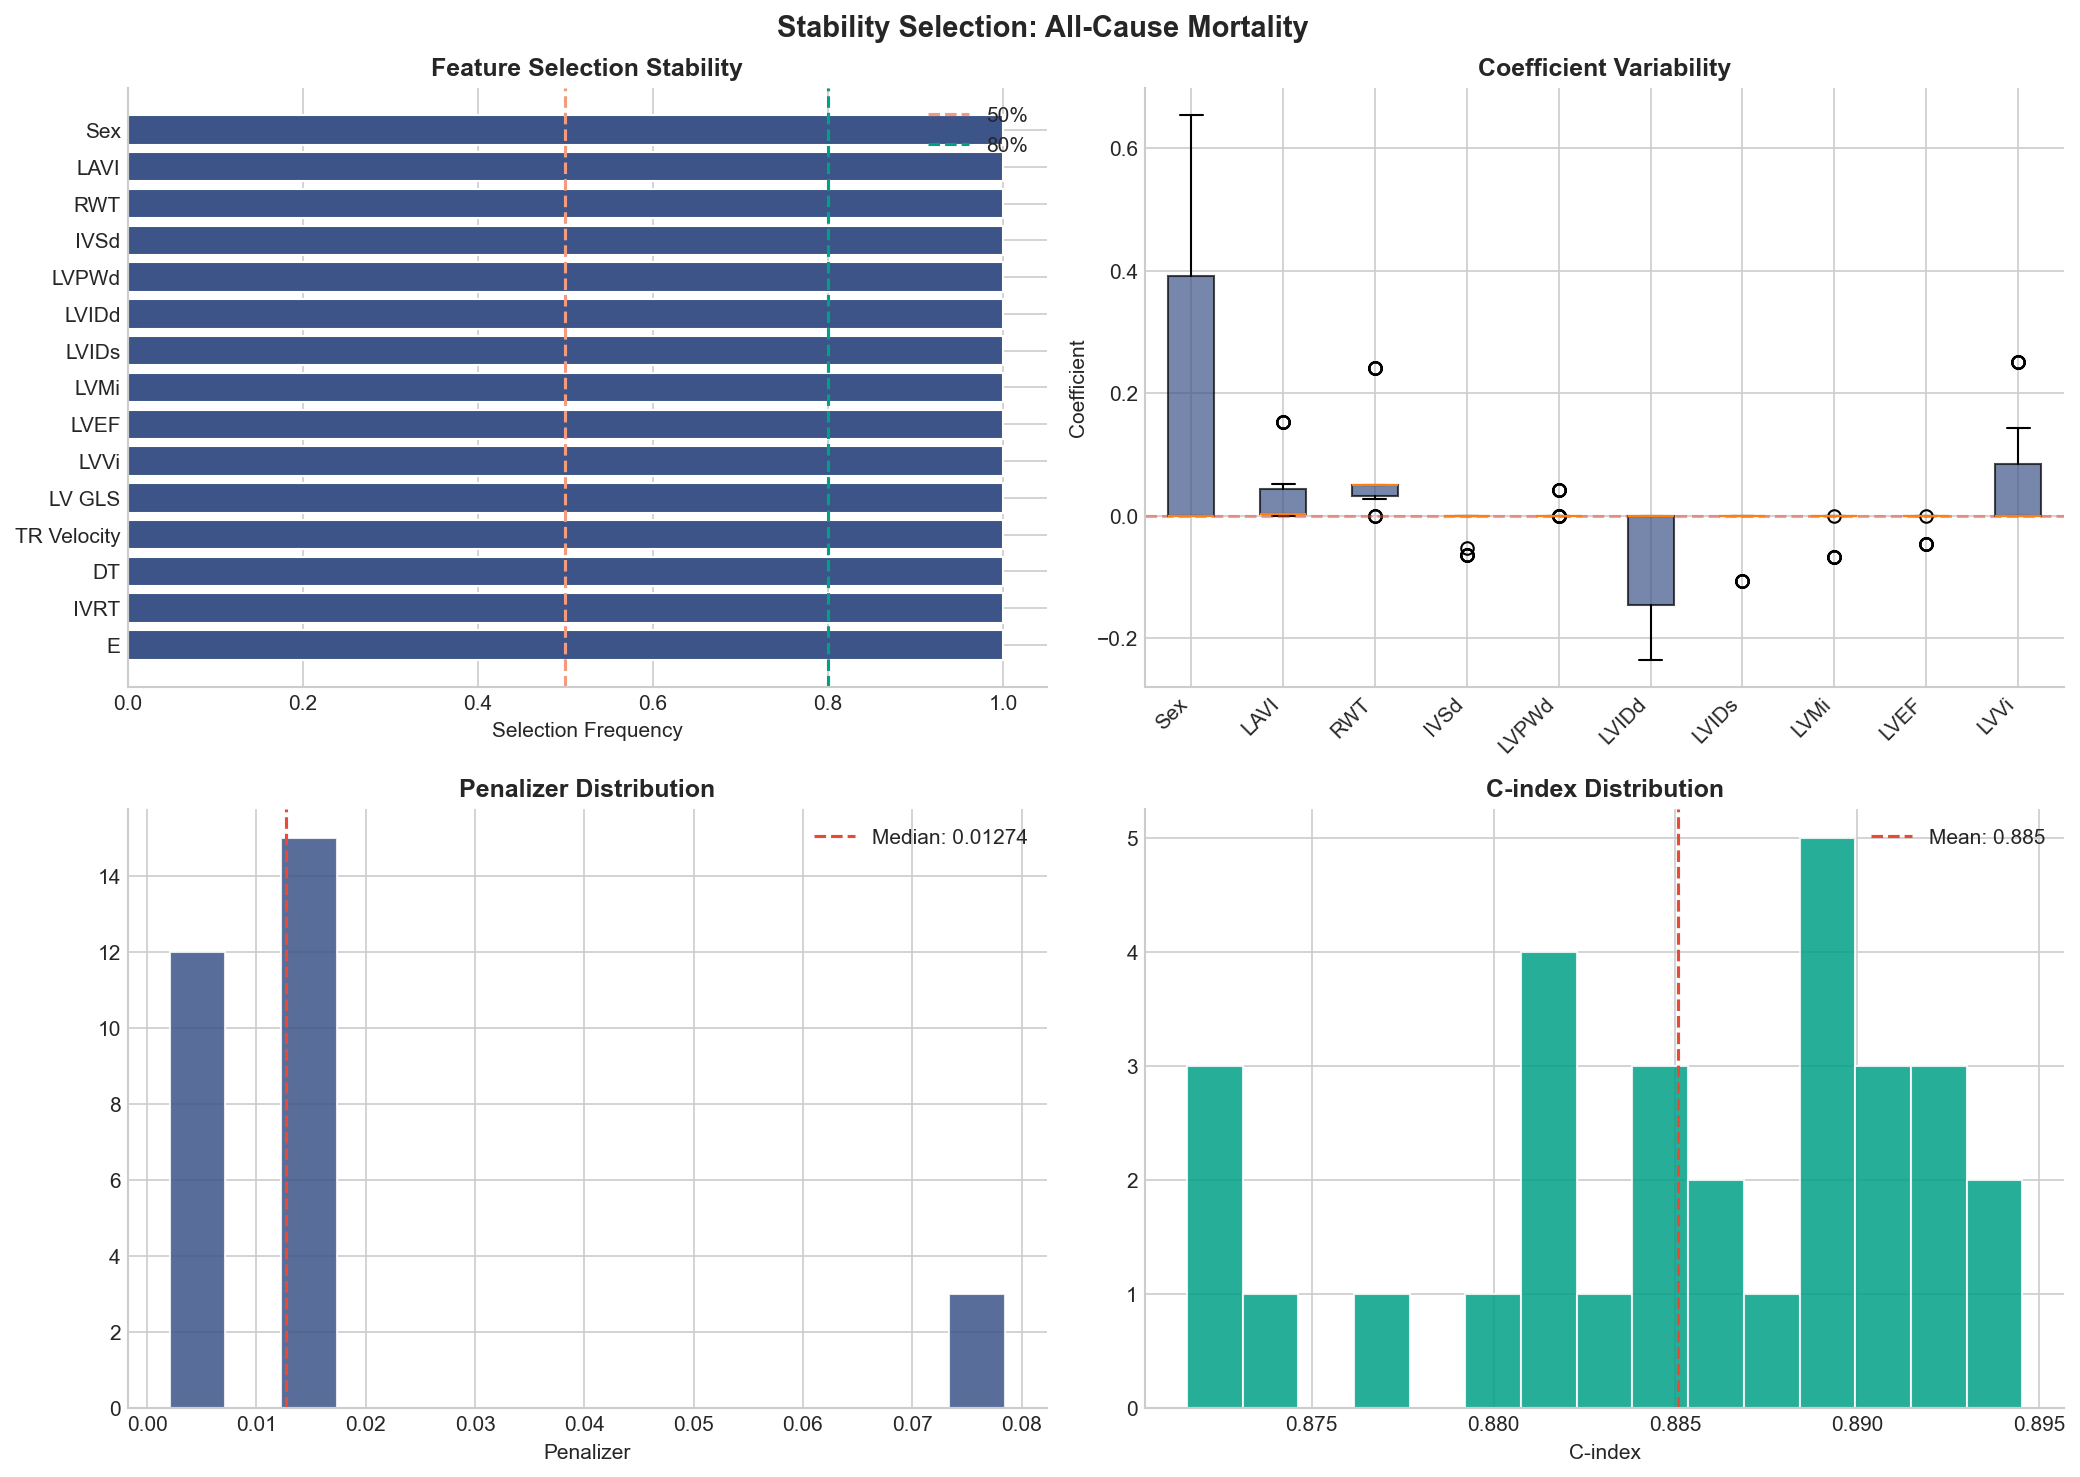

📁 Saved: stability_analysis_death.png

Risk Stratification (Tertiles)...

Event Rates by Risk Group (Test Set):
  Low: 2/596 (0.3%)
  Medium: 3/510 (0.6%)
  High: 23/541 (4.3%)

Generating KM curves by risk groups...
📁 Saved: km_risk_groups_death_train.png
📁 Saved: km_risk_groups_death_test.png

Generating forest plot...


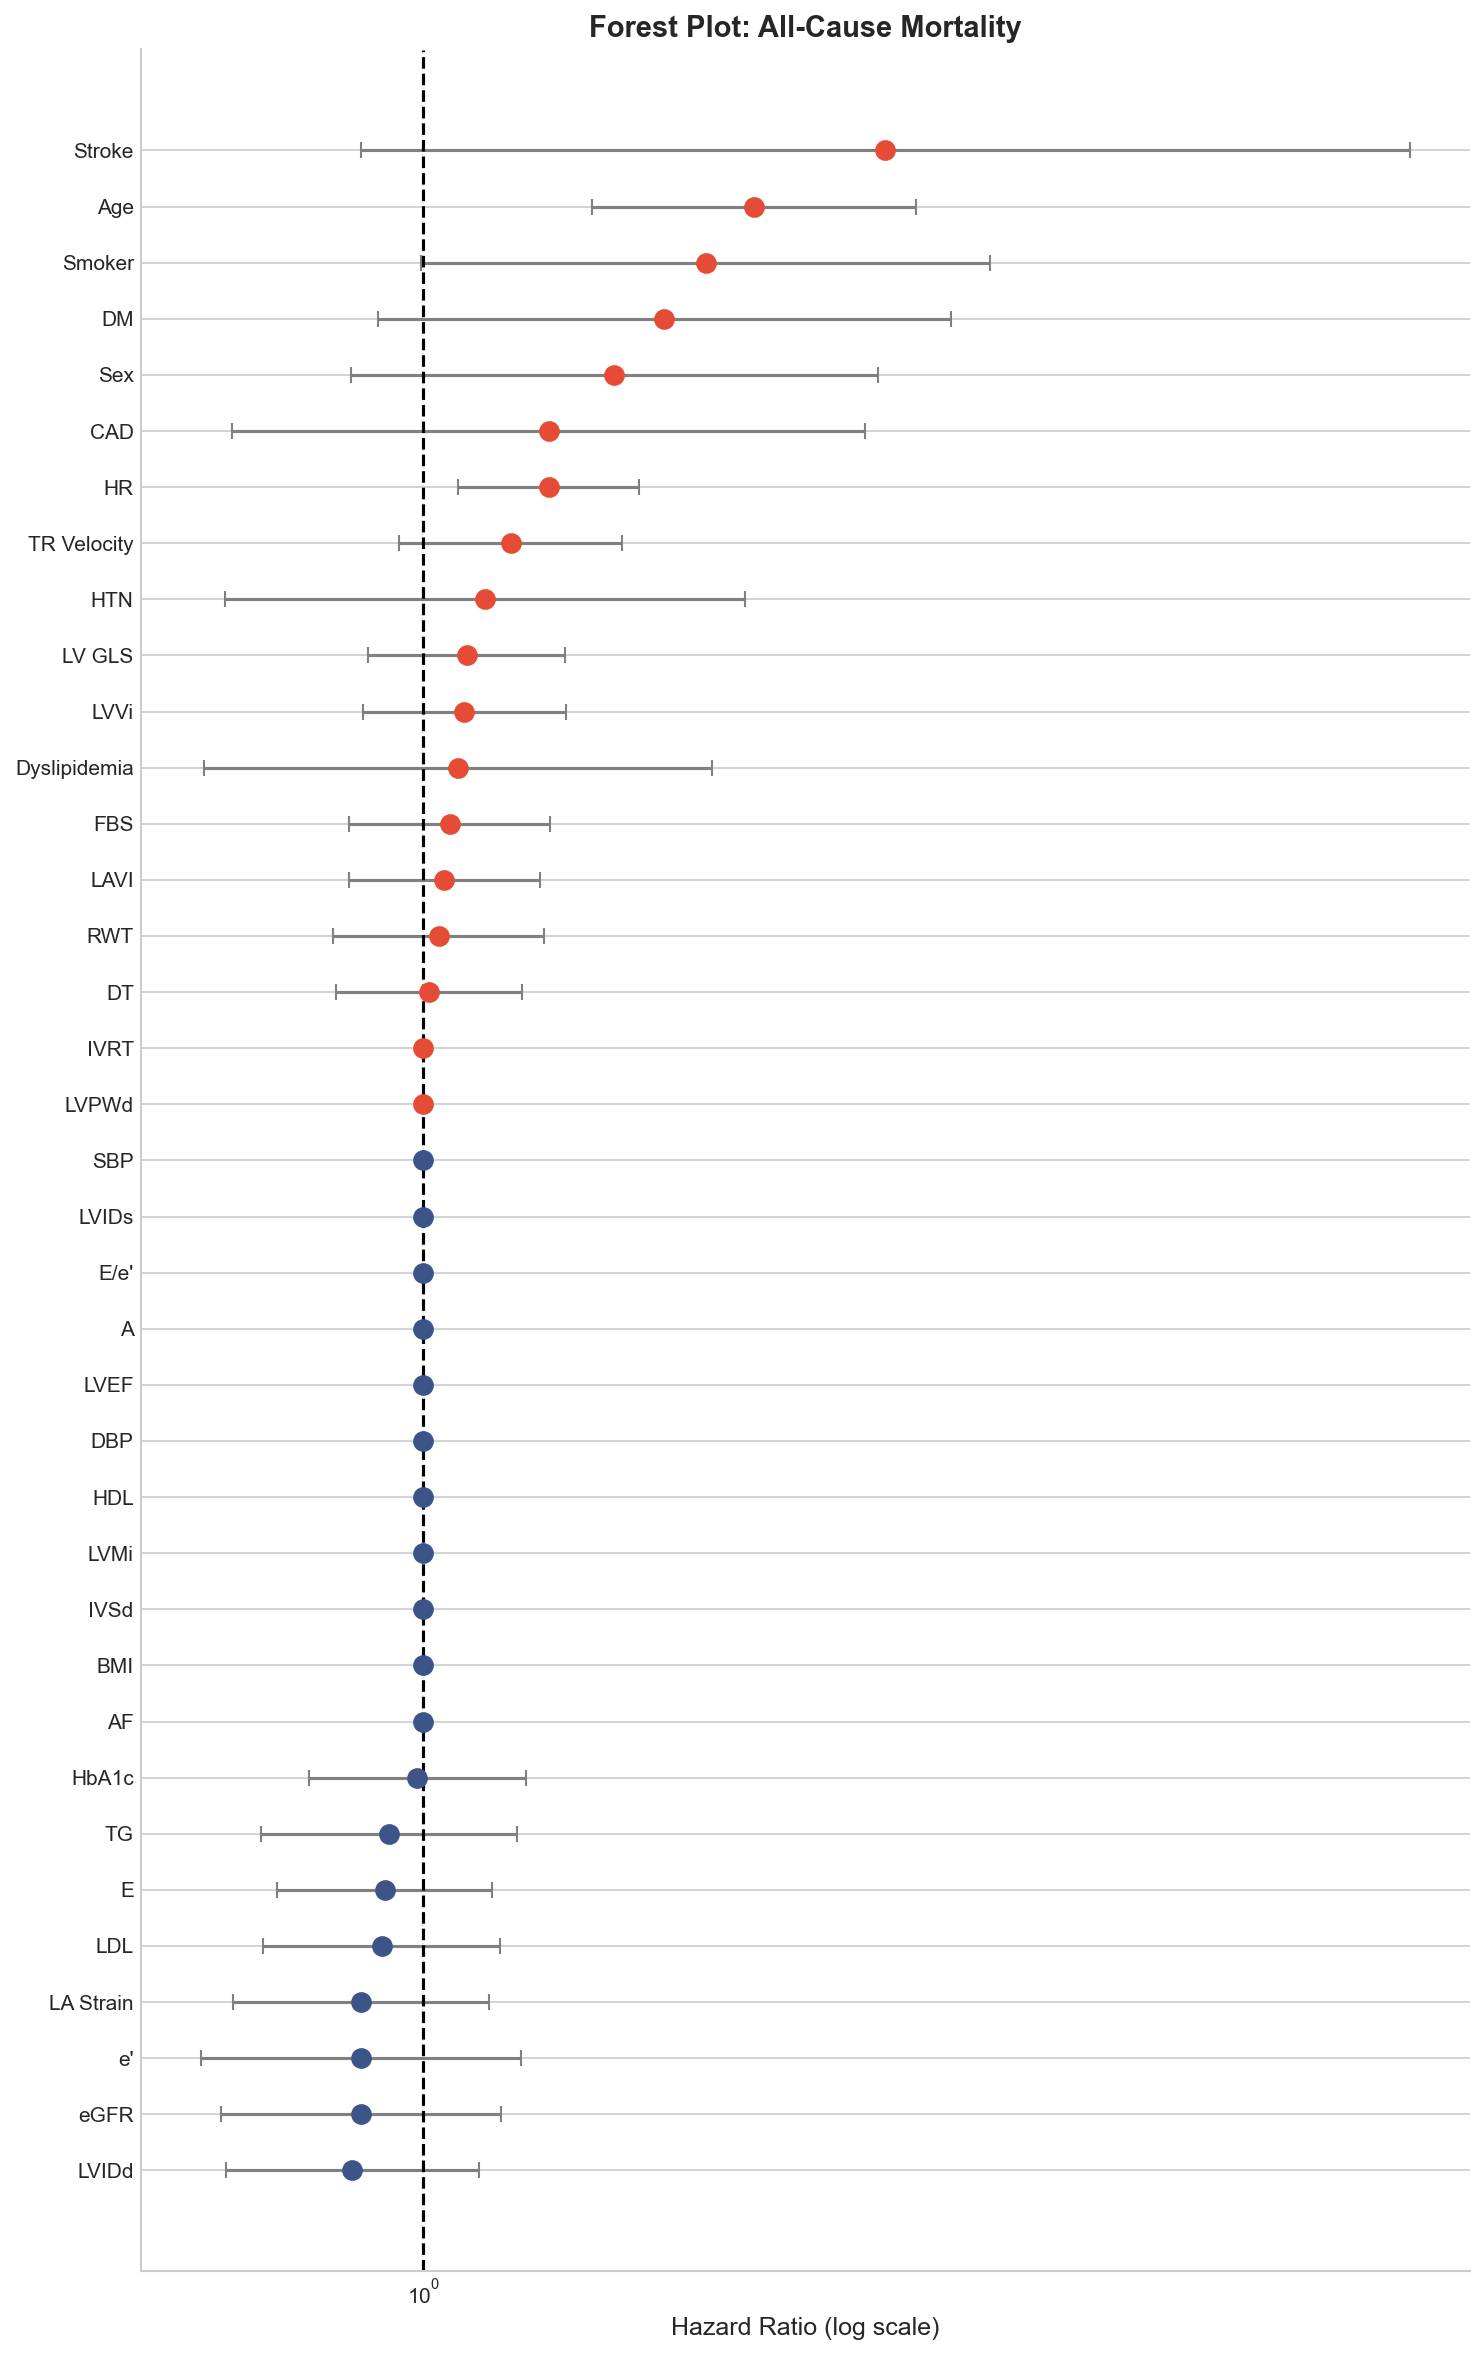

📁 Saved: forest_plot_death.png

Calculating time-dependent ROC...


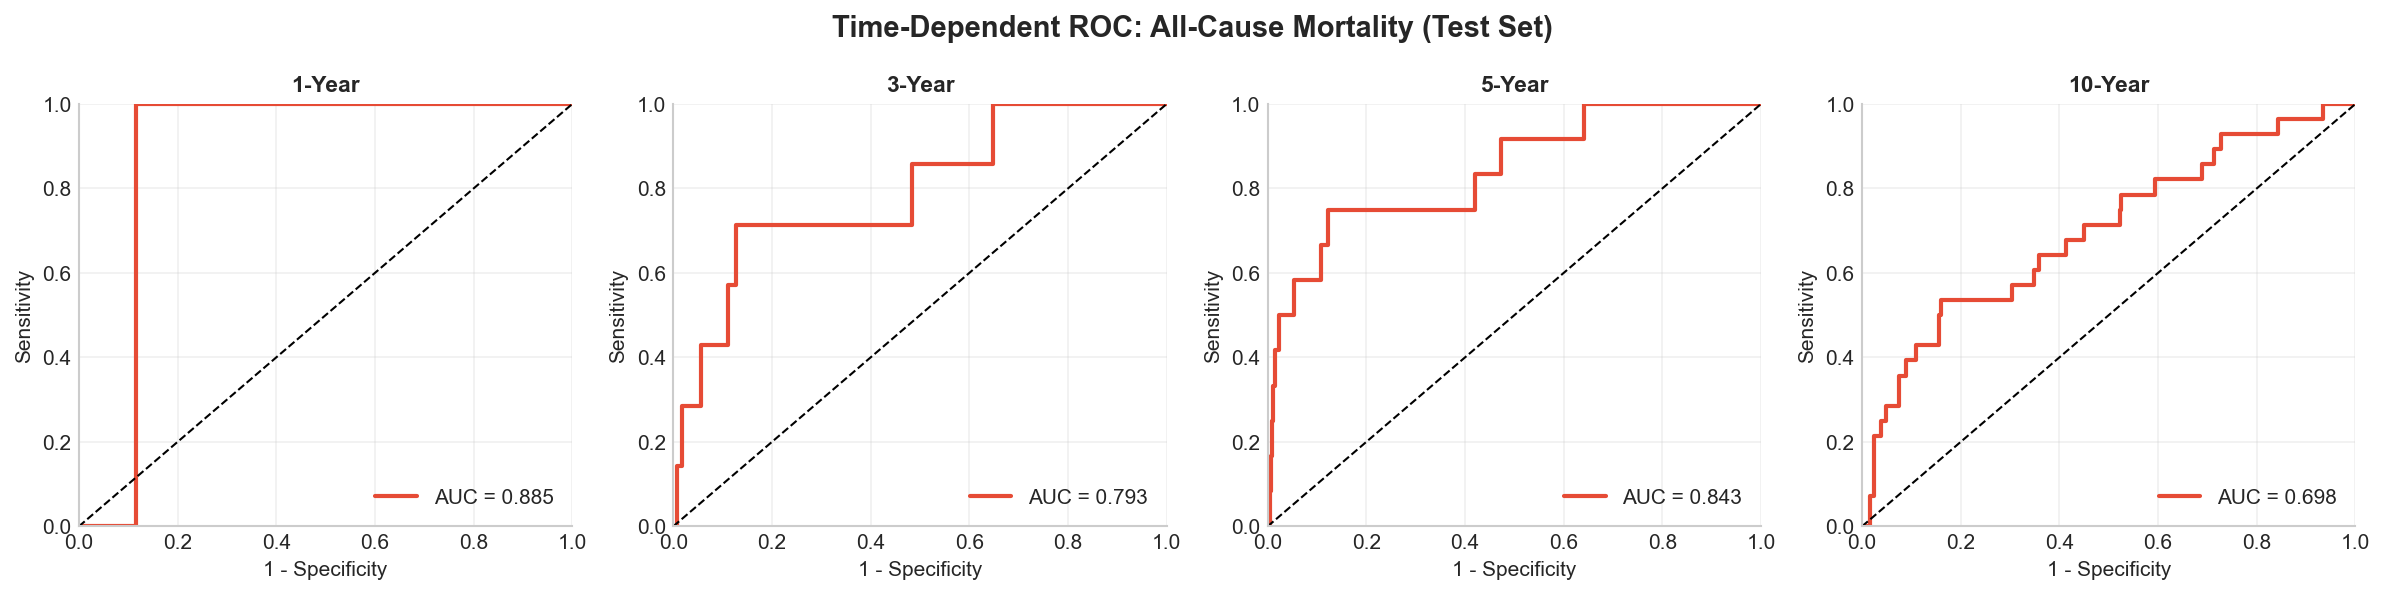

📁 Saved: roc_death.png

Test Set AUCs:
  1-year: 0.885
  3-year: 0.793
  5-year: 0.843
  10-year: 0.698

MODEL BUILDING COMPLETE


In [219]:
# =============================================
# PART 11: BUILD MODELS FOR BOTH OUTCOMES
# =============================================
print("\n" + "=" * 90)
print("PART 11: BUILD MODELS FOR BOTH OUTCOMES")
print("=" * 90)

# Store results for both outcomes
model_results = {}
penalizer_range = np.logspace(-4, 1, 20)

for outcome_key, outcome_info in OUTCOMES.items():
    print("\n" + "=" * 90)
    print(f"MODELING: {outcome_info['label'].upper()}")
    print("=" * 90)

    time_col = outcome_info['time_col']
    event_col = outcome_info['event_col']

    # ─────────────────────────────────────────────
    # PREPARE COX DATA
    # ─────────────────────────────────────────────
    cox_cols = predictors + [time_col, event_col]
    cox_train = train_scaled[cox_cols].dropna().copy()
    cox_test = test_scaled[cox_cols].dropna().copy()
    cox_train[event_col] = cox_train[event_col].astype(int)
    cox_test[event_col] = cox_test[event_col].astype(int)

    # ─────────────────────────────────────────────
    # SAMPLE SIZE ADEQUACY
    # ─────────────────────────────────────────────
    n_events = int(cox_train[event_col].sum())
    n_predictors = len(predictors)
    epv_ratio = n_events / n_predictors

    print(f"\nSample Size Adequacy:")
    print(f"  Training samples: {len(cox_train)}")
    print(f"  Test samples: {len(cox_test)}")
    print(f"  Events: {n_events}, Predictors: {n_predictors}, EPV: {epv_ratio:.1f}")
    print(f"  {'⚠️ EPV < 10: Regularization recommended' if epv_ratio < 10 else '✅ EPV ≥ 10: Adequate sample size'}")

    # ─────────────────────────────────────────────
    # CROSS-VALIDATION FOR PENALIZER
    # ─────────────────────────────────────────────
    print(f"\nSearching for optimal penalizer (5-fold CV)...")
    cv_results = cross_validate_cox(cox_train, time_col, event_col, penalizer_range,
                                    l1_ratio=0.5, n_folds=5, verbose=True)

    best_idx = cv_results['mean_c_index'].idxmax()
    best_penalizer = cv_results.loc[best_idx, 'penalizer']
    best_c_index = cv_results.loc[best_idx, 'mean_c_index']

    print(f"\n{'─' * 60}")
    print(f"BEST PENALIZER: {best_penalizer:.5f}")
    print(f"CV C-index: {best_c_index:.3f}")
    print(f"{'─' * 60}")

    # Save CV results
    cv_results[['mean_c_index', 'std_c_index']] = cv_results[['mean_c_index', 'std_c_index']].round(4)
    cv_results.to_excel(f'cv_penalizer_{outcome_key}.xlsx', index=False)
    print(f"📁 Saved: cv_penalizer_{outcome_key}.xlsx")

    # ─────────────────────────────────────────────
    # FIT FINAL MODEL
    # ─────────────────────────────────────────────
    print(f"\nFitting final Elastic Net Cox model...")
    cph = CoxPHFitter(penalizer=best_penalizer, l1_ratio=0.5)
    cph.fit(cox_train, duration_col=time_col, event_col=event_col)

    # Save summary
    summary_df = cph.summary.copy()
    summary_df.insert(0, 'Variable', summary_df.index)
    summary_df['Variable_Label'] = summary_df['Variable'].map(var_labels)
    summary_df[summary_df.select_dtypes(include=[np.number]).columns] = \
        summary_df.select_dtypes(include=[np.number]).round(3)
    summary_df.to_excel(f'cox_summary_{outcome_key}.xlsx', index=False)
    print(f"📁 Saved: cox_summary_{outcome_key}.xlsx")

    # ─────────────────────────────────────────────
    # MODEL EVALUATION
    # ─────────────────────────────────────────────
    train_pred = cph.predict_partial_hazard(cox_train)
    test_pred = cph.predict_partial_hazard(cox_test)
    train_c = concordance_index(cox_train[time_col], -train_pred, cox_train[event_col])
    test_c = concordance_index(cox_test[time_col], -test_pred, cox_test[event_col])
    gap = train_c - test_c

    print(f"\nC-index:")
    print(f"  Training: {train_c:.3f}")
    print(f"  Test:     {test_c:.3f}")
    print(f"  Gap:      {gap:.3f}")
    print(f"  {'⚠️ Gap > 0.05: Possible overfitting' if abs(gap) > 0.05 else '✅ Gap ≤ 0.05: Good generalization'}")

    # ─────────────────────────────────────────────
    # FEATURE IMPORTANCE & HAZARD RATIOS
    # ─────────────────────────────────────────────
    coefficients = cph.params_
    non_zero_coefs = coefficients[coefficients != 0].sort_values(key=abs, ascending=False)
    print(f"\nNon-Zero Coefficients: {len(non_zero_coefs)}/{len(coefficients)}")

    # Build HR dataframe
    hr_df = pd.DataFrame({
        'Variable': non_zero_coefs.index,
        'Variable_Label': [var_labels.get(v, v) for v in non_zero_coefs.index],
        'Coefficient': non_zero_coefs.values.round(3),
        'HR': np.exp(non_zero_coefs.values).round(3),
        'HR_Lower': np.exp(non_zero_coefs - 1.96 * cph.standard_errors_[non_zero_coefs.index]).round(3),
        'HR_Upper': np.exp(non_zero_coefs + 1.96 * cph.standard_errors_[non_zero_coefs.index]).round(3)
    })

    print("\nTop Hazard Ratios:")
    print(hr_df[['Variable_Label', 'HR', 'HR_Lower', 'HR_Upper']].head(10).to_string(index=False))

    hr_df.to_excel(f'hazard_ratios_{outcome_key}.xlsx', index=False)
    print(f"📁 Saved: hazard_ratios_{outcome_key}.xlsx")

    # ─────────────────────────────────────────────
    # STABILITY SELECTION
    # ─────────────────────────────────────────────
    print(f"\nRunning stability selection (30 iterations)...")
    stability_results, all_penalizers, all_c_indices, coef_df = stability_selection(
        cox_train, time_col, event_col, penalizer_range, n_iterations=30, verbose=True
    )

    stability_results['Variable_Label'] = stability_results['Variable'].map(var_labels)
    stability_results = stability_results.sort_values('Selection_Frequency', ascending=False)

    # Round stability results
    stability_results['Selection_Frequency'] = stability_results['Selection_Frequency'].round(3)
    stability_results['Mean_Coefficient'] = stability_results['Mean_Coefficient'].round(3)
    stability_results['Std_Coefficient'] = stability_results['Std_Coefficient'].round(3)
    stability_results['Mean_HR'] = stability_results['Mean_HR'].round(3)

    print(f"\nStable Features (>50% selection):")
    stable = stability_results[stability_results['Selection_Frequency'] > 0.5]
    print(stable[['Variable_Label', 'Selection_Frequency', 'Mean_HR']].to_string(index=False))

    stability_results.to_excel(f'stability_{outcome_key}.xlsx', index=False)
    print(f"📁 Saved: stability_{outcome_key}.xlsx")

    # Stability visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Panel 1: Selection frequency
    ax1 = axes[0, 0]
    top_feat = stability_results.head(15)
    ax1.barh(range(len(top_feat)), top_feat['Selection_Frequency'], color=COLORS['blue'])
    ax1.set_yticks(range(len(top_feat)))
    ax1.set_yticklabels(top_feat['Variable_Label'].fillna(top_feat['Variable']))
    ax1.set_xlabel('Selection Frequency')
    ax1.set_title('Feature Selection Stability', fontweight='bold')
    ax1.axvline(x=0.5, color=COLORS['orange'], linestyle='--', label='50%')
    ax1.axvline(x=0.8, color=COLORS['teal'], linestyle='--', label='80%')
    ax1.legend()
    ax1.invert_yaxis()

    # Panel 2: Coefficient variability
    ax2 = axes[0, 1]
    stable_vars = stability_results[stability_results['Selection_Frequency'] > 0.5]['Variable'].head(10)
    if len(stable_vars) > 0:
        coef_data = [coef_df[var].values for var in stable_vars]
        bp = ax2.boxplot(coef_data, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor(COLORS['blue'])
            patch.set_alpha(0.7)
        ax2.set_xticklabels([var_labels.get(v, v)[:10] for v in stable_vars], rotation=45, ha='right')
        ax2.set_ylabel('Coefficient')
        ax2.set_title('Coefficient Variability', fontweight='bold')
        ax2.axhline(y=0, color=COLORS['red'], linestyle='--', alpha=0.5)

    # Panel 3: Penalizer distribution
    ax3 = axes[1, 0]
    ax3.hist(all_penalizers, bins=15, edgecolor='white', alpha=0.85, color=COLORS['blue'])
    ax3.axvline(np.median(all_penalizers), color=COLORS['red'], linestyle='--',
                label=f'Median: {np.median(all_penalizers):.5f}')
    ax3.set_xlabel('Penalizer')
    ax3.set_title('Penalizer Distribution', fontweight='bold')
    ax3.legend()

    # Panel 4: C-index distribution
    ax4 = axes[1, 1]
    ax4.hist(all_c_indices, bins=15, edgecolor='white', alpha=0.85, color=COLORS['teal'])
    ax4.axvline(np.mean(all_c_indices), color=COLORS['red'], linestyle='--',
                label=f'Mean: {np.mean(all_c_indices):.3f}')
    ax4.set_xlabel('C-index')
    ax4.set_title('C-index Distribution', fontweight='bold')
    ax4.legend()

    plt.suptitle(f'Stability Selection: {outcome_info["label"]}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'stability_analysis_{outcome_key}.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"📁 Saved: stability_analysis_{outcome_key}.png")

    # ─────────────────────────────────────────────
    # RISK STRATIFICATION
    # ─────────────────────────────────────────────
    print(f"\nRisk Stratification (Tertiles)...")
    cox_train['risk_score'] = cph.predict_partial_hazard(cox_train).values
    cox_test['risk_score'] = cph.predict_partial_hazard(cox_test).values

    risk_tertiles = np.percentile(cox_train['risk_score'], [33.33, 66.67])

    def assign_risk(score):
        if score < risk_tertiles[0]:
            return 'Low'
        elif score < risk_tertiles[1]:
            return 'Medium'
        return 'High'

    cox_train['risk_group'] = cox_train['risk_score'].apply(assign_risk)
    cox_test['risk_group'] = cox_test['risk_score'].apply(assign_risk)

    print(f"\nEvent Rates by Risk Group (Test Set):")
    for risk in ['Low', 'Medium', 'High']:
        subset = cox_test[cox_test['risk_group'] == risk]
        n_events_risk = int(subset[event_col].sum())
        n_total = len(subset)
        rate = n_events_risk / n_total * 100 if n_total > 0 else 0
        print(f"  {risk}: {n_events_risk}/{n_total} ({rate:.1f}%)")

    # KM by risk groups
    print(f"\nGenerating KM curves by risk groups...")
    for dataset, name in [(cox_train, 'train'), (cox_test, 'test')]:
        plot_km_by_risk_groups(
            dataset, time_col, event_col,
            title_suffix=f"({name.capitalize()})",
            out_path=f'km_risk_groups_{outcome_key}_{name}.png'
        )

    # ─────────────────────────────────────────────
    # FOREST PLOT
    # ─────────────────────────────────────────────
    if len(non_zero_coefs) > 0:
        print(f"\nGenerating forest plot...")
        forest_df = cph.summary.loc[non_zero_coefs.index].copy()
        forest_df['Variable_Label'] = [var_labels.get(v, v) for v in forest_df.index]
        forest_df = forest_df.rename(columns={
            'exp(coef)': 'HR',
            'exp(coef) lower 95%': 'CI_lower',
            'exp(coef) upper 95%': 'CI_upper'
        })
        forest_df = forest_df.sort_values('HR', ascending=False)

        y = np.arange(len(forest_df))
        x = forest_df['HR'].values
        xerr_lower = x - forest_df['CI_lower'].values
        xerr_upper = forest_df['CI_upper'].values - x
        colors_hr = [COLORS['red'] if h > 1 else COLORS['blue'] for h in x]

        fig, ax = plt.subplots(figsize=(10, max(6, 0.4 * len(forest_df) + 1)))

        ax.errorbar(x, y, xerr=[xerr_lower, xerr_upper], fmt='none', capsize=4,
                    linewidth=1.5, color='gray')
        for i, (xi, ci) in enumerate(zip(x, colors_hr)):
            ax.scatter([xi], [y[i]], color=ci, s=80, zorder=5)

        ax.axvline(1.0, color='black', linestyle='--', linewidth=1.5)
        ax.set_xscale('log')
        ax.set_yticks(y)
        ax.set_yticklabels(forest_df['Variable_Label'])
        ax.invert_yaxis()
        ax.set_xlabel('Hazard Ratio (log scale)', fontsize=12)
        ax.set_title(f'Forest Plot: {outcome_info["label"]}', fontsize=14, fontweight='bold')
        ax.grid(True, axis='x', linestyle=':', alpha=0.5)

        plt.tight_layout()
        plt.savefig(f'forest_plot_{outcome_key}.png', dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
        print(f"📁 Saved: forest_plot_{outcome_key}.png")

    # ─────────────────────────────────────────────
    # TIME-DEPENDENT ROC
    # ─────────────────────────────────────────────
    print(f"\nCalculating time-dependent ROC...")
    time_points_roc = [1, 3, 5, 10]
    test_aucs = {}

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    for idx, t in enumerate(time_points_roc):
        t_days = int(t * 365.25)
        auc_val, fpr, tpr = calc_auc_at_time(cox_test, time_col, event_col, t_days)
        test_aucs[t] = auc_val

        if fpr is not None:
            axes[idx].plot(fpr, tpr, lw=2, color=outcome_info['color'], label=f'AUC = {auc_val:.3f}')
            axes[idx].plot([0, 1], [0, 1], 'k--', lw=1)
        axes[idx].set_xlabel('1 - Specificity', fontsize=10)
        axes[idx].set_ylabel('Sensitivity', fontsize=10)
        axes[idx].set_title(f'{t}-Year', fontsize=11, fontweight='bold')
        axes[idx].legend(loc='lower right')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].set_xlim([0, 1])
        axes[idx].set_ylim([0, 1])

    plt.suptitle(f'Time-Dependent ROC: {outcome_info["label"]} (Test Set)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'roc_{outcome_key}.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"📁 Saved: roc_{outcome_key}.png")

    print(f"\nTest Set AUCs:")
    for t, auc_val in test_aucs.items():
        print(f"  {t}-year: {auc_val:.3f}" if pd.notna(auc_val) else f"  {t}-year: N/A")

    # ─────────────────────────────────────────────
    # STORE RESULTS
    # ─────────────────────────────────────────────
    model_results[outcome_key] = {
        'model': cph,
        'best_penalizer': best_penalizer,
        'cv_c_index': best_c_index,
        'train_c_index': train_c,
        'test_c_index': test_c,
        'n_events': n_events,
        'n_predictors': n_predictors,
        'epv_ratio': epv_ratio,
        'cox_train': cox_train,
        'cox_test': cox_test,
        'non_zero_coefs': non_zero_coefs,
        'hr_df': hr_df,
        'stability_results': stability_results,
        'test_aucs': test_aucs
    }

print("\n" + "=" * 90)
print("MODEL BUILDING COMPLETE")
print("=" * 90)


PART 12: PROPORTIONAL HAZARDS ASSUMPTION TESTING

────────────────────────────────────────────────────────────
Testing: HF Hospitalization
────────────────────────────────────────────────────────────
  Sample size: 3842
  Events: 160
  Non-zero coefficients: 37/37

Testing PH assumption for HF Hospitalization...

PH Test Results (Schoenfeld residuals):
  Variables tested: 37
  PH violations (p < 0.05): 2

⚠️ Variables violating PH assumption:
   • FBS: p = 0.0195
   • Dyslipidemia: p = 0.0471
📁 Saved: ph_test_hf.xlsx

  Plotting Schoenfeld residuals for 37 variables...


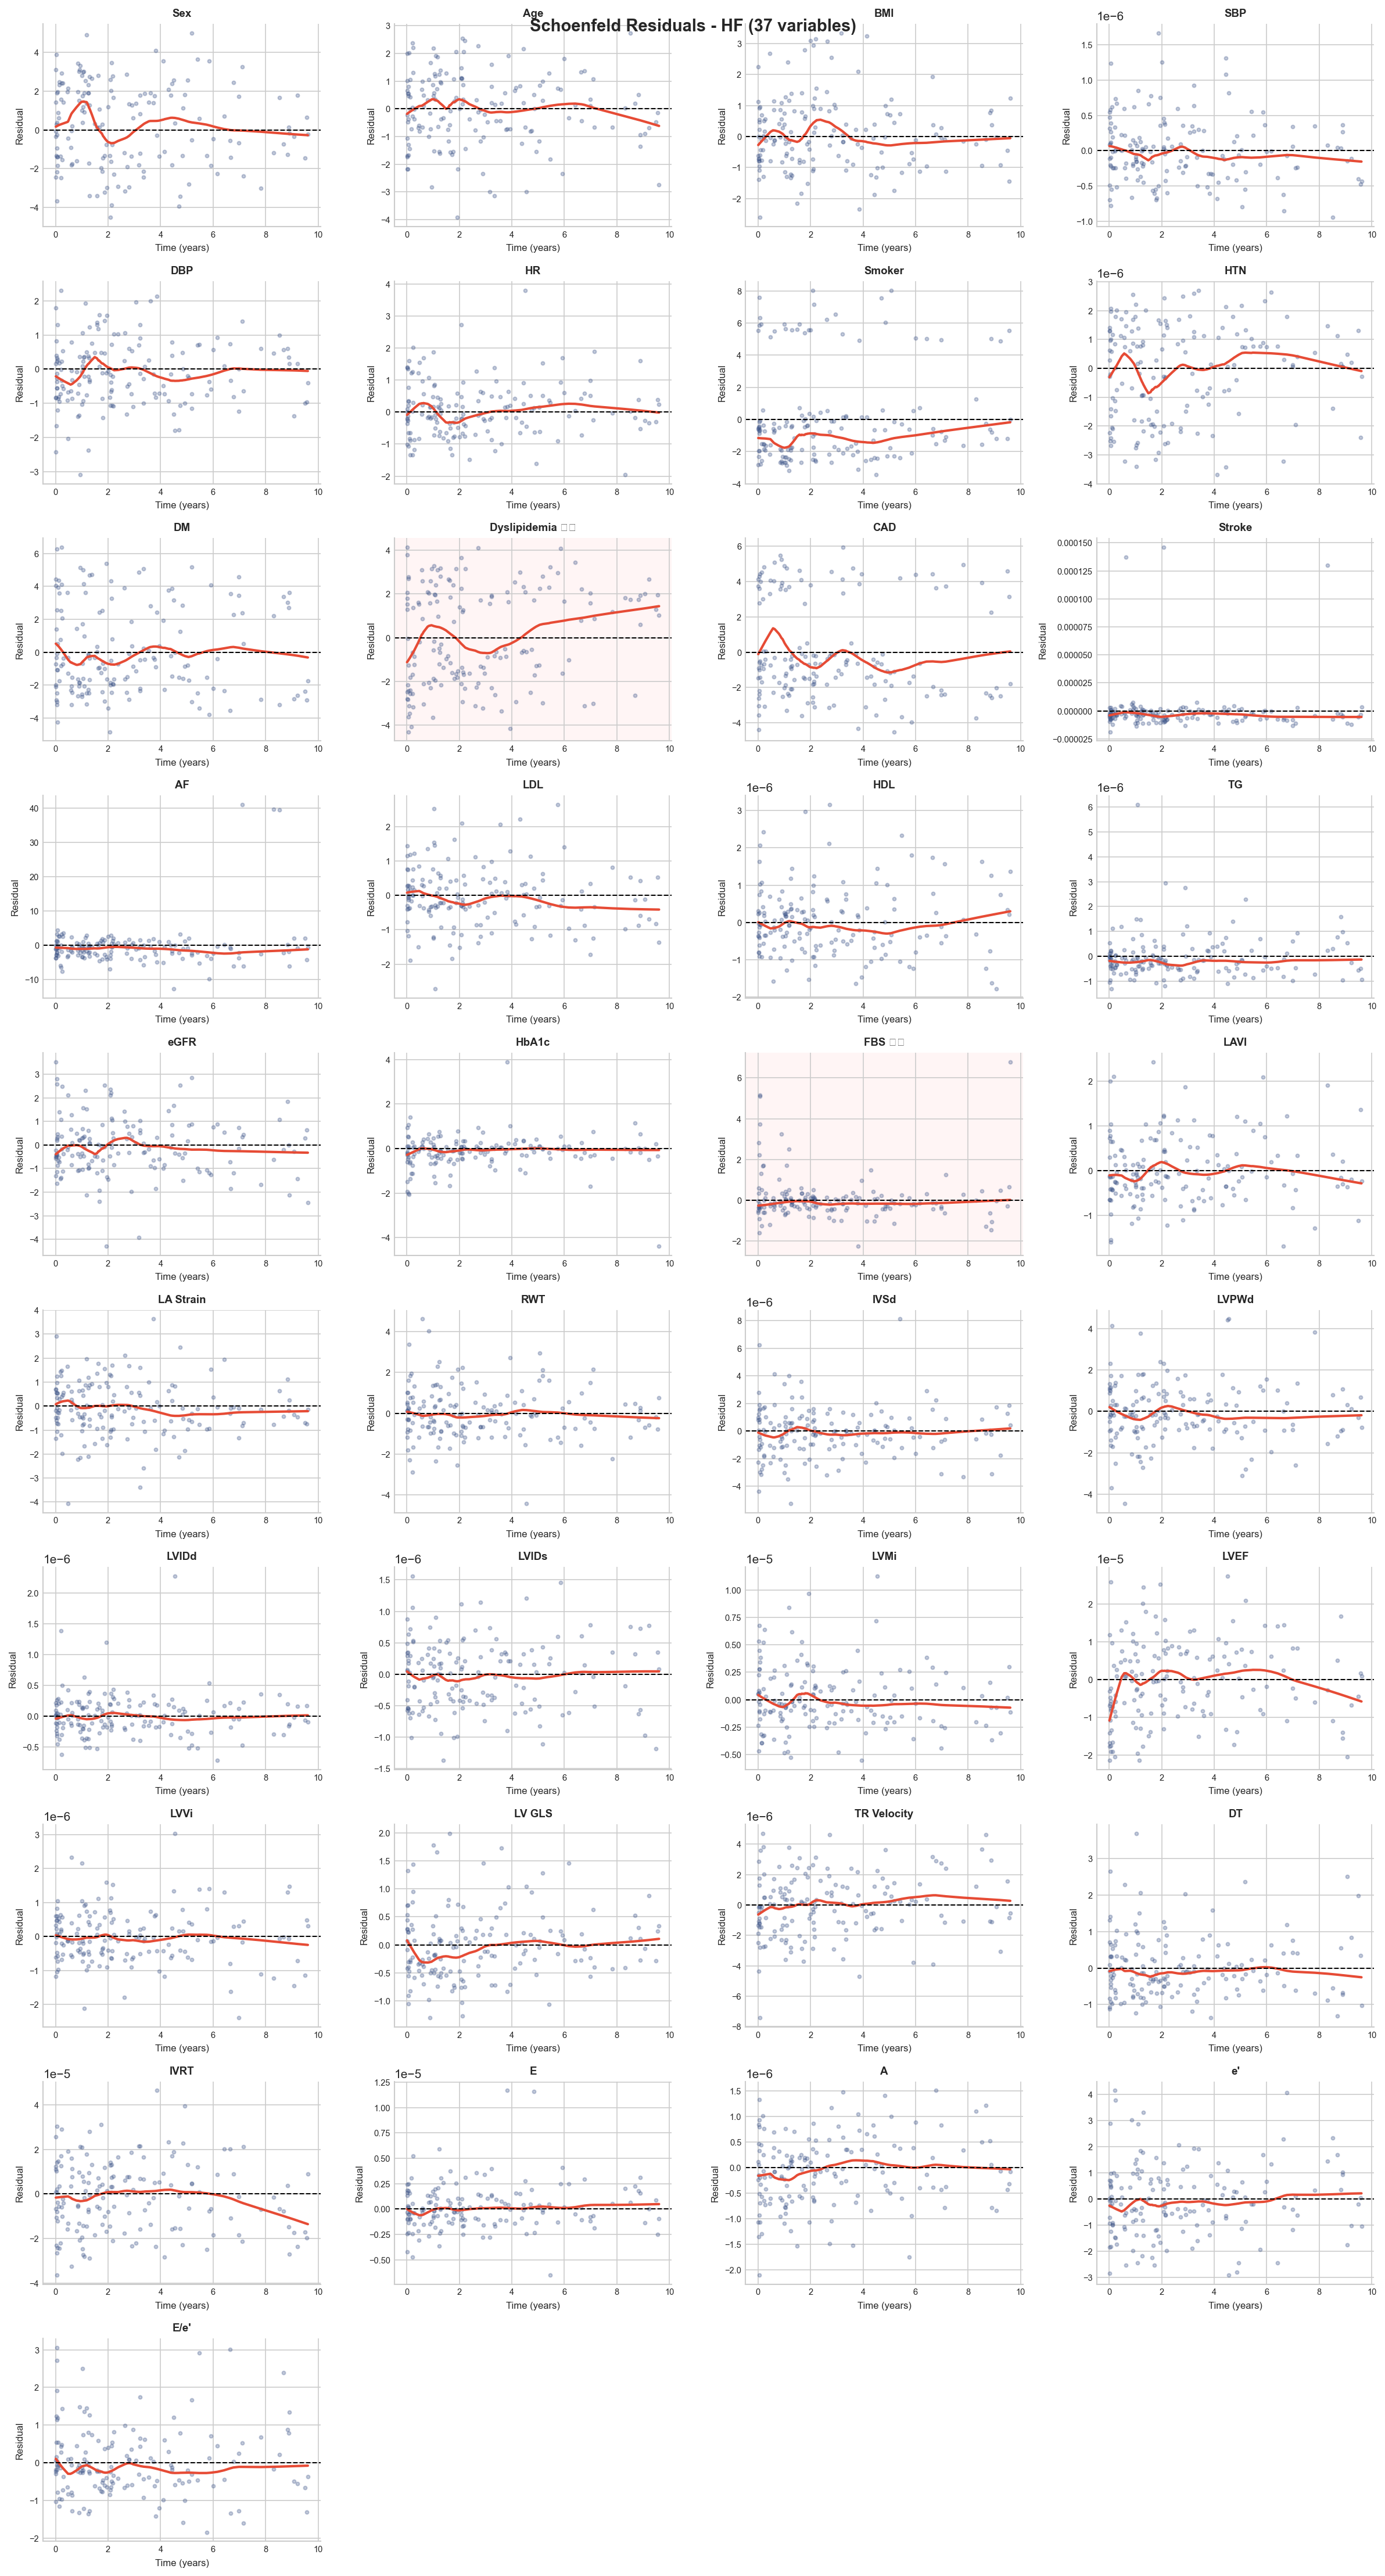

📁 Saved: schoenfeld_residuals_hf_all.png

────────────────────────────────────────────────────────────
Testing: All-Cause Mortality
────────────────────────────────────────────────────────────
  Sample size: 3842
  Events: 68
  Non-zero coefficients: 37/37

Testing PH assumption for All-Cause Mortality...

PH Test Results (Schoenfeld residuals):
  Variables tested: 37
  PH violations (p < 0.05): 3

⚠️ Variables violating PH assumption:
   • HbA1c: p = 0.0257
   • DM: p = 0.0194
   • RWT: p = 0.0346
📁 Saved: ph_test_death.xlsx

  Plotting Schoenfeld residuals for 37 variables...


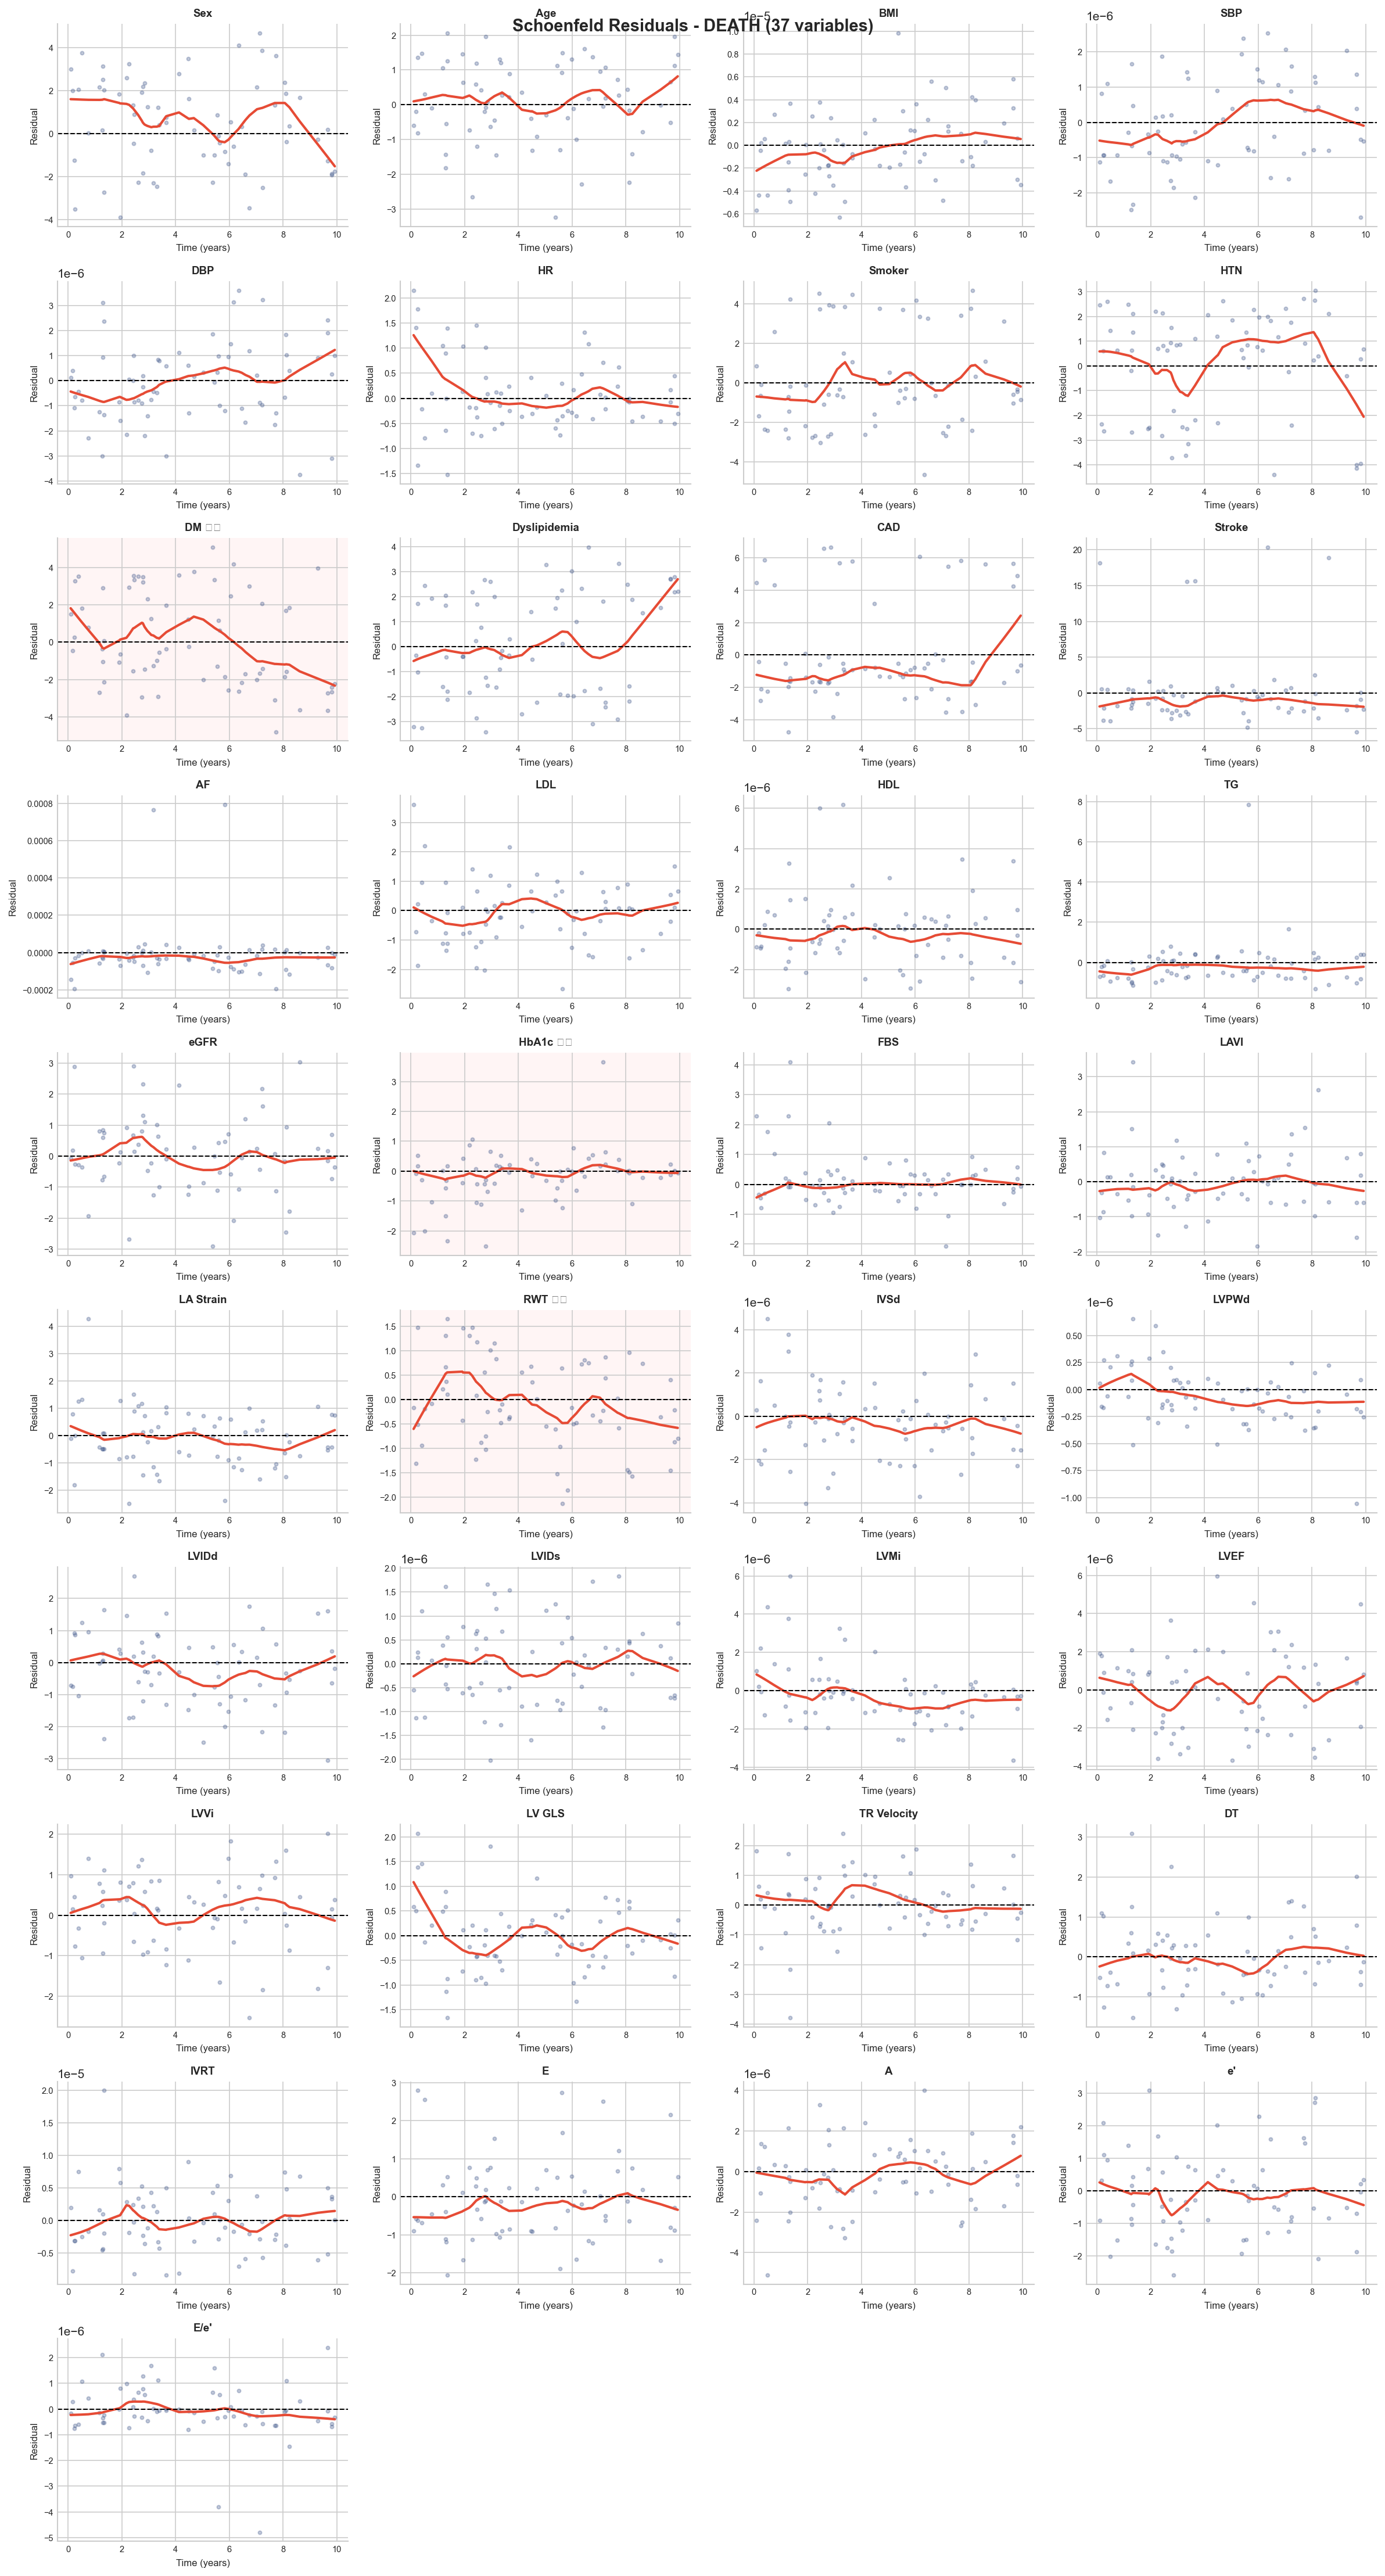

📁 Saved: schoenfeld_residuals_death_all.png


In [227]:
# =============================================
# PART 12: PROPORTIONAL HAZARDS ASSUMPTION
# =============================================
print("\n" + "=" * 90)
print("PART 12: PROPORTIONAL HAZARDS ASSUMPTION TESTING")
print("=" * 90)

from lifelines.statistics import proportional_hazard_test
import warnings

warnings.filterwarnings('ignore')


def test_proportional_hazards(cph, data, time_col, event_col, outcome_label):
    """
    Test proportional hazards assumption using Schoenfeld residuals.
    """
    print(f"\nTesting PH assumption for {outcome_label}...")

    ph_test = proportional_hazard_test(cph, data, time_transform='rank')
    ph_results = ph_test.summary.copy()
    ph_results['Significant'] = ph_results['p'] < 0.05

    n_violations = ph_results['Significant'].sum()
    n_total = len(ph_results)

    print(f"\nPH Test Results (Schoenfeld residuals):")
    print(f"  Variables tested: {n_total}")
    print(f"  PH violations (p < 0.05): {n_violations}")

    if n_violations > 0:
        print(f"\n⚠️ Variables violating PH assumption:")
        violations = ph_results[ph_results['Significant']]
        for var in violations.index:
            p_val = violations.loc[var, 'p']
            print(f"   • {var_labels.get(var, var)}: p = {p_val:.4f}")
    else:
        print("\n✅ No significant PH violations detected")

    return ph_results, ph_test


def plot_schoenfeld_residuals(cph, data, time_col, event_col,
                              variables=None, outcome_key='', n_cols=4,
                              show_all=True):
    """
    Plot scaled Schoenfeld residuals over time.

    Parameters:
    -----------
    show_all : bool
        If True, show ALL non-zero coefficient variables
        If False, limit to first 9 variables
    n_cols : int
        Number of columns in the grid (default=4 for better layout)
    """
    # Get Schoenfeld residuals
    residuals = cph.compute_residuals(data, kind='scaled_schoenfeld')

    if variables is None:
        # Get all non-zero coefficient variables
        non_zero = cph.params_[cph.params_ != 0].index.tolist()

        if show_all:
            variables = non_zero  # ← ALL variables
        else:
            variables = non_zero[:min(9, len(non_zero))]  # Limited

    n_vars = len(variables)
    if n_vars == 0:
        print("  No non-zero coefficients to plot")
        return

    print(f"\n  Plotting Schoenfeld residuals for {n_vars} variables...")

    # Calculate grid dimensions
    n_rows = math.ceil(n_vars / n_cols)

    # Adjust figure size based on number of variables
    fig_width = 4 * n_cols
    fig_height = 3 * n_rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))

    # Handle single subplot case
    if n_vars == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for idx, var in enumerate(variables):
        ax = axes[idx]

        if var in residuals.columns:
            # Get times for events only (Schoenfeld residuals exist only for events)
            event_indices = residuals.index
            times = data.loc[event_indices, time_col].values / 365.25
            resid = residuals[var].values

            if len(times) != len(resid):
                ax.text(0.5, 0.5, 'Size mismatch', ha='center', va='center', transform=ax.transAxes)
                continue

            ax.scatter(times, resid, alpha=0.3, s=8, color=COLORS['blue'])

            # LOWESS smoothing
            try:
                from statsmodels.nonparametric.smoothers_lowess import lowess
                mask = ~(np.isnan(times) | np.isnan(resid))
                if mask.sum() > 10:
                    smoothed = lowess(resid[mask], times[mask], frac=0.3)
                    ax.plot(smoothed[:, 0], smoothed[:, 1], color=COLORS['red'],
                            linewidth=2)
            except:
                pass

            ax.axhline(0, color='black', linestyle='--', linewidth=1)
            ax.set_xlabel('Time (years)', fontsize=8)
            ax.set_ylabel('Residual', fontsize=8)

            # Get variable label
            label = var_labels.get(var, var)

            # Mark if PH violated
            if var in ph_results_all.get(outcome_key, pd.DataFrame()).index:
                p_val = ph_results_all[outcome_key].loc[var, 'p']
                if p_val < 0.05:
                    label = f"{label} ⚠️"
                    ax.set_facecolor('#FFF5F5')  # Light red background

            ax.set_title(label, fontsize=9, fontweight='bold')
            ax.tick_params(axis='both', labelsize=7)

    # Hide empty subplots
    for idx in range(n_vars, len(axes)):
        axes[idx].set_visible(False)

    plt.suptitle(f'Schoenfeld Residuals - {outcome_key.upper()} ({n_vars} variables)',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'schoenfeld_residuals_{outcome_key}_all.png', dpi=300,
                bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"📁 Saved: schoenfeld_residuals_{outcome_key}_all.png")


# ─────────────────────────────────────────────
# RUN PH TESTS FOR BOTH OUTCOMES
# ─────────────────────────────────────────────
ph_results_all = {}

for outcome_key, outcome_info in OUTCOMES.items():
    print(f"\n{'─' * 60}")
    print(f"Testing: {outcome_info['label']}")
    print(f"{'─' * 60}")

    results = model_results[outcome_key]
    cph = results['model']
    cox_train = results['cox_train'].copy()

    time_col = outcome_info['time_col']
    event_col = outcome_info['event_col']

    # Remove non-predictor columns
    cols_to_drop = ['risk_score', 'risk_group', '_time']
    for col in cols_to_drop:
        if col in cox_train.columns:
            cox_train = cox_train.drop(columns=[col])

    print(f"  Sample size: {len(cox_train)}")
    print(f"  Events: {int(cox_train[event_col].sum())}")

    # Count non-zero coefficients
    n_nonzero = (cph.params_ != 0).sum()
    n_total = len(cph.params_)
    print(f"  Non-zero coefficients: {n_nonzero}/{n_total}")

    # Test PH assumption
    ph_results, ph_test = test_proportional_hazards(
        cph, cox_train, time_col, event_col, outcome_info['label']
    )

    # Store results for plot highlighting
    ph_results_all[outcome_key] = ph_results

    # Save results
    ph_results_save = ph_results.copy()
    ph_results_save['Variable_Label'] = [var_labels.get(v, v) for v in ph_results_save.index]
    ph_results_save = ph_results_save.sort_values('p')
    ph_results_save.to_excel(f'ph_test_{outcome_key}.xlsx')
    print(f"📁 Saved: ph_test_{outcome_key}.xlsx")

    # ═══════════════════════════════════════════
    # Plot ALL variables (not just 9)
    # ═══════════════════════════════════════════
    plot_schoenfeld_residuals(
        cph, cox_train, time_col, event_col,
        outcome_key=outcome_key,
        n_cols=4,  # 4 columns for better layout
        show_all=True  # ← Show ALL variables
    )


PART 13: CALIBRATION ASSESSMENT (Patient-Specific)

════════════════════════════════════════════════════════════
Patient-Specific Calibration: HF Hospitalization
════════════════════════════════════════════════════════════

  Sample size: 1647
  Events: 69 (4.2%)

  Calibration Statistics:
    Slope:                0.578 (ideal = 1.0)
    Intercept:            0.021 (ideal = 0.0)
    Brier Score:          0.0401 (lower = better)
    Calibration-in-Large: 0.0056
    H-L p-value:          0.001

  Interpretation:
    ⚠️ Slope < 0.8: Predictions too extreme (overfitting)
    ✅ Good calibration-in-the-large
📁 Saved: calibration_patient_specific_hf.png


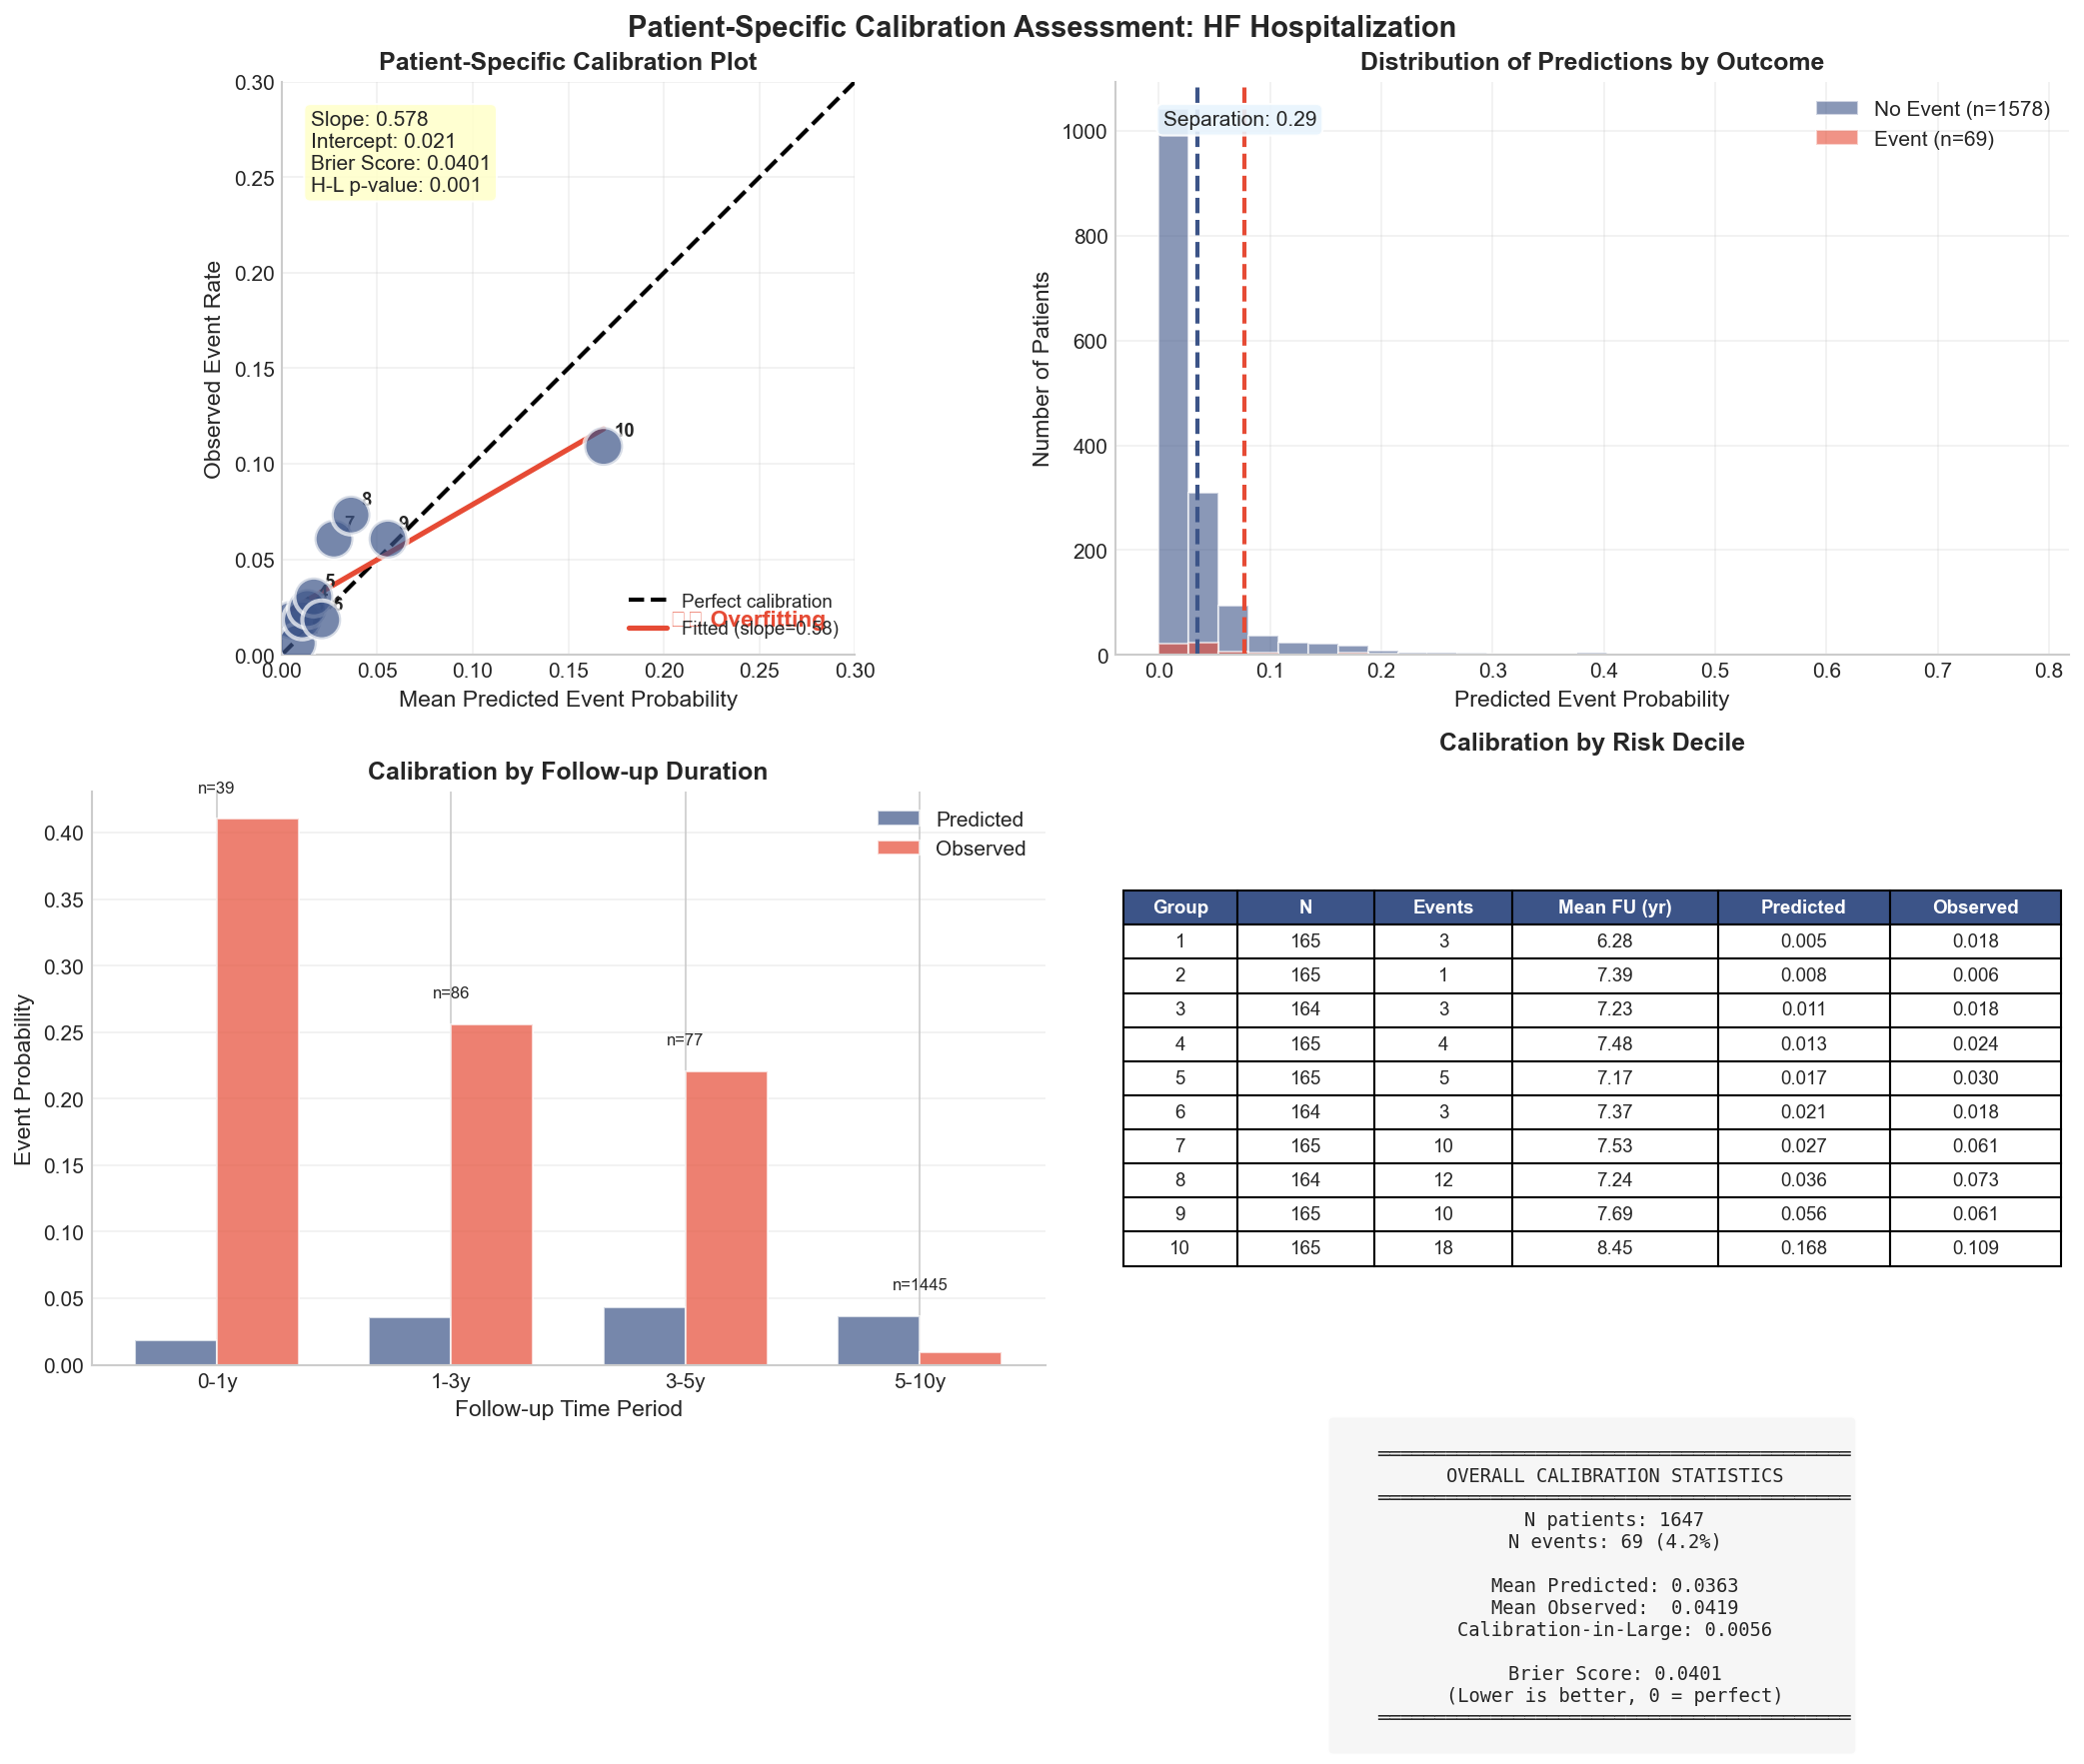


  📁 Saved: calibration_patient_specific_hf.png
  📁 Saved: calibration_groups_hf.xlsx
  📁 Saved: calibration_patient_predictions_hf.xlsx

════════════════════════════════════════════════════════════
Patient-Specific Calibration: All-Cause Mortality
════════════════════════════════════════════════════════════

  Sample size: 1647
  Events: 28 (1.7%)

  Calibration Statistics:
    Slope:                0.676 (ideal = 1.0)
    Intercept:            0.006 (ideal = 0.0)
    Brier Score:          0.0170 (lower = better)
    Calibration-in-Large: 0.0005
    H-L p-value:          0.000

  Interpretation:
    ⚠️ Slope < 0.8: Predictions too extreme (overfitting)
    ✅ Good calibration-in-the-large
📁 Saved: calibration_patient_specific_death.png


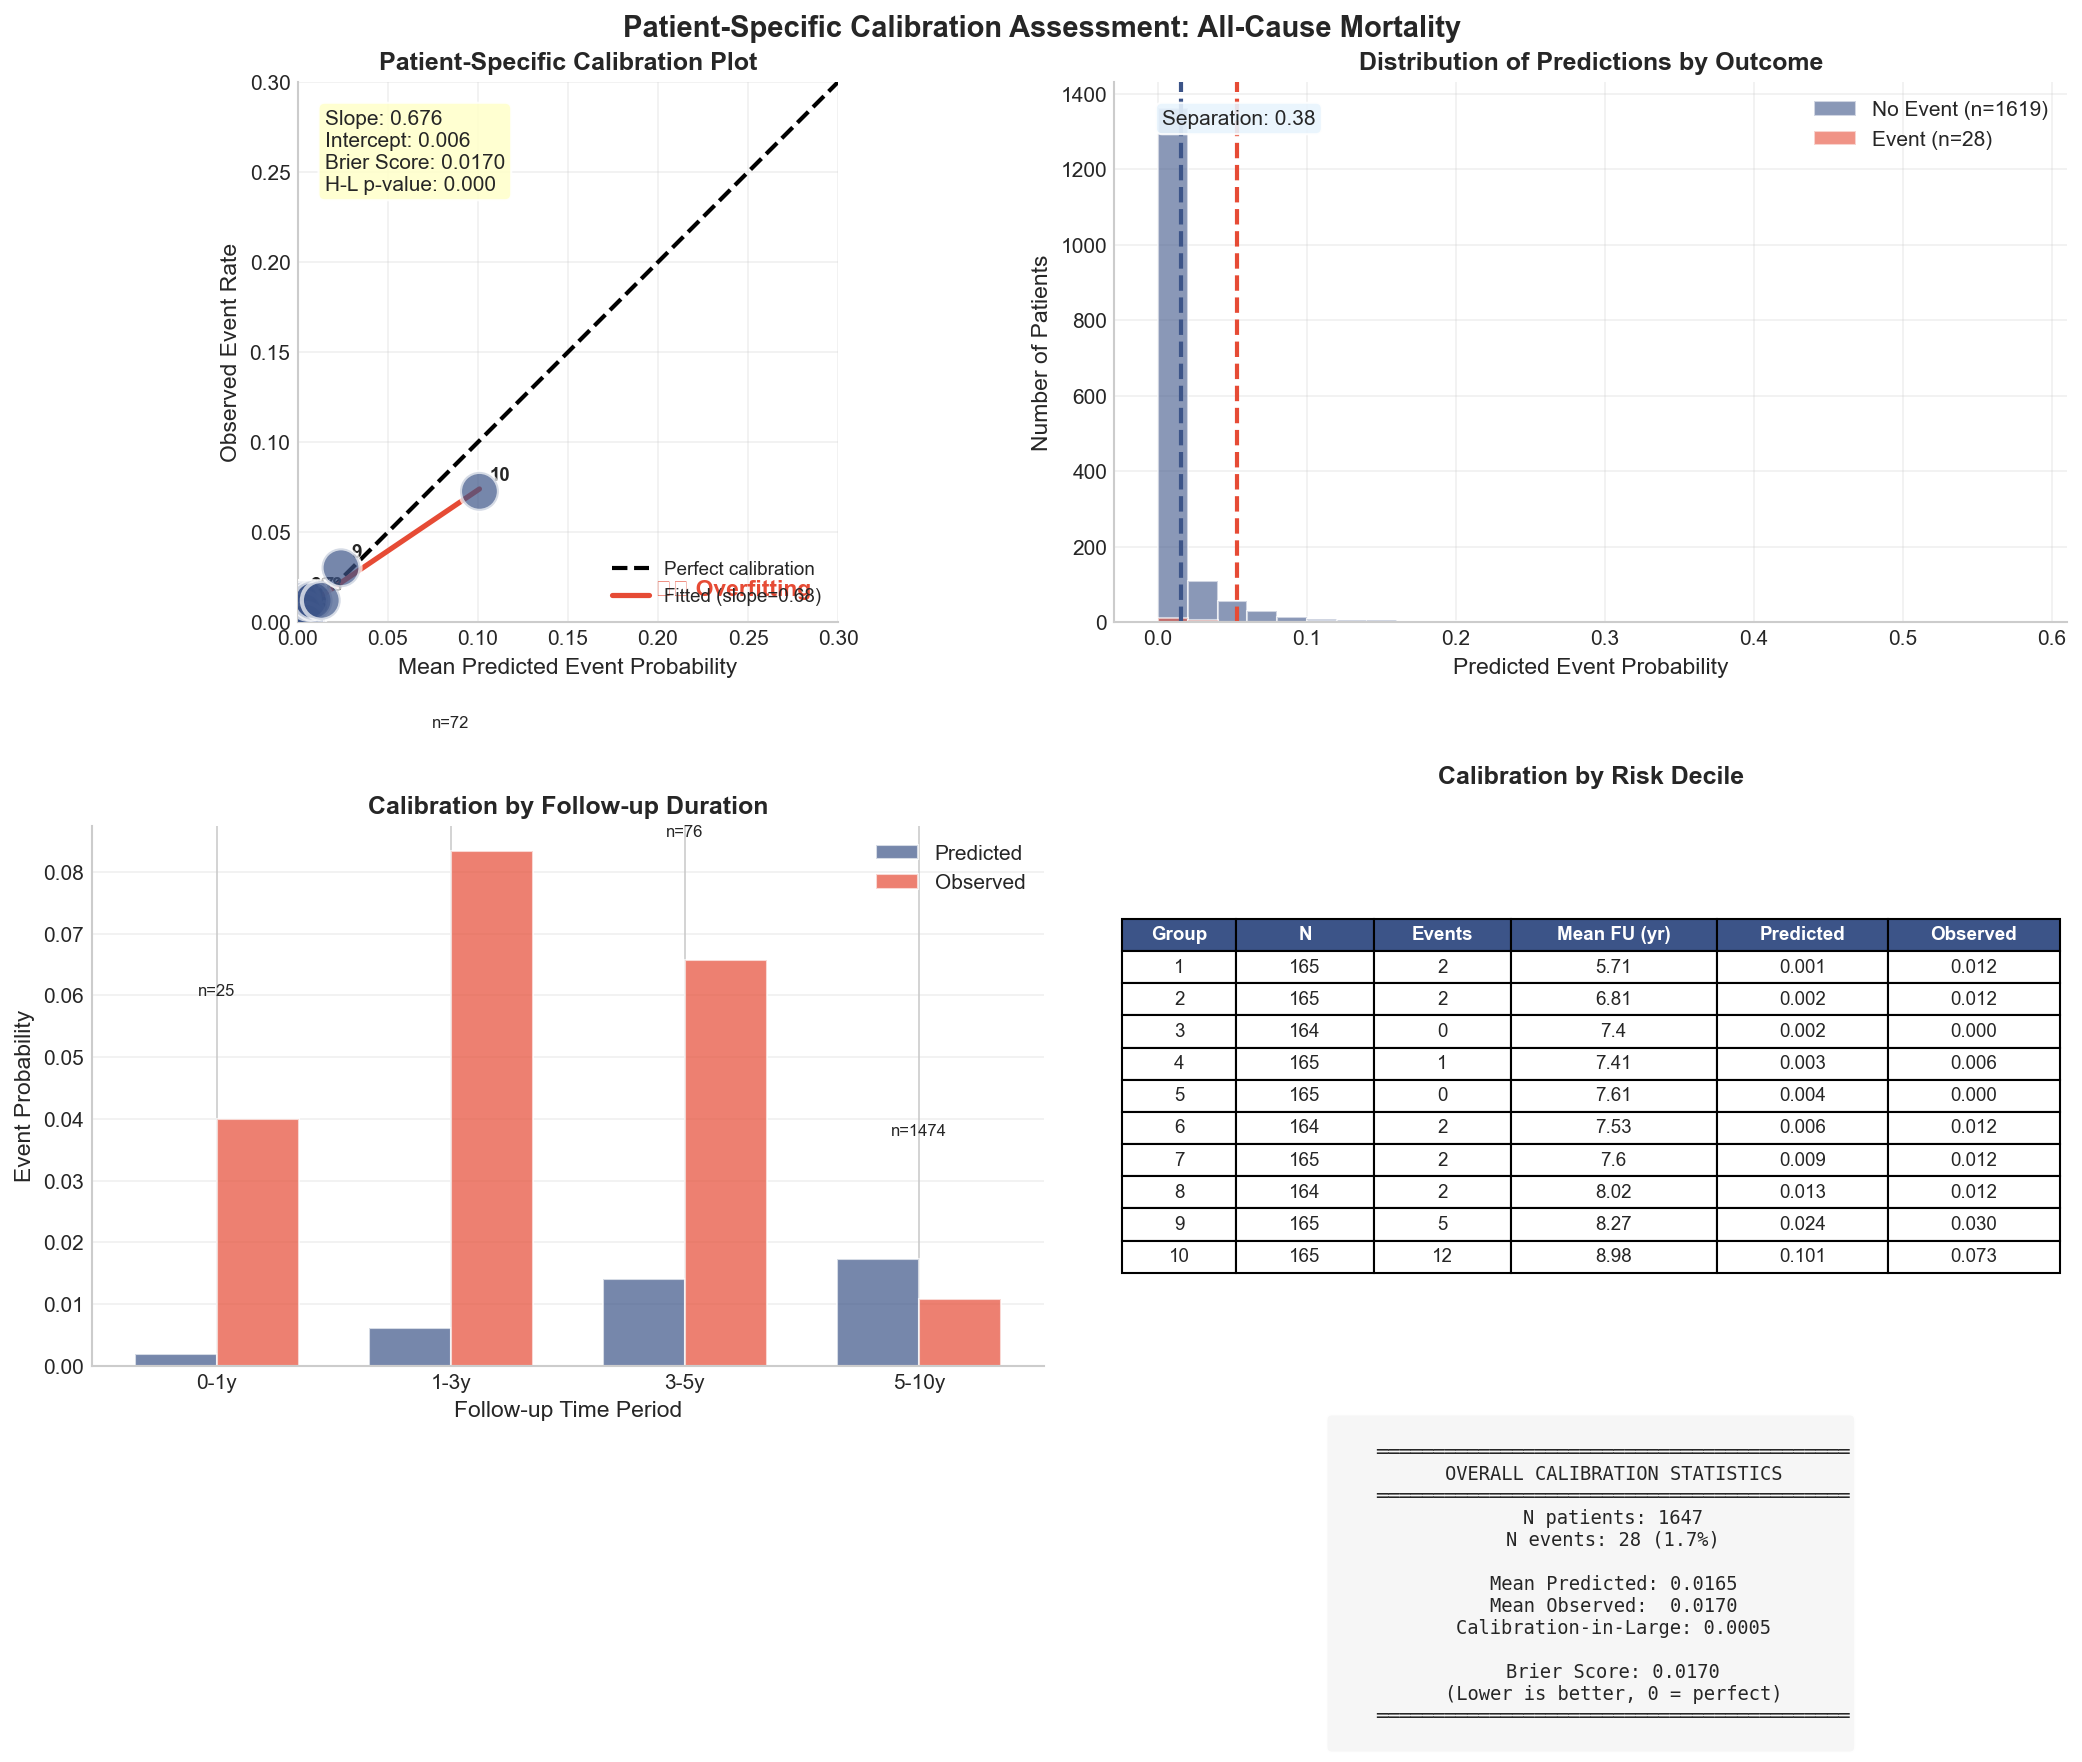


  📁 Saved: calibration_patient_specific_death.png
  📁 Saved: calibration_groups_death.xlsx
  📁 Saved: calibration_patient_predictions_death.xlsx

CALIBRATION SUMMARY

            Outcome    N  Events  Event Rate (%)  Slope  Intercept  Brier Score  Cal-in-Large  H-L p-value
 HF Hospitalization 1647      69             4.2  0.578      0.021       0.0401        0.0056        0.001
All-Cause Mortality 1647      28             1.7  0.676      0.006       0.0170        0.0005        0.000

📁 Saved: calibration_summary.xlsx

────────────────────────────────────────────────────────────
INTERPRETATION GUIDE
────────────────────────────────────────────────────────────

Patient-Specific Calibration:
  • Each patient's predicted probability is calculated at their
    OWN follow-up time, not at a fixed horizon (1yr, 5yr, etc.)
  • More appropriate for survival models with variable follow-up

Key Metrics:
  Calibration Slope (ideal = 1.0):
    • < 0.8: Overfitting - predictions too extreme
    • > 

In [231]:
# =============================================
# PART 13: CALIBRATION ASSESSMENT
# Patient-Specific, Time-Varying Calibration
# =============================================
print("\n" + "=" * 90)
print("PART 13: CALIBRATION ASSESSMENT (Patient-Specific)")
print("=" * 90)

from scipy.stats import chi2, linregress
from sklearn.metrics import brier_score_loss


def calculate_patient_specific_calibration(data, cph, time_col, event_col, n_groups=10):
    """
    Calculate patient-specific calibration where predicted probability
    is evaluated at each patient's own follow-up time.

    For each patient:
    - Get their follow-up time (days_hf_admission_new or days_death_new)
    - Calculate predicted survival probability at THAT specific time
    - Predicted event probability = 1 - predicted survival

    Then group patients and compare predicted vs observed.

    Returns:
        calibration_df: DataFrame with observed and predicted rates per group
        calibration_stats: Dictionary with slope, intercept, Brier score, etc.
        patient_predictions: DataFrame with individual patient predictions
    """
    data = data.copy()

    # Remove non-predictor columns if present
    cols_to_drop = ['risk_score', 'risk_group', '_time', 'pred_event_prob']
    for col in cols_to_drop:
        if col in data.columns:
            data = data.drop(columns=[col])

    # ─────────────────────────────────────────────
    # STEP 1: Calculate patient-specific predictions
    # ─────────────────────────────────────────────
    # Get full survival function for all patients
    surv_func = cph.predict_survival_function(data)

    # For each patient, get predicted survival at their own follow-up time
    pred_event_probs = []

    for idx in data.index:
        patient_time = data.loc[idx, time_col]

        # Find closest time in survival function
        available_times = surv_func.index
        closest_time_idx = np.abs(available_times - patient_time).argmin()
        closest_time = available_times[closest_time_idx]

        # Get predicted survival at patient's follow-up time
        pred_surv = surv_func.loc[closest_time, idx]
        pred_event = 1 - pred_surv

        pred_event_probs.append({
            'index': idx,
            'follow_up_time': patient_time,
            'follow_up_years': patient_time / 365.25,
            'pred_survival': pred_surv,
            'pred_event_prob': pred_event,
            'observed_event': data.loc[idx, event_col]
        })

    patient_predictions = pd.DataFrame(pred_event_probs).set_index('index')

    # ─────────────────────────────────────────────
    # STEP 2: Calculate Brier Score
    # ─────────────────────────────────────────────
    # Brier score = mean squared error between predicted probability and observed outcome
    brier_score = brier_score_loss(
        patient_predictions['observed_event'],
        patient_predictions['pred_event_prob']
    )

    # ─────────────────────────────────────────────
    # STEP 3: Group patients into risk deciles
    # ─────────────────────────────────────────────
    try:
        patient_predictions['risk_group'] = pd.qcut(
            patient_predictions['pred_event_prob'],
            q=n_groups,
            labels=False,
            duplicates='drop'
        )
    except ValueError:
        # If not enough unique values, use fewer groups
        n_unique = patient_predictions['pred_event_prob'].nunique()
        n_groups_actual = min(n_groups, n_unique)
        patient_predictions['risk_group'] = pd.qcut(
            patient_predictions['pred_event_prob'],
            q=n_groups_actual,
            labels=False,
            duplicates='drop'
        )

    # ─────────────────────────────────────────────
    # STEP 4: Calculate calibration per group
    # ─────────────────────────────────────────────
    calibration_data = []

    for group in sorted(patient_predictions['risk_group'].unique()):
        subset = patient_predictions[patient_predictions['risk_group'] == group]

        # Mean predicted probability in group
        pred_mean = subset['pred_event_prob'].mean()
        pred_std = subset['pred_event_prob'].std()

        # Observed event rate in group (simple proportion)
        obs_rate = subset['observed_event'].mean()

        # Number of events
        n_events = int(subset['observed_event'].sum())

        # Mean follow-up time in group
        mean_followup = subset['follow_up_years'].mean()

        calibration_data.append({
            'group': int(group) + 1,
            'n': len(subset),
            'n_events': n_events,
            'mean_followup_years': round(mean_followup, 2),
            'predicted_mean': pred_mean,
            'predicted_std': pred_std,
            'observed_rate': obs_rate,
            'pred_obs_diff': pred_mean - obs_rate
        })

    calibration_df = pd.DataFrame(calibration_data)

    # ─────────────────────────────────────────────
    # STEP 5: Calculate calibration statistics
    # ─────────────────────────────────────────────
    valid = calibration_df.dropna()

    if len(valid) >= 2:
        # Calibration slope and intercept
        slope, intercept, r_value, p_value, std_err = linregress(
            valid['predicted_mean'], valid['observed_rate']
        )

        # Hosmer-Lemeshow statistic
        valid = valid.copy()
        valid['expected_events'] = valid['predicted_mean'] * valid['n']
        valid['expected_non_events'] = (1 - valid['predicted_mean']) * valid['n']

        # Chi-square contributions
        valid['chi2_events'] = ((valid['n_events'] - valid['expected_events']) ** 2 /
                                (valid['expected_events'] + 0.001))
        valid['chi2_non_events'] = (((valid['n'] - valid['n_events']) - valid['expected_non_events']) ** 2 /
                                    (valid['expected_non_events'] + 0.001))

        hl_stat = (valid['chi2_events'] + valid['chi2_non_events']).sum()
        hl_df = max(1, len(valid) - 2)
        hl_p = 1 - chi2.cdf(hl_stat, df=hl_df)

        # Calibration-in-the-large (mean predicted vs mean observed)
        mean_pred = patient_predictions['pred_event_prob'].mean()
        mean_obs = patient_predictions['observed_event'].mean()
        cal_in_large = mean_obs - mean_pred  # Positive = underestimation

    else:
        slope, intercept, hl_stat, hl_p = np.nan, np.nan, np.nan, np.nan
        cal_in_large = np.nan

    calibration_stats = {
        'slope': slope,
        'intercept': intercept,
        'hl_statistic': hl_stat,
        'hl_p_value': hl_p,
        'brier_score': brier_score,
        'calibration_in_large': cal_in_large,
        'mean_predicted': patient_predictions['pred_event_prob'].mean(),
        'mean_observed': patient_predictions['observed_event'].mean(),
        'n_patients': len(patient_predictions),
        'n_events': int(patient_predictions['observed_event'].sum())
    }

    return calibration_df, calibration_stats, patient_predictions


def plot_patient_specific_calibration(calibration_df, calibration_stats, patient_predictions,
                                      outcome_label, out_path=None):
    """
    Plot patient-specific calibration with:
    - Main calibration plot (observed vs predicted by group)
    - Distribution of predictions
    - Calibration by follow-up time
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    valid = calibration_df.dropna()

    # ─────────────────────────────────────────────
    # Panel 1: Main Calibration Plot (Top Left)
    # ─────────────────────────────────────────────
    ax1 = axes[0, 0]

    # Perfect calibration line
    max_val = max(valid['predicted_mean'].max(), valid['observed_rate'].max()) * 1.15
    max_val = max(0.3, min(1.0, max_val))
    ax1.plot([0, max_val], [0, max_val], 'k--', linewidth=2, label='Perfect calibration')

    # Calibration points with error bars
    sizes = valid['n'] / valid['n'].max() * 300 + 50
    ax1.scatter(valid['predicted_mean'], valid['observed_rate'],
                s=sizes, c=COLORS['blue'], alpha=0.7,
                edgecolor='white', linewidth=2, zorder=5)

    # Fitted line
    if len(valid) >= 2 and pd.notna(calibration_stats['slope']):
        x_line = np.linspace(valid['predicted_mean'].min(),
                             valid['predicted_mean'].max(), 100)
        y_line = calibration_stats['slope'] * x_line + calibration_stats['intercept']
        ax1.plot(x_line, y_line, color=COLORS['red'], linewidth=2.5,
                 label=f'Fitted (slope={calibration_stats["slope"]:.2f})')

    # Add group numbers
    for _, row in valid.iterrows():
        ax1.annotate(f'{int(row["group"])}',
                     (row['predicted_mean'], row['observed_rate']),
                     xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold')

    # Statistics box
    stats_text = (f'Slope: {calibration_stats["slope"]:.3f}\n'
                  f'Intercept: {calibration_stats["intercept"]:.3f}\n'
                  f'Brier Score: {calibration_stats["brier_score"]:.4f}\n'
                  f'H-L p-value: {calibration_stats["hl_p_value"]:.3f}')
    ax1.text(0.05, 0.95, stats_text, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='#FFFFCC', alpha=0.9))

    # Quality indicator
    if pd.notna(calibration_stats['slope']):
        if calibration_stats['slope'] < 0.8:
            quality = '⚠️ Overfitting'
            qcolor = COLORS['red']
        elif calibration_stats['slope'] > 1.2:
            quality = '⚠️ Underfitting'
            qcolor = COLORS['red']
        else:
            quality = '✅ Good Calibration'
            qcolor = COLORS['teal']
        ax1.text(0.95, 0.05, quality, transform=ax1.transAxes,
                 ha='right', fontsize=11, fontweight='bold', color=qcolor)

    ax1.set_xlabel('Mean Predicted Event Probability', fontsize=11)
    ax1.set_ylabel('Observed Event Rate', fontsize=11)
    ax1.set_title('Patient-Specific Calibration Plot', fontsize=12, fontweight='bold')
    ax1.set_xlim([0, max_val])
    ax1.set_ylim([0, max_val])
    ax1.legend(loc='lower right', fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal', adjustable='box')

    # ─────────────────────────────────────────────
    # Panel 2: Distribution of Predicted Probabilities (Top Right)
    # ─────────────────────────────────────────────
    ax2 = axes[0, 1]

    # Histogram by event status
    events = patient_predictions[patient_predictions['observed_event'] == 1]['pred_event_prob']
    non_events = patient_predictions[patient_predictions['observed_event'] == 0]['pred_event_prob']

    bins = np.linspace(0, patient_predictions['pred_event_prob'].max() * 1.1, 30)

    ax2.hist(non_events, bins=bins, alpha=0.6, color=COLORS['blue'],
             label=f'No Event (n={len(non_events)})', edgecolor='white')
    ax2.hist(events, bins=bins, alpha=0.6, color=COLORS['red'],
             label=f'Event (n={len(events)})', edgecolor='white')

    # Add mean lines
    ax2.axvline(non_events.mean(), color=COLORS['blue'], linestyle='--', linewidth=2)
    ax2.axvline(events.mean(), color=COLORS['red'], linestyle='--', linewidth=2)

    ax2.set_xlabel('Predicted Event Probability', fontsize=11)
    ax2.set_ylabel('Number of Patients', fontsize=11)
    ax2.set_title('Distribution of Predictions by Outcome', fontsize=12, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    # Discrimination text
    auc_approx = (events.mean() - non_events.mean()) / (events.std() + non_events.std() + 0.001)
    ax2.text(0.05, 0.95, f'Separation: {auc_approx:.2f}', transform=ax2.transAxes,
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='#E8F4FD', alpha=0.9))

    # ─────────────────────────────────────────────
    # Panel 3: Calibration by Follow-up Time (Bottom Left)
    # ─────────────────────────────────────────────
    ax3 = axes[1, 0]

    # Create follow-up time groups
    patient_predictions['followup_group'] = pd.cut(
        patient_predictions['follow_up_years'],
        bins=[0, 1, 3, 5, 10, np.inf],
        labels=['0-1y', '1-3y', '3-5y', '5-10y', '>10y']
    )

    # Calculate calibration per follow-up group
    followup_calib = []
    for group in patient_predictions['followup_group'].cat.categories:
        subset = patient_predictions[patient_predictions['followup_group'] == group]
        if len(subset) > 10:  # Minimum sample
            followup_calib.append({
                'followup_group': group,
                'n': len(subset),
                'predicted': subset['pred_event_prob'].mean(),
                'observed': subset['observed_event'].mean()
            })

    followup_df = pd.DataFrame(followup_calib)

    if len(followup_df) > 0:
        x_pos = np.arange(len(followup_df))
        width = 0.35

        ax3.bar(x_pos - width / 2, followup_df['predicted'], width,
                label='Predicted', color=COLORS['blue'], alpha=0.7)
        ax3.bar(x_pos + width / 2, followup_df['observed'], width,
                label='Observed', color=COLORS['red'], alpha=0.7)

        ax3.set_xticks(x_pos)
        ax3.set_xticklabels(followup_df['followup_group'])

        # Add sample sizes
        for i, row in followup_df.iterrows():
            ax3.text(x_pos[i], max(row['predicted'], row['observed']) + 0.02,
                     f'n={row["n"]}', ha='center', fontsize=8)

    ax3.set_xlabel('Follow-up Time Period', fontsize=11)
    ax3.set_ylabel('Event Probability', fontsize=11)
    ax3.set_title('Calibration by Follow-up Duration', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')

    # ─────────────────────────────────────────────
    # Panel 4: Calibration Table (Bottom Right)
    # ─────────────────────────────────────────────
    ax4 = axes[1, 1]
    ax4.axis('off')

    # Create summary table
    table_data = valid[['group', 'n', 'n_events', 'mean_followup_years',
                        'predicted_mean', 'observed_rate']].copy()
    table_data['predicted_mean'] = table_data['predicted_mean'].apply(lambda x: f'{x:.3f}')
    table_data['observed_rate'] = table_data['observed_rate'].apply(lambda x: f'{x:.3f}')
    table_data.columns = ['Group', 'N', 'Events', 'Mean FU (yr)', 'Predicted', 'Observed']

    table = ax4.table(
        cellText=table_data.values,
        colLabels=table_data.columns,
        cellLoc='center',
        loc='center',
        colWidths=[0.1, 0.12, 0.12, 0.18, 0.15, 0.15]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)

    # Style header
    for i in range(len(table_data.columns)):
        table[(0, i)].set_facecolor(COLORS['blue'])
        table[(0, i)].set_text_props(color='white', fontweight='bold')

    ax4.set_title('Calibration by Risk Decile', fontsize=12, fontweight='bold', pad=20)

    # Overall statistics below table
    summary_text = f"""
    ══════════════════════════════════════════
    OVERALL CALIBRATION STATISTICS
    ══════════════════════════════════════════
    N patients: {calibration_stats['n_patients']}
    N events: {calibration_stats['n_events']} ({calibration_stats['n_events'] / calibration_stats['n_patients'] * 100:.1f}%)

    Mean Predicted: {calibration_stats['mean_predicted']:.4f}
    Mean Observed:  {calibration_stats['mean_observed']:.4f}
    Calibration-in-Large: {calibration_stats['calibration_in_large']:.4f}

    Brier Score: {calibration_stats['brier_score']:.4f}
    (Lower is better, 0 = perfect)
    ══════════════════════════════════════════
    """
    ax4.text(0.5, -0.1, summary_text, transform=ax4.transAxes, fontsize=9,
             ha='center', va='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='#F5F5F5', alpha=0.9))

    plt.suptitle(f'Patient-Specific Calibration Assessment: {outcome_label}',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()

    if out_path:
        plt.savefig(out_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"📁 Saved: {out_path}")

    plt.show()


# ─────────────────────────────────────────────
# RUN PATIENT-SPECIFIC CALIBRATION
# ─────────────────────────────────────────────
calibration_results = {}

for outcome_key, outcome_info in OUTCOMES.items():
    print(f"\n{'═' * 60}")
    print(f"Patient-Specific Calibration: {outcome_info['label']}")
    print(f"{'═' * 60}")

    results = model_results[outcome_key]
    cph = results['model']
    cox_test = results['cox_test'].copy()

    time_col = outcome_info['time_col']
    event_col = outcome_info['event_col']

    # Remove non-predictor columns
    cols_to_drop = ['risk_score', 'risk_group', '_time']
    for col in cols_to_drop:
        if col in cox_test.columns:
            cox_test = cox_test.drop(columns=[col])

    # Calculate patient-specific calibration
    calib_df, calib_stats, patient_preds = calculate_patient_specific_calibration(
        cox_test, cph, time_col, event_col, n_groups=10
    )

    # Print summary
    print(f"\n  Sample size: {calib_stats['n_patients']}")
    print(f"  Events: {calib_stats['n_events']} ({calib_stats['n_events'] / calib_stats['n_patients'] * 100:.1f}%)")
    print(f"\n  Calibration Statistics:")
    print(f"    Slope:                {calib_stats['slope']:.3f} (ideal = 1.0)")
    print(f"    Intercept:            {calib_stats['intercept']:.3f} (ideal = 0.0)")
    print(f"    Brier Score:          {calib_stats['brier_score']:.4f} (lower = better)")
    print(f"    Calibration-in-Large: {calib_stats['calibration_in_large']:.4f}")
    print(f"    H-L p-value:          {calib_stats['hl_p_value']:.3f}")

    # Interpretation
    print(f"\n  Interpretation:")
    if calib_stats['slope'] < 0.8:
        print(f"    ⚠️ Slope < 0.8: Predictions too extreme (overfitting)")
    elif calib_stats['slope'] > 1.2:
        print(f"    ⚠️ Slope > 1.2: Predictions too conservative (underfitting)")
    else:
        print(f"    ✅ Slope 0.8-1.2: Good calibration")

    if abs(calib_stats['calibration_in_large']) > 0.05:
        direction = "underestimates" if calib_stats['calibration_in_large'] > 0 else "overestimates"
        print(f"    ⚠️ Model {direction} overall risk")
    else:
        print(f"    ✅ Good calibration-in-the-large")

    # Store results
    calibration_results[outcome_key] = {
        'data': calib_df,
        'stats': calib_stats,
        'patient_predictions': patient_preds
    }

    # Plot
    plot_patient_specific_calibration(
        calib_df, calib_stats, patient_preds,
        outcome_info['label'],
        out_path=f'calibration_patient_specific_{outcome_key}.png'
    )

    # Save detailed data
    calib_df.to_excel(f'calibration_groups_{outcome_key}.xlsx', index=False)
    patient_preds.to_excel(f'calibration_patient_predictions_{outcome_key}.xlsx')
    print(f"\n  📁 Saved: calibration_patient_specific_{outcome_key}.png")
    print(f"  📁 Saved: calibration_groups_{outcome_key}.xlsx")
    print(f"  📁 Saved: calibration_patient_predictions_{outcome_key}.xlsx")

# ─────────────────────────────────────────────
# COMBINED SUMMARY TABLE
# ─────────────────────────────────────────────
print("\n" + "=" * 90)
print("CALIBRATION SUMMARY")
print("=" * 90)

summary_rows = []
for outcome_key, outcome_info in OUTCOMES.items():
    stats = calibration_results[outcome_key]['stats']
    summary_rows.append({
        'Outcome': outcome_info['label'],
        'N': stats['n_patients'],
        'Events': stats['n_events'],
        'Event Rate (%)': round(stats['n_events'] / stats['n_patients'] * 100, 1),
        'Slope': round(stats['slope'], 3),
        'Intercept': round(stats['intercept'], 3),
        'Brier Score': round(stats['brier_score'], 4),
        'Cal-in-Large': round(stats['calibration_in_large'], 4),
        'H-L p-value': round(stats['hl_p_value'], 3)
    })

calibration_summary = pd.DataFrame(summary_rows)
print("\n" + calibration_summary.to_string(index=False))

calibration_summary.to_excel('calibration_summary.xlsx', index=False)
print(f"\n📁 Saved: calibration_summary.xlsx")

# ─────────────────────────────────────────────
# INTERPRETATION GUIDE
# ─────────────────────────────────────────────
print("\n" + "─" * 60)
print("INTERPRETATION GUIDE")
print("─" * 60)
print("""
Patient-Specific Calibration:
  • Each patient's predicted probability is calculated at their
    OWN follow-up time, not at a fixed horizon (1yr, 5yr, etc.)
  • More appropriate for survival models with variable follow-up

Key Metrics:
  Calibration Slope (ideal = 1.0):
    • < 0.8: Overfitting - predictions too extreme
    • > 1.2: Underfitting - predictions too conservative
    • 0.8-1.2: Good calibration ✅

  Calibration Intercept (ideal = 0.0):
    • Systematic over/under-estimation

  Calibration-in-the-Large:
    • Mean(Observed) - Mean(Predicted)
    • > 0: Model underestimates risk
    • < 0: Model overestimates risk

  Brier Score (range 0-1):
    • 0 = Perfect prediction
    • < 0.1: Excellent
    • 0.1-0.2: Good
    • > 0.25: Poor

  Hosmer-Lemeshow p-value:
    • p > 0.05: Good fit ✅
    • p < 0.05: Significant miscalibration ⚠️
""")

print("\n" + "=" * 90)
print("✅ PATIENT-SPECIFIC CALIBRATION COMPLETE")
print("=" * 90)


PART 14: BOOTSTRAP INTERNAL VALIDATION

════════════════════════════════════════════════════════════
Bootstrap Validation: HF Hospitalization
════════════════════════════════════════════════════════════

  Using clean training data:
  Columns: ['sex', 'age', 'BMI', 'sbp', 'dbp', 'hr', 'smoker', 'htn', 'dm', 'hyperlipidemia', 'cad', 'stroke', 'baseline_af', 'LDL', 'HDL', 'tg', 'eGFR', 'A1C', 'FBS', 'LAVI', 'la_strain_avg', 'rwt', 'IVSd', 'LVPWd', 'LVIDd', 'LVIDs', 'LVmass_index', 'LVEF', 'LV_volume_index', 'LVstrain_avg', 'TR_V', 'dt', 'ivrt', 'E', 'A', 'TDI_Ea_mean', 'E_Ea_mean', 'days_hf_admission_new', 'hHF_total']
  Sample size for bootstrap: 3842
  Events: 160
  Predictors: 37

  Original apparent C-index: 0.8450

  Running 200 bootstrap iterations...
    Completed 50/200 iterations
    Completed 100/200 iterations
    Completed 150/200 iterations
    Completed 200/200 iterations

  ──────────────────────────────────────────────────
  RESULTS:
  ───────────────────────────────────

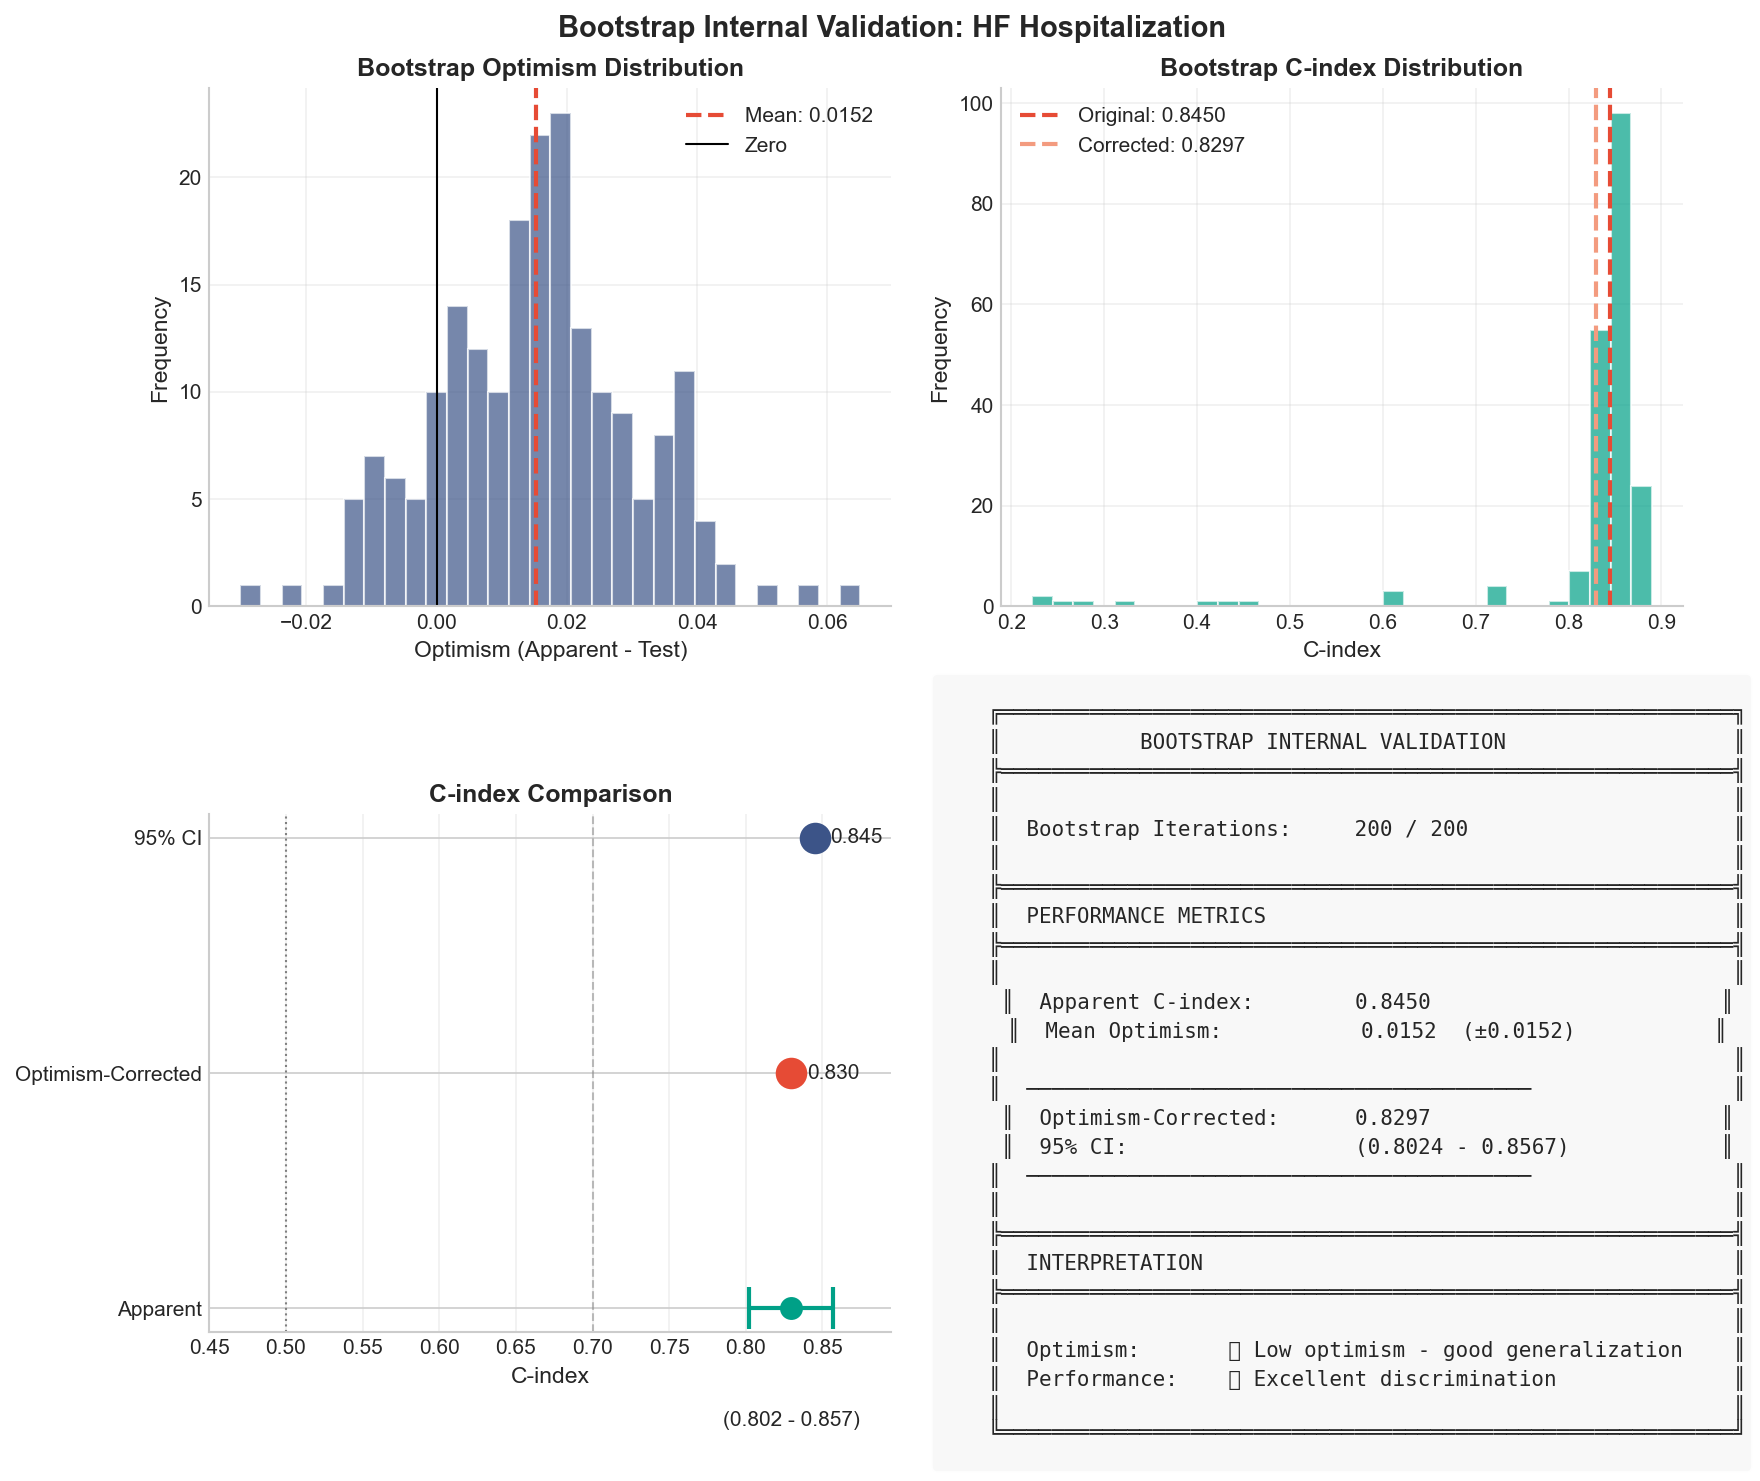


════════════════════════════════════════════════════════════
Bootstrap Validation: All-Cause Mortality
════════════════════════════════════════════════════════════

  Using clean training data:
  Columns: ['sex', 'age', 'BMI', 'sbp', 'dbp', 'hr', 'smoker', 'htn', 'dm', 'hyperlipidemia', 'cad', 'stroke', 'baseline_af', 'LDL', 'HDL', 'tg', 'eGFR', 'A1C', 'FBS', 'LAVI', 'la_strain_avg', 'rwt', 'IVSd', 'LVPWd', 'LVIDd', 'LVIDs', 'LVmass_index', 'LVEF', 'LV_volume_index', 'LVstrain_avg', 'TR_V', 'dt', 'ivrt', 'E', 'A', 'TDI_Ea_mean', 'E_Ea_mean', 'days_death_new', 'death']
  Sample size for bootstrap: 3842
  Events: 68
  Predictors: 37

  Original apparent C-index: 0.9205

  Running 200 bootstrap iterations...
    Completed 50/200 iterations
    Completed 100/200 iterations
    Completed 150/200 iterations
    Completed 200/200 iterations

  ──────────────────────────────────────────────────
  RESULTS:
  ──────────────────────────────────────────────────
  Apparent C-index:        0.9205
 

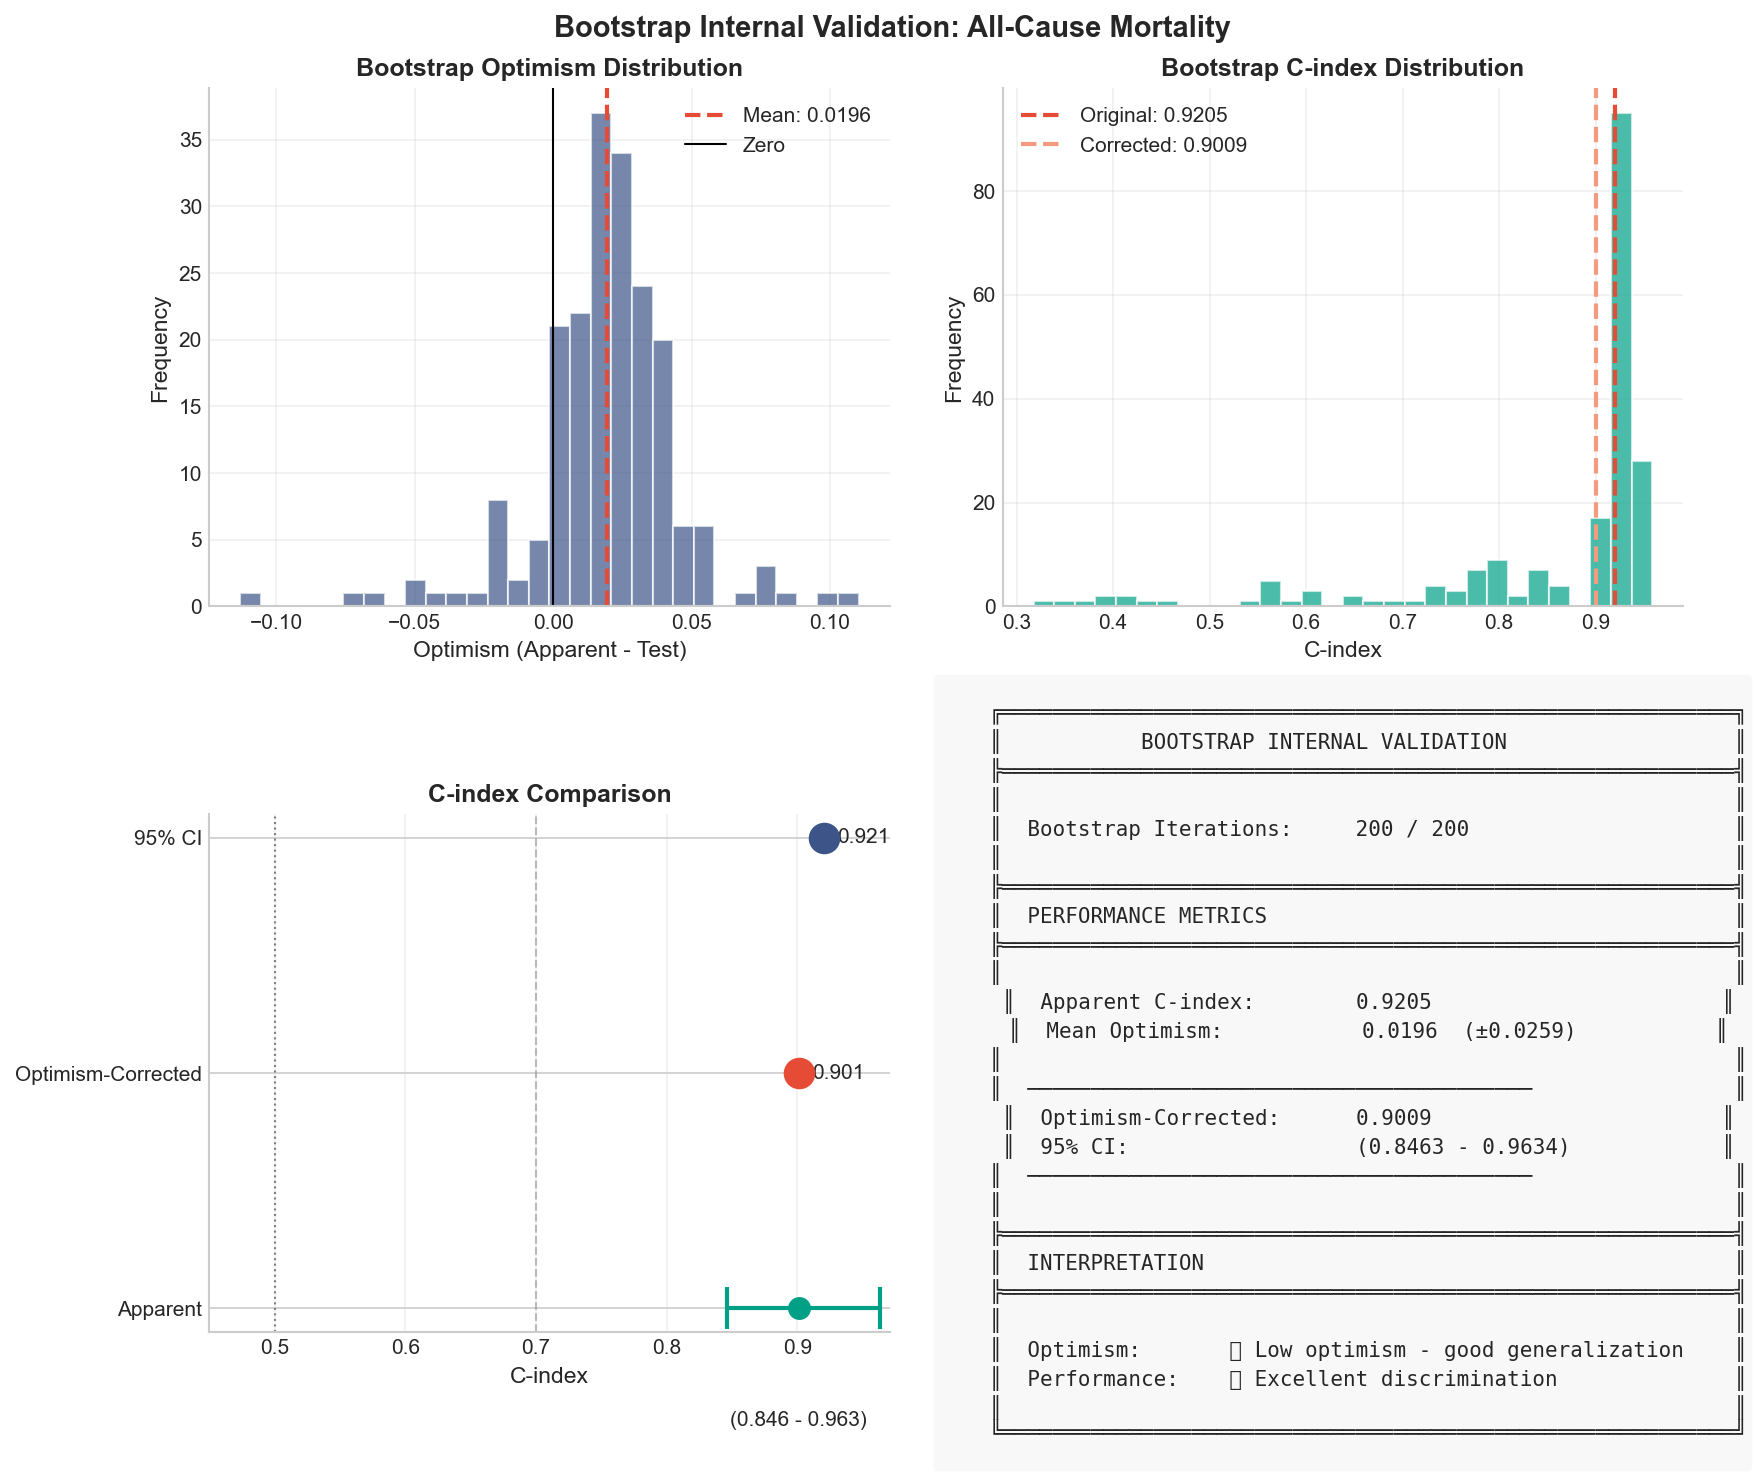


BOOTSTRAP VALIDATION SUMMARY

            Outcome  Apparent C-index  Mean Optimism  Corrected C-index  95% CI Lower  95% CI Upper  Iterations
 HF Hospitalization            0.8450         0.0152             0.8297        0.8024        0.8567         200
All-Cause Mortality            0.9205         0.0196             0.9009        0.8463        0.9634         200

📁 Saved: bootstrap_validation_summary.xlsx

────────────────────────────────────────────────────────────
INTERPRETATION GUIDE
────────────────────────────────────────────────────────────

Bootstrap Internal Validation (Harrell's Optimism Correction):

Method:
  1. Fit model on bootstrap sample (with replacement)
  2. Evaluate on bootstrap sample → Apparent C-index
  3. Evaluate same model on original data → Test C-index
  4. Optimism = Apparent - Test
  5. Corrected C-index = Original Apparent - Mean(Optimism)

Optimism Interpretation:
  • < 0.02: Low optimism ✅ (good generalization)
  • 0.02-0.05: Moderate optimism ⚡ (accep

In [233]:
# =============================================
# PART 14: BOOTSTRAP INTERNAL VALIDATION
# =============================================
print("\n" + "=" * 90)
print("PART 14: BOOTSTRAP INTERNAL VALIDATION")
print("=" * 90)


def bootstrap_validation(data, time_col, event_col, predictors,
                         penalizer, l1_ratio=0.5, n_bootstrap=200,
                         random_state=42, verbose=True):
    """
    Perform bootstrap validation to estimate optimism-corrected C-index.

    Method: Harrell's optimism correction
    1. Fit model on bootstrap sample
    2. Evaluate on bootstrap sample (apparent performance)
    3. Evaluate on original data (test performance)
    4. Optimism = apparent - test
    5. Corrected C-index = original apparent - mean(optimism)
    """
    np.random.seed(random_state)

    # ═══════════════════════════════════════════
    # FIX: Clean data - remove non-predictor columns
    # ═══════════════════════════════════════════
    data = data.copy()
    cols_to_drop = ['risk_score', 'risk_group', '_time', 'pred_event_prob',
                    'followup_group', 'cr_time', 'cr_event']
    for col in cols_to_drop:
        if col in data.columns:
            data = data.drop(columns=[col])
            print(f"  Dropped column: {col}")

    # Keep only necessary columns
    required_cols = predictors + [time_col, event_col]
    available_cols = [col for col in required_cols if col in data.columns]
    data = data[available_cols].copy()

    # Ensure all columns are numeric
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

    # Drop rows with missing values
    data = data.dropna()

    n = len(data)
    print(f"  Sample size for bootstrap: {n}")
    print(f"  Events: {int(data[event_col].sum())}")
    print(f"  Predictors: {len(predictors)}")

    # Original apparent performance
    cph_original = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
    cph_original.fit(data, duration_col=time_col, event_col=event_col)
    pred_original = cph_original.predict_partial_hazard(data)
    apparent_original = concordance_index(data[time_col], -pred_original, data[event_col])

    print(f"\n  Original apparent C-index: {apparent_original:.4f}")
    print(f"\n  Running {n_bootstrap} bootstrap iterations...")

    optimism_values = []
    bootstrap_c_indices = []
    failed_iterations = 0

    for i in range(n_bootstrap):
        # Bootstrap sample (with replacement)
        boot_idx = np.random.choice(n, size=n, replace=True)
        boot_data = data.iloc[boot_idx].copy()
        boot_data = boot_data.reset_index(drop=True)

        try:
            # Fit on bootstrap sample
            cph_boot = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
            cph_boot.fit(boot_data, duration_col=time_col, event_col=event_col)

            # Apparent performance (on bootstrap sample)
            pred_boot = cph_boot.predict_partial_hazard(boot_data)
            c_apparent = concordance_index(boot_data[time_col], -pred_boot, boot_data[event_col])

            # Test performance (on original data)
            pred_test = cph_boot.predict_partial_hazard(data)
            c_test = concordance_index(data[time_col], -pred_test, data[event_col])

            # Optimism
            optimism = c_apparent - c_test
            optimism_values.append(optimism)
            bootstrap_c_indices.append(c_apparent)

        except Exception as e:
            failed_iterations += 1
            continue

        if verbose and (i + 1) % 50 == 0:
            print(f"    Completed {i + 1}/{n_bootstrap} iterations")

    if failed_iterations > 0:
        print(f"  ⚠️ Failed iterations: {failed_iterations}/{n_bootstrap}")

    # Calculate optimism-corrected C-index
    mean_optimism = np.mean(optimism_values)
    std_optimism = np.std(optimism_values)
    corrected_c = apparent_original - mean_optimism

    # 95% CI for corrected C-index (using bootstrap distribution)
    corrected_values = [apparent_original - o for o in optimism_values]
    ci_lower = np.percentile(corrected_values, 2.5)
    ci_upper = np.percentile(corrected_values, 97.5)

    results = {
        'apparent_c_index': apparent_original,
        'mean_optimism': mean_optimism,
        'std_optimism': std_optimism,
        'corrected_c_index': corrected_c,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'n_successful_iterations': len(optimism_values),
        'n_failed_iterations': failed_iterations,
        'optimism_values': optimism_values,
        'bootstrap_c_indices': bootstrap_c_indices
    }

    return results


def plot_bootstrap_results(boot_results, outcome_label, out_path=None):
    """Plot bootstrap validation results."""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # ─────────────────────────────────────────────
    # Panel 1: Optimism distribution (Top Left)
    # ─────────────────────────────────────────────
    ax1 = axes[0, 0]
    ax1.hist(boot_results['optimism_values'], bins=30, edgecolor='white',
             alpha=0.7, color=COLORS['blue'])
    ax1.axvline(boot_results['mean_optimism'], color=COLORS['red'],
                linestyle='--', linewidth=2,
                label=f'Mean: {boot_results["mean_optimism"]:.4f}')
    ax1.axvline(0, color='black', linestyle='-', linewidth=1, label='Zero')
    ax1.set_xlabel('Optimism (Apparent - Test)', fontsize=11)
    ax1.set_ylabel('Frequency', fontsize=11)
    ax1.set_title('Bootstrap Optimism Distribution', fontsize=12, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Panel 2: Bootstrap C-index distribution (Top Right)
    # ─────────────────────────────────────────────
    ax2 = axes[0, 1]
    ax2.hist(boot_results['bootstrap_c_indices'], bins=30, edgecolor='white',
             alpha=0.7, color=COLORS['teal'])
    ax2.axvline(boot_results['apparent_c_index'], color=COLORS['red'],
                linestyle='--', linewidth=2,
                label=f'Original: {boot_results["apparent_c_index"]:.4f}')
    ax2.axvline(boot_results['corrected_c_index'], color=COLORS['orange'],
                linestyle='--', linewidth=2,
                label=f'Corrected: {boot_results["corrected_c_index"]:.4f}')
    ax2.set_xlabel('C-index', fontsize=11)
    ax2.set_ylabel('Frequency', fontsize=11)
    ax2.set_title('Bootstrap C-index Distribution', fontsize=12, fontweight='bold')
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Panel 3: Corrected C-index with 95% CI (Bottom Left)
    # ─────────────────────────────────────────────
    ax3 = axes[1, 0]

    # Create forest-plot style visualization
    y_pos = [2, 1, 0]
    labels = ['Apparent', 'Optimism-Corrected', '95% CI Range']
    values = [boot_results['apparent_c_index'],
              boot_results['corrected_c_index'],
              boot_results['corrected_c_index']]

    # Plot points
    ax3.scatter([boot_results['apparent_c_index']], [2], s=200,
                color=COLORS['blue'], zorder=5, label='Apparent')
    ax3.scatter([boot_results['corrected_c_index']], [1], s=200,
                color=COLORS['red'], zorder=5, label='Corrected')

    # Plot CI
    ax3.errorbar(boot_results['corrected_c_index'], 0,
                 xerr=[[boot_results['corrected_c_index'] - boot_results['ci_lower']],
                       [boot_results['ci_upper'] - boot_results['corrected_c_index']]],
                 fmt='o', color=COLORS['teal'], markersize=10, capsize=10,
                 capthick=2, linewidth=2, label='95% CI')

    ax3.axvline(0.5, color='gray', linestyle=':', linewidth=1, label='Reference (0.5)')
    ax3.axvline(0.7, color='gray', linestyle='--', linewidth=1, alpha=0.5)

    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(['95% CI', 'Optimism-Corrected', 'Apparent'])
    ax3.set_xlabel('C-index', fontsize=11)
    ax3.set_title('C-index Comparison', fontsize=12, fontweight='bold')
    ax3.set_xlim([0.45, max(0.85, boot_results['apparent_c_index'] + 0.05)])
    ax3.grid(True, alpha=0.3, axis='x')

    # Add value labels
    ax3.text(boot_results['apparent_c_index'] + 0.01, 2,
             f'{boot_results["apparent_c_index"]:.3f}', va='center', fontsize=10)
    ax3.text(boot_results['corrected_c_index'] + 0.01, 1,
             f'{boot_results["corrected_c_index"]:.3f}', va='center', fontsize=10)
    ax3.text(boot_results['corrected_c_index'], -0.5,
             f'({boot_results["ci_lower"]:.3f} - {boot_results["ci_upper"]:.3f})',
             ha='center', fontsize=10)

    # ─────────────────────────────────────────────
    # Panel 4: Summary text (Bottom Right)
    # ─────────────────────────────────────────────
    ax4 = axes[1, 1]
    ax4.axis('off')

    # Determine interpretation
    if boot_results['mean_optimism'] > 0.05:
        optimism_interp = "⚠️ High optimism - consider more regularization"
    elif boot_results['mean_optimism'] > 0.02:
        optimism_interp = "⚡ Moderate optimism - acceptable"
    else:
        optimism_interp = "✅ Low optimism - good generalization"

    if boot_results['corrected_c_index'] >= 0.75:
        perf_interp = "✅ Excellent discrimination"
    elif boot_results['corrected_c_index'] >= 0.70:
        perf_interp = "✅ Good discrimination"
    elif boot_results['corrected_c_index'] >= 0.65:
        perf_interp = "⚡ Moderate discrimination"
    else:
        perf_interp = "⚠️ Poor discrimination"

    summary_text = f"""
    ╔══════════════════════════════════════════════════════════╗
    ║           BOOTSTRAP INTERNAL VALIDATION                  ║
    ╠══════════════════════════════════════════════════════════╣
    ║                                                          ║
    ║  Bootstrap Iterations:    {boot_results['n_successful_iterations']:>4} / {boot_results['n_successful_iterations'] + boot_results['n_failed_iterations']}                     ║
    ║                                                          ║
    ╠══════════════════════════════════════════════════════════╣
    ║  PERFORMANCE METRICS                                     ║
    ╠══════════════════════════════════════════════════════════╣
    ║                                                          ║
    ║  Apparent C-index:        {boot_results['apparent_c_index']:.4f}                       ║
    ║  Mean Optimism:           {boot_results['mean_optimism']:.4f}  (±{boot_results['std_optimism']:.4f})           ║
    ║                                                          ║
    ║  ────────────────────────────────────────                ║
    ║  Optimism-Corrected:      {boot_results['corrected_c_index']:.4f}                       ║
    ║  95% CI:                  ({boot_results['ci_lower']:.4f} - {boot_results['ci_upper']:.4f})            ║
    ║  ────────────────────────────────────────                ║
    ║                                                          ║
    ╠══════════════════════════════════════════════════════════╣
    ║  INTERPRETATION                                          ║
    ╠══════════════════════════════════════════════════════════╣
    ║                                                          ║
    ║  Optimism:       {optimism_interp:<40}║
    ║  Performance:    {perf_interp:<40}║
    ║                                                          ║
    ╚══════════════════════════════════════════════════════════╝
    """

    ax4.text(0.5, 0.5, summary_text, transform=ax4.transAxes,
             fontsize=10, verticalalignment='center', horizontalalignment='center',
             fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='#F8F8F8', alpha=0.9))

    plt.suptitle(f'Bootstrap Internal Validation: {outcome_label}',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()

    if out_path:
        plt.savefig(out_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"📁 Saved: {out_path}")

    plt.show()


# ─────────────────────────────────────────────
# RUN BOOTSTRAP VALIDATION FOR BOTH OUTCOMES
# ─────────────────────────────────────────────
bootstrap_results = {}

for outcome_key, outcome_info in OUTCOMES.items():
    print(f"\n{'═' * 60}")
    print(f"Bootstrap Validation: {outcome_info['label']}")
    print(f"{'═' * 60}")

    results = model_results[outcome_key]
    best_penalizer = results['best_penalizer']

    time_col = outcome_info['time_col']
    event_col = outcome_info['event_col']

    # ═══════════════════════════════════════════
    # FIX: Get clean training data
    # ═══════════════════════════════════════════
    # Use original train_scaled data, not the one with risk_score/risk_group
    cox_train_clean = train_scaled[predictors + [time_col, event_col]].dropna().copy()

    # Ensure event column is integer
    cox_train_clean[event_col] = cox_train_clean[event_col].astype(int)

    print(f"\n  Using clean training data:")
    print(f"  Columns: {list(cox_train_clean.columns)}")

    # Run bootstrap validation
    boot_results = bootstrap_validation(
        cox_train_clean,
        time_col,
        event_col,
        predictors,
        penalizer=best_penalizer,
        n_bootstrap=200,
        verbose=True
    )

    # Print summary
    print(f"\n  {'─' * 50}")
    print(f"  RESULTS:")
    print(f"  {'─' * 50}")
    print(f"  Apparent C-index:        {boot_results['apparent_c_index']:.4f}")
    print(f"  Mean Optimism:           {boot_results['mean_optimism']:.4f} (±{boot_results['std_optimism']:.4f})")
    print(f"  Optimism-Corrected:      {boot_results['corrected_c_index']:.4f}")
    print(f"  95% CI:                  ({boot_results['ci_lower']:.4f} - {boot_results['ci_upper']:.4f})")

    # Store results
    bootstrap_results[outcome_key] = boot_results

    # Plot
    plot_bootstrap_results(
        boot_results,
        outcome_info['label'],
        out_path=f'bootstrap_validation_{outcome_key}.png'
    )

# ─────────────────────────────────────────────
# SUMMARY TABLE
# ─────────────────────────────────────────────
print("\n" + "=" * 90)
print("BOOTSTRAP VALIDATION SUMMARY")
print("=" * 90)

summary_rows = []
for outcome_key, outcome_info in OUTCOMES.items():
    br = bootstrap_results[outcome_key]
    summary_rows.append({
        'Outcome': outcome_info['label'],
        'Apparent C-index': round(br['apparent_c_index'], 4),
        'Mean Optimism': round(br['mean_optimism'], 4),
        'Corrected C-index': round(br['corrected_c_index'], 4),
        '95% CI Lower': round(br['ci_lower'], 4),
        '95% CI Upper': round(br['ci_upper'], 4),
        'Iterations': br['n_successful_iterations']
    })

bootstrap_summary = pd.DataFrame(summary_rows)
print("\n" + bootstrap_summary.to_string(index=False))

bootstrap_summary.to_excel('bootstrap_validation_summary.xlsx', index=False)
print(f"\n📁 Saved: bootstrap_validation_summary.xlsx")

# ─────────────────────────────────────────────
# INTERPRETATION GUIDE
# ─────────────────────────────────────────────
print("\n" + "─" * 60)
print("INTERPRETATION GUIDE")
print("─" * 60)
print("""
Bootstrap Internal Validation (Harrell's Optimism Correction):

Method:
  1. Fit model on bootstrap sample (with replacement)
  2. Evaluate on bootstrap sample → Apparent C-index
  3. Evaluate same model on original data → Test C-index
  4. Optimism = Apparent - Test
  5. Corrected C-index = Original Apparent - Mean(Optimism)

Optimism Interpretation:
  • < 0.02: Low optimism ✅ (good generalization)
  • 0.02-0.05: Moderate optimism ⚡ (acceptable)
  • > 0.05: High optimism ⚠️ (consider more regularization)

C-index Interpretation:
  • ≥ 0.75: Excellent discrimination ✅
  • 0.70-0.75: Good discrimination ✅
  • 0.65-0.70: Moderate discrimination ⚡
  • < 0.65: Poor discrimination ⚠️

For Manuscript:
  Report optimism-corrected C-index with 95% CI:
  "The optimism-corrected C-index was 0.XXX (95% CI: 0.XXX-0.XXX)"
""")

print("\n" + "=" * 90)
print("✅ BOOTSTRAP VALIDATION COMPLETE")
print("=" * 90)


PART 16: DECISION CURVE ANALYSIS

════════════════════════════════════════════════════════════
Decision Curve Analysis: HF Hospitalization
════════════════════════════════════════════════════════════

  Test set size: 1647
  Events: 69

  Time       Prevalence   Useful Range         Max Net Benefit
  ────────────────────────────────────────────────────────────
  1-year        1.0%      1%-26%               0.0065
  3-year        2.4%      1%-50%               0.0154
  5-year        3.5%      2%-42%               0.0205
  10-year        4.2%      1%-45%               0.0325
📁 Saved: dca_grid_hf.png


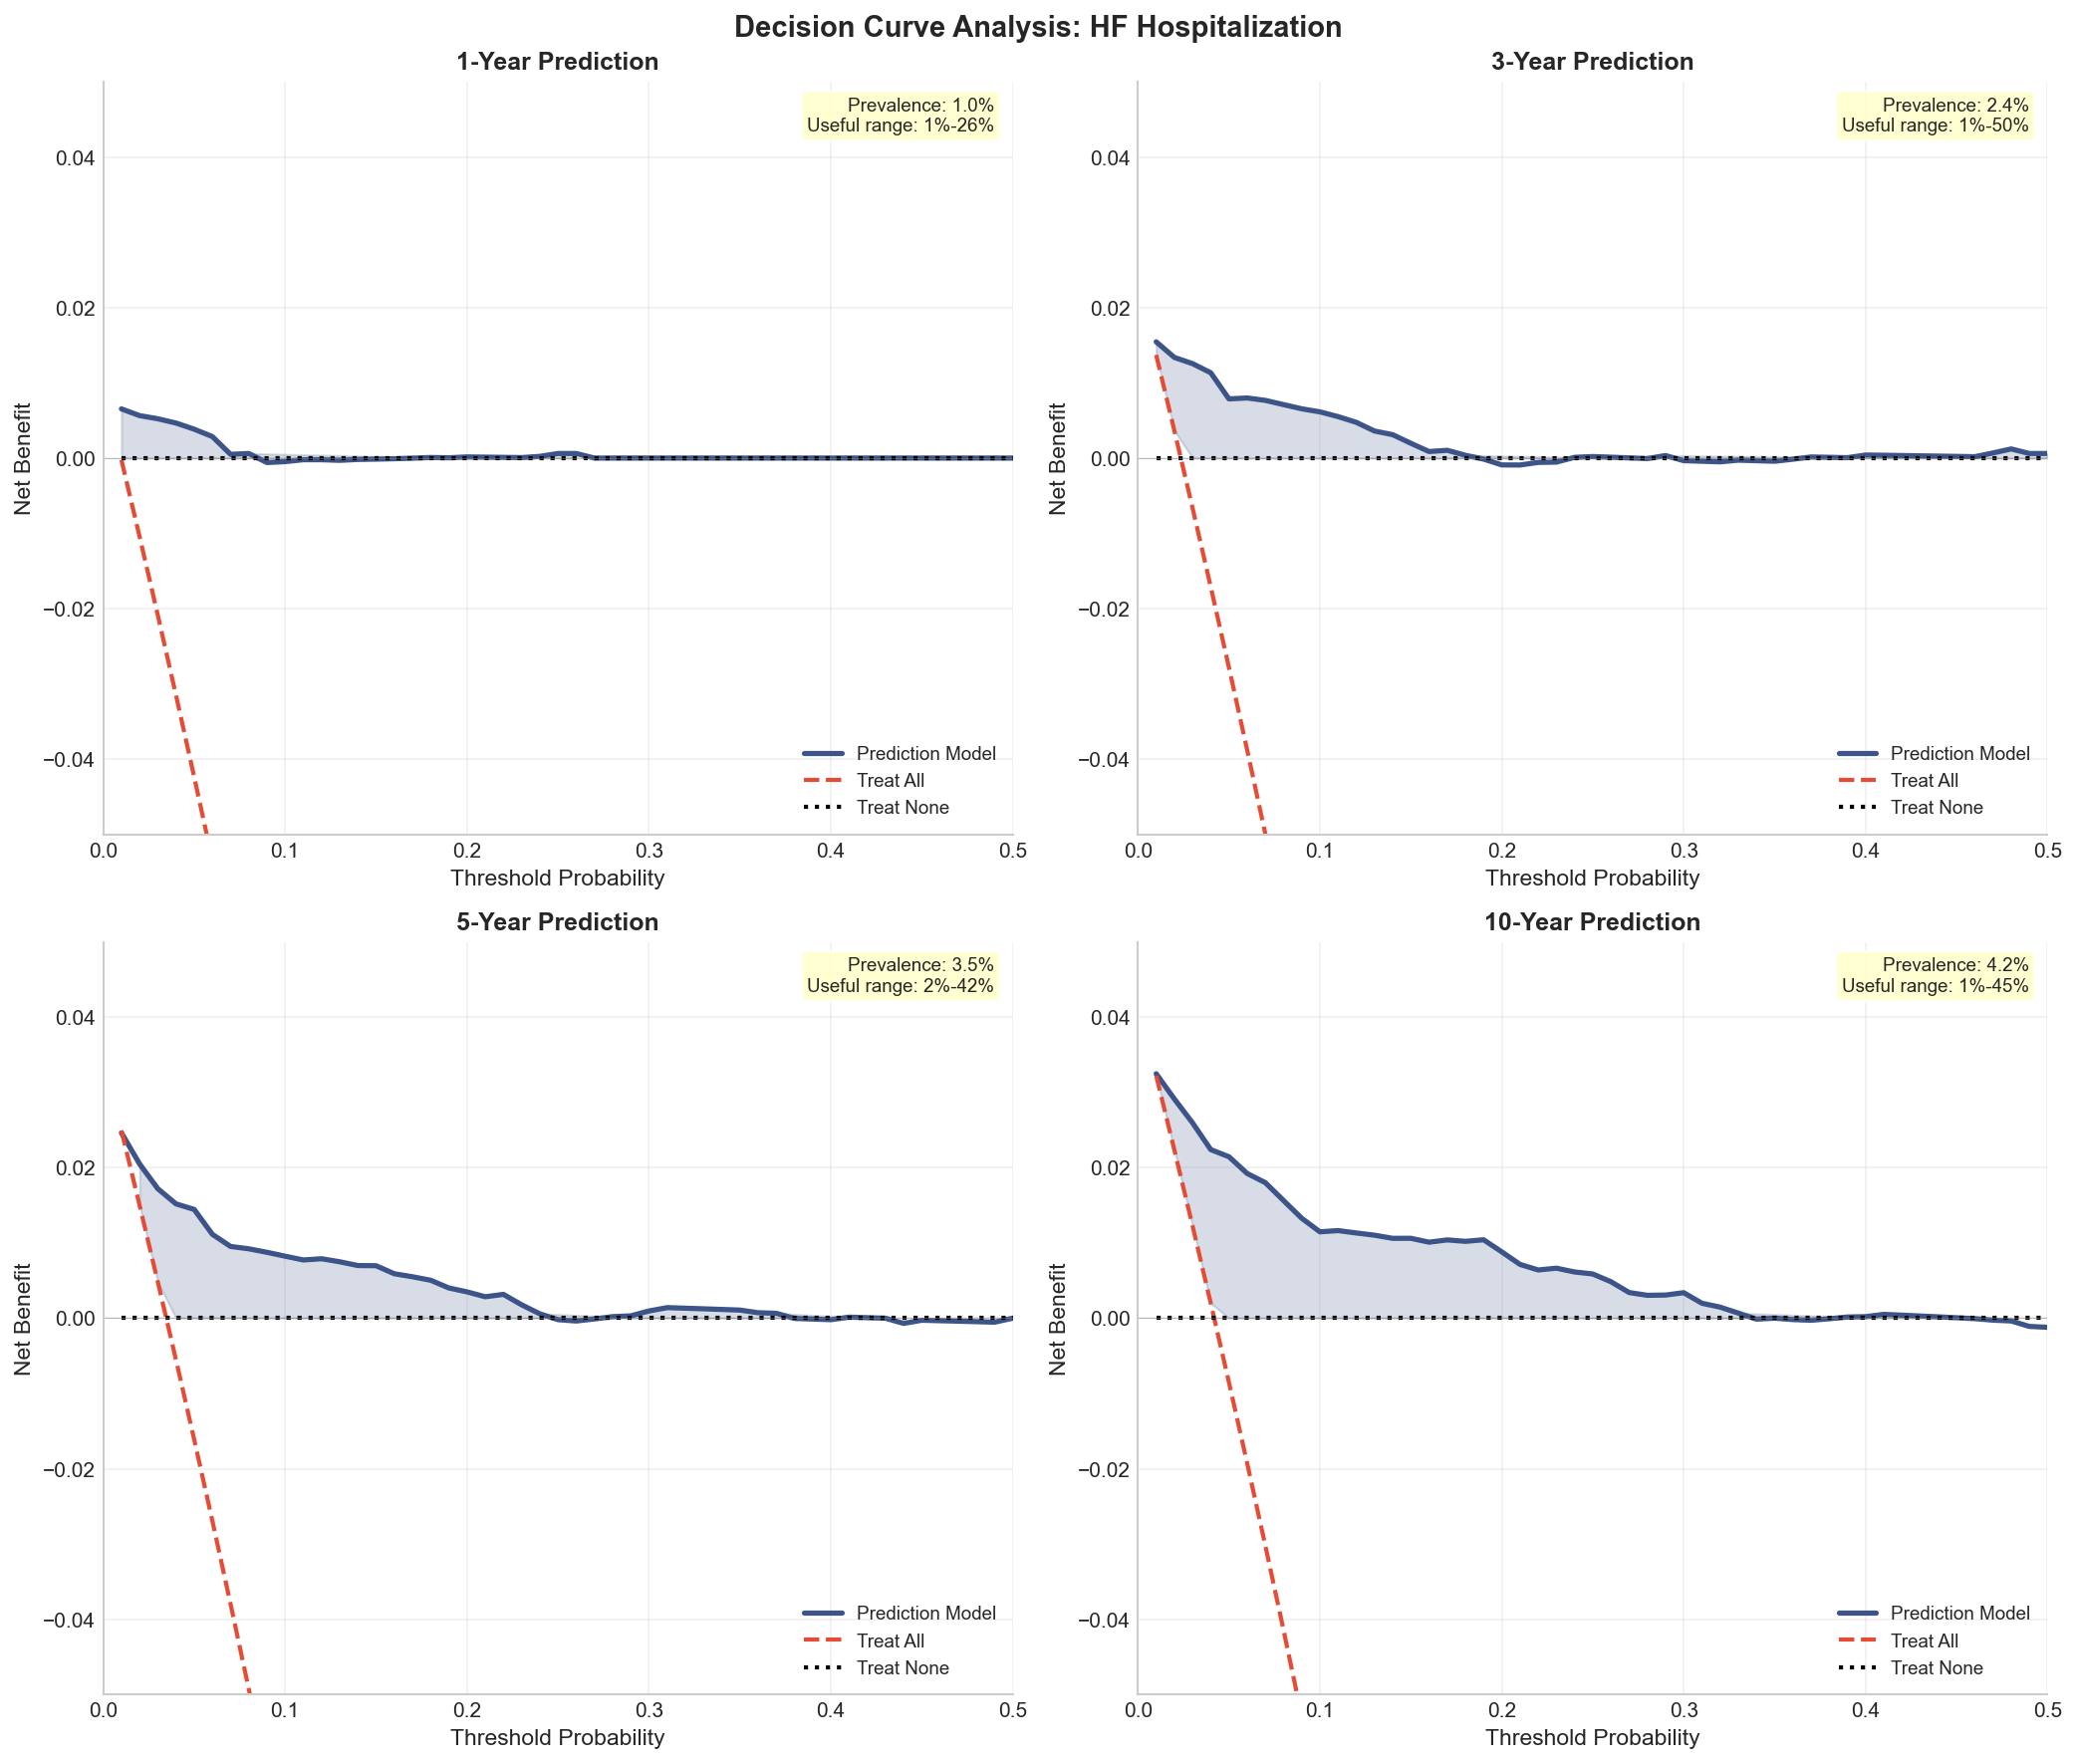


  📁 Saved: dca_grid_hf.png
  📁 Saved: dca_summary_hf.xlsx

════════════════════════════════════════════════════════════
Decision Curve Analysis: All-Cause Mortality
════════════════════════════════════════════════════════════

  Test set size: 1647
  Events: 28

  Time       Prevalence   Useful Range         Max Net Benefit
  ────────────────────────────────────────────────────────────
  1-year        0.1%      None                 0.0000
  3-year        0.4%      1%-5%                0.0016
  5-year        0.8%      1%-12%               0.0034
  10-year        1.7%      1%-26%               0.0099
📁 Saved: dca_grid_death.png


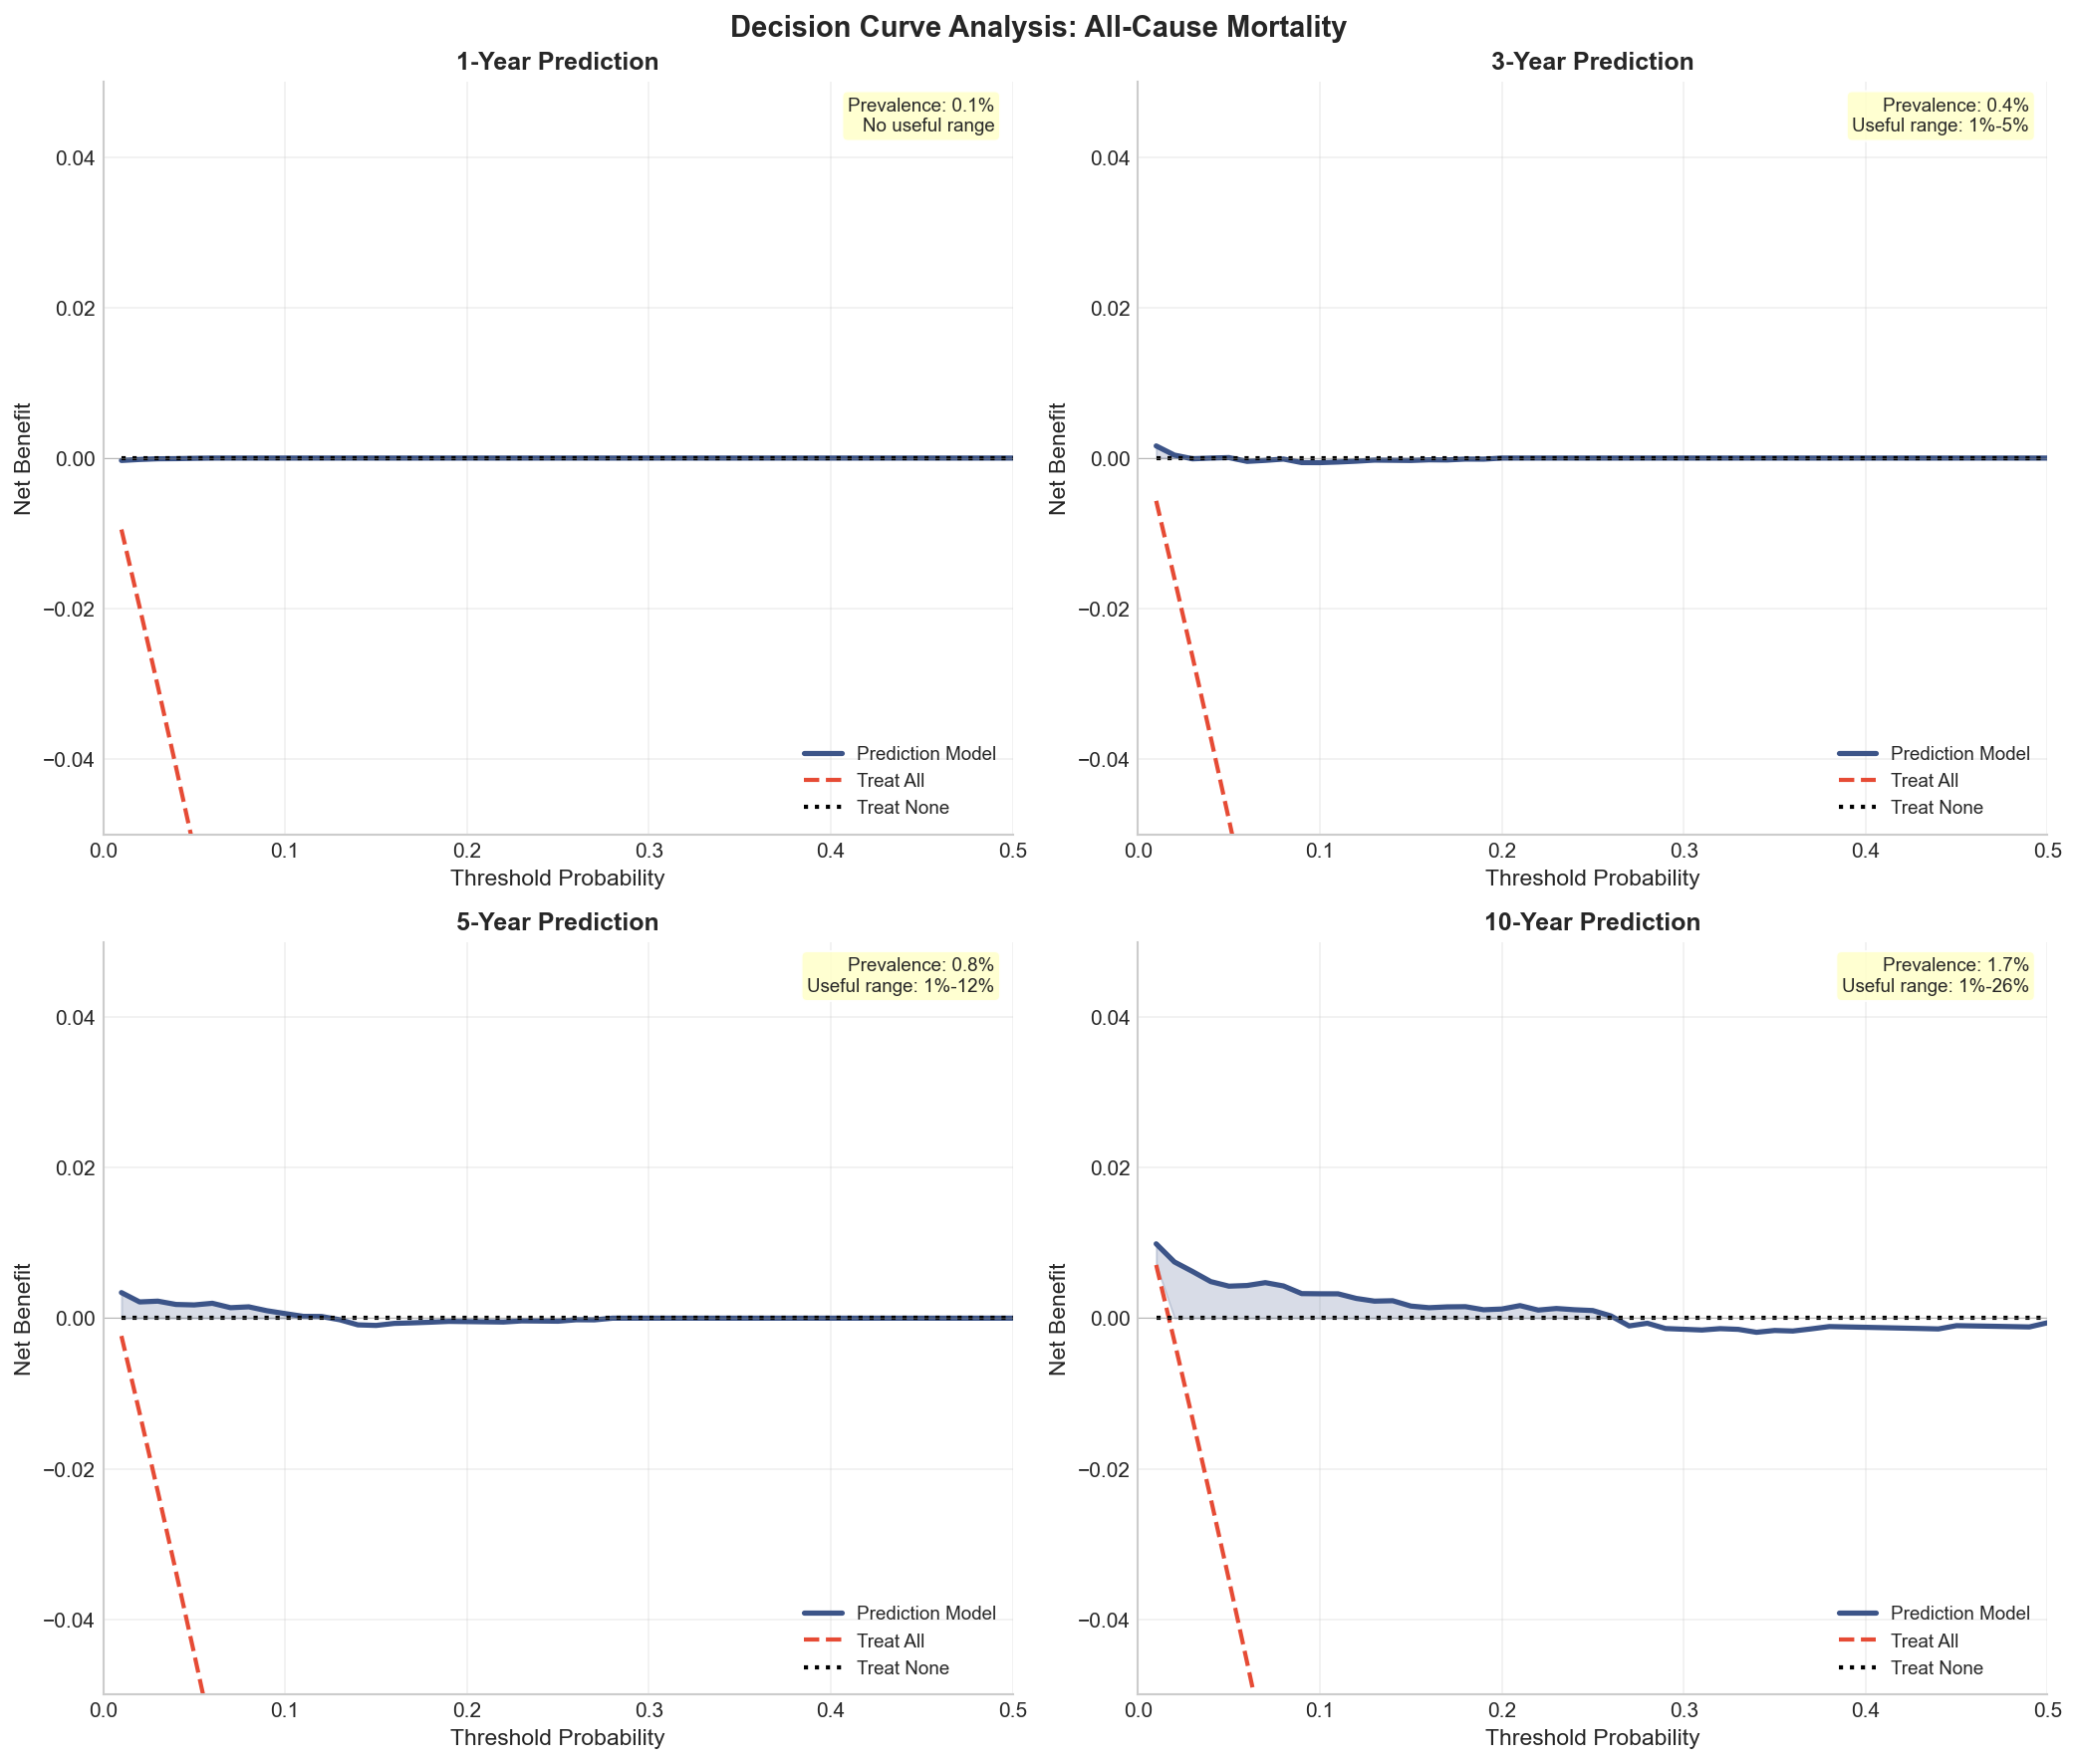


  📁 Saved: dca_grid_death.png
  📁 Saved: dca_summary_death.xlsx

DECISION CURVE ANALYSIS SUMMARY

            Outcome Time Point  Prevalence (%) Useful Range Min Useful Range Max  Max Net Benefit Threshold at Max NB
 HF Hospitalization     1-Year             1.0               1%              26%           0.0065                  1%
 HF Hospitalization     3-Year             2.4               1%              50%           0.0154                  1%
 HF Hospitalization     5-Year             3.5               2%              42%           0.0205                  2%
 HF Hospitalization    10-Year             4.2               1%              45%           0.0325                  1%
All-Cause Mortality     1-Year             0.1              N/A              N/A              NaN                 N/A
All-Cause Mortality     3-Year             0.4               1%               5%           0.0016                  1%
All-Cause Mortality     5-Year             0.8               1%            

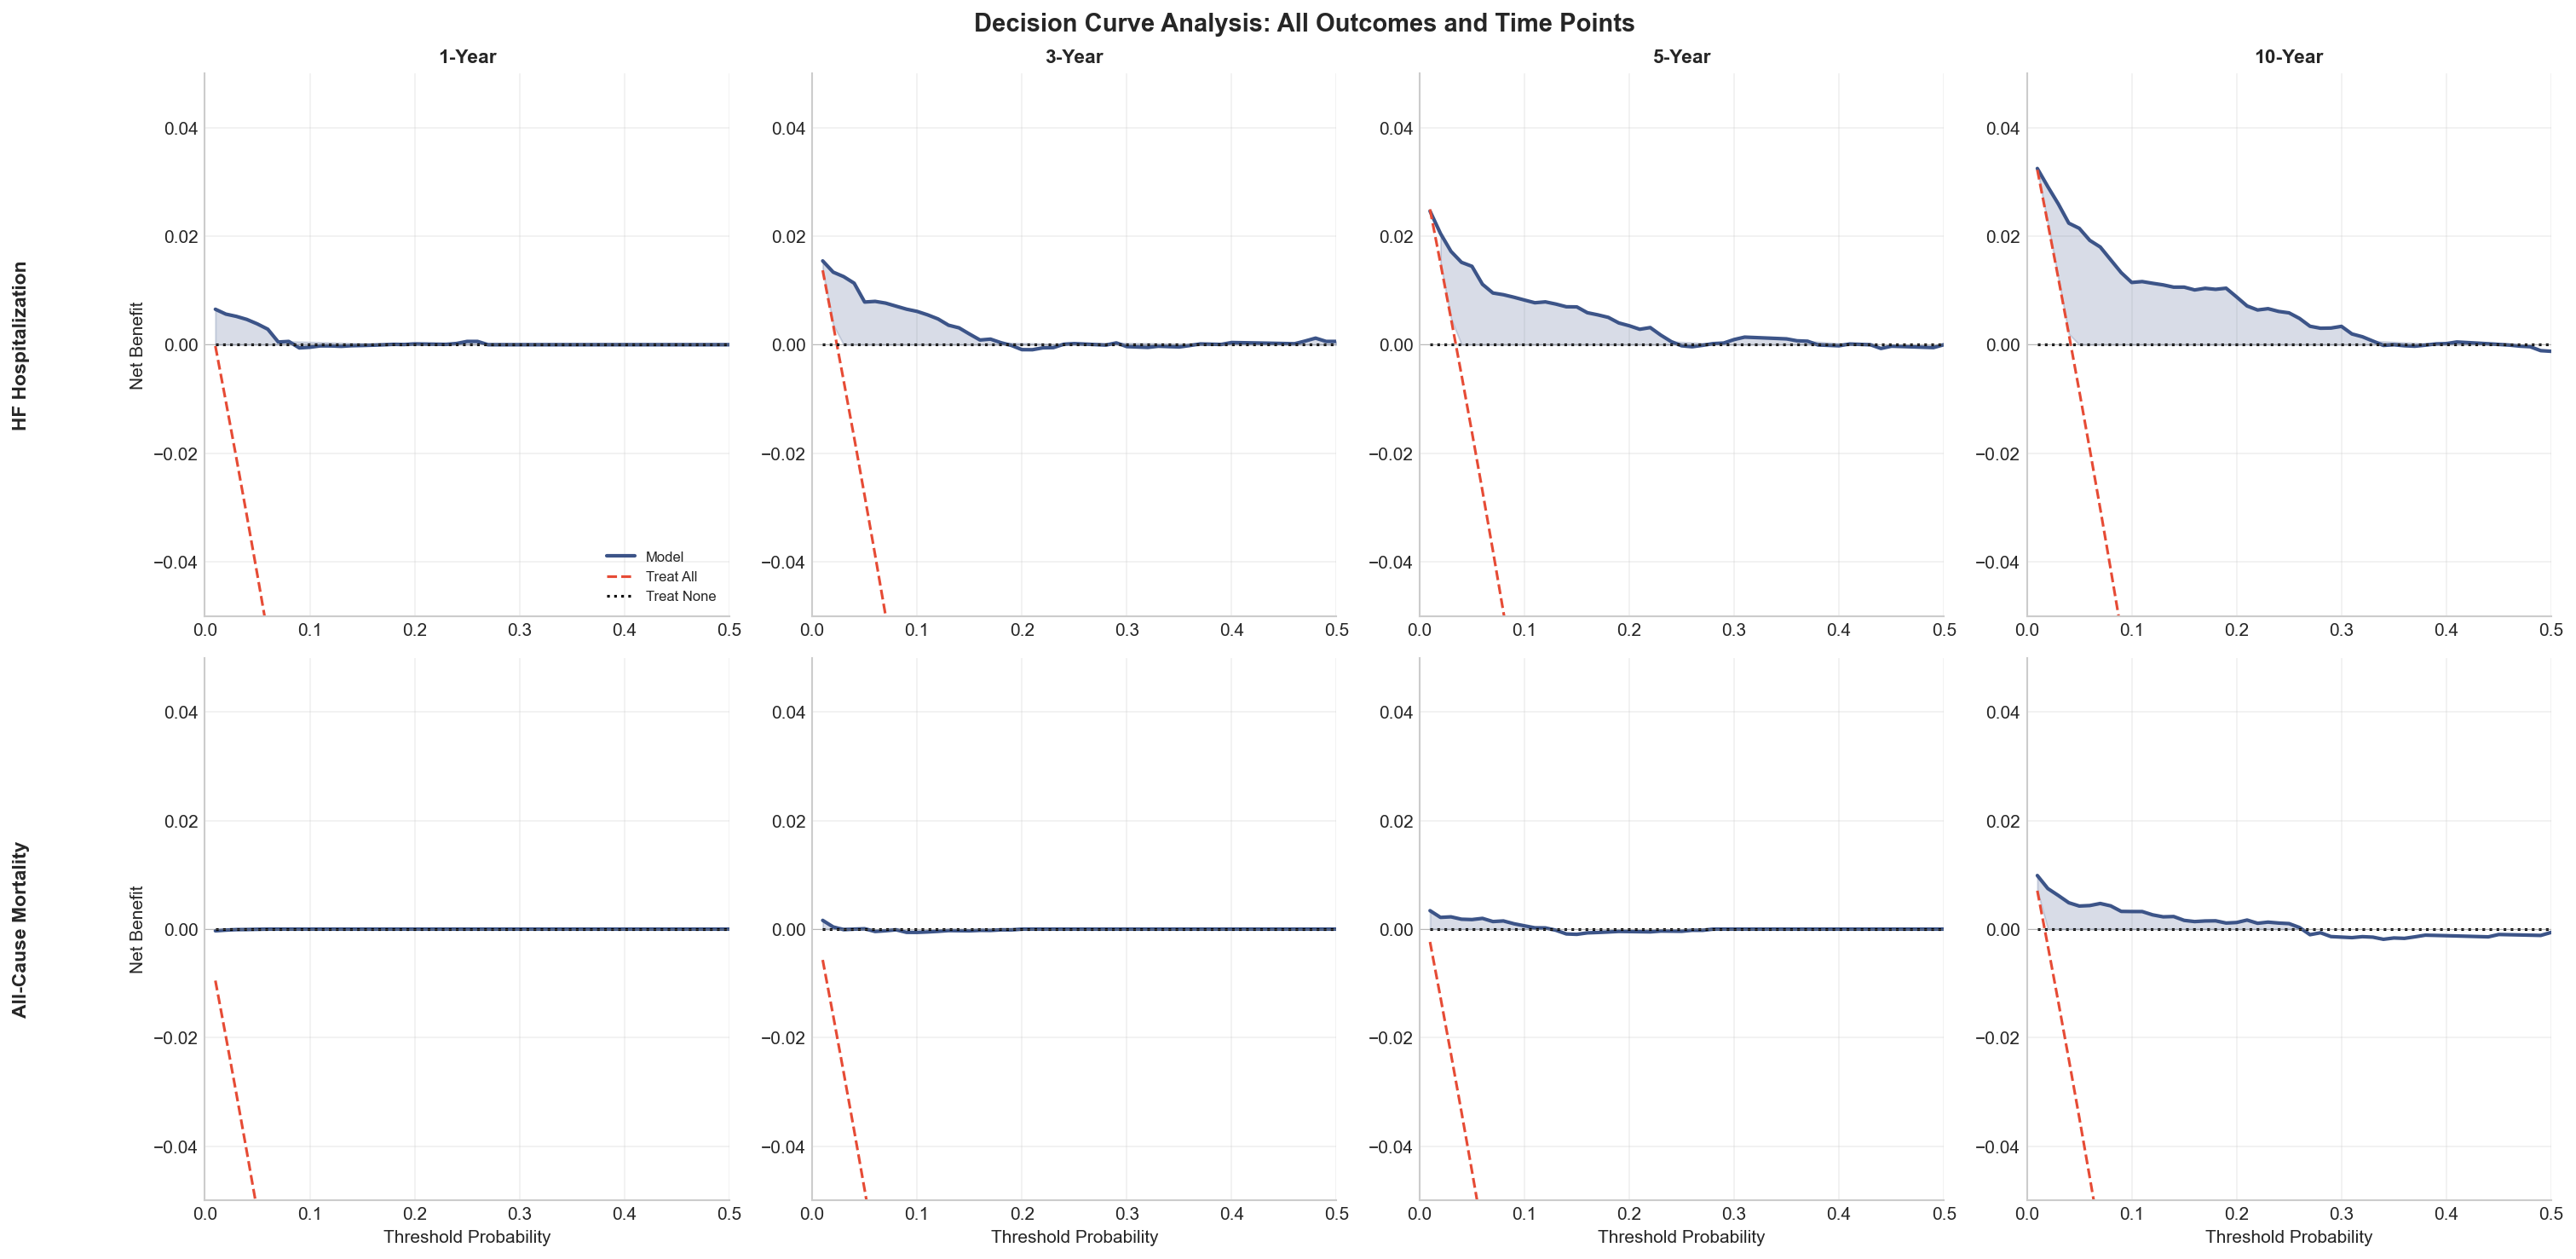

📁 Saved: dca_combined_all.png

────────────────────────────────────────────────────────────
INTERPRETATION GUIDE
────────────────────────────────────────────────────────────

Decision Curve Analysis (DCA):

Purpose:
  • Evaluates clinical utility of prediction model
  • Shows net benefit across different decision thresholds
  • Compares model to default strategies (Treat All / Treat None)

Key Concepts:
  • Threshold Probability: The risk level at which treatment is recommended
  • Net Benefit: (True Positives/n) - (False Positives/n) × (threshold/(1-threshold))
  • Useful Range: Thresholds where model outperforms both default strategies

Interpretation:
  • Model curve ABOVE "Treat All" and "Treat None" → Model is clinically useful
  • Shaded area → Range where model provides benefit
  • Wider useful range → More robust clinical utility

Clinical Application:
  • Low threshold (e.g., 5%): Aggressive treatment strategy
  • High threshold (e.g., 30%): Conservative treatment strategy
  •

In [243]:
# =============================================
# PART 16: DECISION CURVE ANALYSIS
# =============================================
print("\n" + "=" * 90)
print("PART 16: DECISION CURVE ANALYSIS")
print("=" * 90)


def decision_curve_analysis(data, cph, time_col, event_col,
                            time_point_years=5, thresholds=None):
    """
    Perform decision curve analysis for survival model.

    Net benefit = (TP/n) - (FP/n) * (pt / (1-pt))
    where pt is threshold probability
    """
    if thresholds is None:
        thresholds = np.arange(0.01, 0.51, 0.01)

    data = data.copy()

    # ═══════════════════════════════════════════
    # FIX: Remove non-predictor columns
    # ═══════════════════════════════════════════
    cols_to_drop = ['risk_score', 'risk_group', '_time', 'pred_event_prob',
                    'pred_prob', 'observed', 'followup_group', 'cr_time', 'cr_event']
    for col in cols_to_drop:
        if col in data.columns:
            data = data.drop(columns=[col])

    t_days = time_point_years * 365.25

    # Get predicted probabilities
    surv_func = cph.predict_survival_function(data)
    closest_time = surv_func.index[np.abs(surv_func.index - t_days).argmin()]
    pred_surv = surv_func.loc[closest_time].values
    pred_event = 1 - pred_surv
    data['pred_prob'] = pred_event

    # Determine observed outcome at time point
    # (Binary: event before time_point vs no event)
    data['observed'] = ((data[time_col] <= t_days) & (data[event_col] == 1)).astype(int)

    # Prevalence (for Treat All strategy)
    kmf = KaplanMeierFitter()
    kmf.fit(data[time_col] / 365.25, data[event_col])
    if time_point_years <= kmf.survival_function_.index.max():
        prevalence = 1 - kmf.survival_function_at_times(time_point_years).values[0]
    else:
        prevalence = data['observed'].mean()

    results = []
    n = len(data)

    for thresh in thresholds:
        # Model predictions
        pred_positive = data['pred_prob'] >= thresh
        tp = ((pred_positive) & (data['observed'] == 1)).sum()
        fp = ((pred_positive) & (data['observed'] == 0)).sum()

        # Net benefit for model
        nb_model = (tp / n) - (fp / n) * (thresh / (1 - thresh))

        # Net benefit for Treat All
        nb_all = prevalence - (1 - prevalence) * (thresh / (1 - thresh))

        # Net benefit for Treat None = 0
        nb_none = 0

        results.append({
            'threshold': thresh,
            'nb_model': nb_model,
            'nb_all': nb_all,
            'nb_none': nb_none,
            'prevalence': prevalence
        })

    return pd.DataFrame(results)


def plot_dca_grid(dca_results_dict, outcome_label, time_points=[1, 3, 5, 10],
                  out_path=None):
    """
    Plot Decision Curve Analysis in 2x2 grid for multiple time points.

    Parameters:
    -----------
    dca_results_dict : dict
        Dictionary with keys like '1yr', '3yr', etc., containing DCA results
    outcome_label : str
        Label for the outcome
    time_points : list
        Time points to plot [1, 3, 5, 10]
    out_path : str
        Output file path
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()

    for idx, time_point in enumerate(time_points):
        ax = axes[idx]
        key = f'{time_point}yr'

        if key not in dca_results_dict:
            ax.text(0.5, 0.5, f'No data for {time_point}-year',
                    ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f'{time_point}-Year', fontsize=12, fontweight='bold')
            continue

        dca = dca_results_dict[key]

        # Plot curves
        ax.plot(dca['threshold'], dca['nb_model'],
                color=COLORS['blue'], linewidth=2.5, label='Prediction Model')
        ax.plot(dca['threshold'], dca['nb_all'],
                color=COLORS['red'], linewidth=2, linestyle='--', label='Treat All')
        ax.plot(dca['threshold'], dca['nb_none'],
                color='black', linewidth=2, linestyle=':', label='Treat None')

        # Shade area where model has positive net benefit over both strategies
        model_benefit = dca[dca['nb_model'] > np.maximum(dca['nb_all'], dca['nb_none'])].copy()
        if len(model_benefit) > 0:
            ax.fill_between(
                model_benefit['threshold'],
                model_benefit['nb_model'],
                np.maximum(model_benefit['nb_all'], model_benefit['nb_none']),
                alpha=0.2, color=COLORS['blue']
            )

        # Find useful threshold range
        useful_range = dca[(dca['nb_model'] > 0) &
                           (dca['nb_model'] > dca['nb_all']) &
                           (dca['nb_model'] > dca['nb_none'])]

        if len(useful_range) > 0:
            range_min = useful_range['threshold'].min()
            range_max = useful_range['threshold'].max()
            range_text = f'Useful range: {range_min:.0%}-{range_max:.0%}'
        else:
            range_text = 'No useful range'

        # Prevalence text
        prevalence = dca['prevalence'].iloc[0]

        # Info box
        info_text = f'Prevalence: {prevalence:.1%}\n{range_text}'
        ax.text(0.98, 0.98, info_text, transform=ax.transAxes, fontsize=9,
                ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='#FFFFCC', alpha=0.9))

        # Formatting
        ax.set_xlabel('Threshold Probability', fontsize=11)
        ax.set_ylabel('Net Benefit', fontsize=11)
        ax.set_title(f'{time_point}-Year Prediction', fontsize=12, fontweight='bold')
        ax.set_xlim([0, 0.5])

        # Dynamic y-axis limits
        ax.set_ylim(-0.05, 0.05)

        ax.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, alpha=0.3)

    plt.suptitle(f'Decision Curve Analysis: {outcome_label}',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()

    if out_path:
        plt.savefig(out_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"📁 Saved: {out_path}")

    plt.show()


def calculate_dca_summary(dca_results_dict, time_points=[1, 3, 5, 10]):
    """
    Calculate summary statistics for DCA at each time point.
    """
    summary = []

    for time_point in time_points:
        key = f'{time_point}yr'
        if key not in dca_results_dict:
            continue

        dca = dca_results_dict[key]
        prevalence = dca['prevalence'].iloc[0]

        # Find threshold range where model is useful
        useful = dca[(dca['nb_model'] > 0) &
                     (dca['nb_model'] > dca['nb_all']) &
                     (dca['nb_model'] > dca['nb_none'])]

        if len(useful) > 0:
            range_min = useful['threshold'].min()
            range_max = useful['threshold'].max()
            max_nb = useful['nb_model'].max()
            max_nb_threshold = useful.loc[useful['nb_model'].idxmax(), 'threshold']
        else:
            range_min = np.nan
            range_max = np.nan
            max_nb = np.nan
            max_nb_threshold = np.nan

        summary.append({
            'Time Point': f'{time_point}-Year',
            'Prevalence (%)': round(prevalence * 100, 1),
            'Useful Range Min': f'{range_min:.0%}' if pd.notna(range_min) else 'N/A',
            'Useful Range Max': f'{range_max:.0%}' if pd.notna(range_max) else 'N/A',
            'Max Net Benefit': round(max_nb, 4) if pd.notna(max_nb) else np.nan,
            'Threshold at Max NB': f'{max_nb_threshold:.0%}' if pd.notna(max_nb_threshold) else 'N/A'
        })

    return pd.DataFrame(summary)


# ─────────────────────────────────────────────
# RUN DCA FOR BOTH OUTCOMES
# ─────────────────────────────────────────────
dca_results_all = {}
time_points = [1, 3, 5, 10]

for outcome_key, outcome_info in OUTCOMES.items():
    print(f"\n{'═' * 60}")
    print(f"Decision Curve Analysis: {outcome_info['label']}")
    print(f"{'═' * 60}")

    results = model_results[outcome_key]
    cph = results['model']

    time_col = outcome_info['time_col']
    event_col = outcome_info['event_col']

    # ═══════════════════════════════════════════
    # FIX: Get clean test data
    # ═══════════════════════════════════════════
    cox_test_clean = test_scaled[predictors + [time_col, event_col]].dropna().copy()
    cox_test_clean[event_col] = cox_test_clean[event_col].astype(int)

    print(f"\n  Test set size: {len(cox_test_clean)}")
    print(f"  Events: {int(cox_test_clean[event_col].sum())}")

    # Store results for this outcome
    outcome_dca_results = {}

    # Calculate DCA for each time point
    print(f"\n  {'Time':<10} {'Prevalence':<12} {'Useful Range':<20} {'Max Net Benefit'}")
    print("  " + "─" * 60)

    for time_point in time_points:
        dca = decision_curve_analysis(
            cox_test_clean, cph, time_col, event_col,
            time_point_years=time_point
        )

        outcome_dca_results[f'{time_point}yr'] = dca

        # Calculate summary for this time point
        prevalence = dca['prevalence'].iloc[0]
        useful = dca[(dca['nb_model'] > 0) &
                     (dca['nb_model'] > dca['nb_all']) &
                     (dca['nb_model'] > dca['nb_none'])]

        if len(useful) > 0:
            range_str = f"{useful['threshold'].min():.0%}-{useful['threshold'].max():.0%}"
            max_nb = useful['nb_model'].max()
        else:
            range_str = "None"
            max_nb = 0

        print(f"  {time_point}-year     {prevalence * 100:>6.1f}%      {range_str:<20} {max_nb:.4f}")

        # Save individual DCA data
        dca.to_excel(f'dca_{outcome_key}_{time_point}yr.xlsx', index=False)

    # Store for global access
    dca_results_all[outcome_key] = outcome_dca_results

    # ─────────────────────────────────────────────
    # PLOT 2x2 GRID
    # ─────────────────────────────────────────────
    plot_dca_grid(
        outcome_dca_results,
        outcome_info['label'],
        time_points=time_points,
        out_path=f'dca_grid_{outcome_key}.png'
    )

    # ─────────────────────────────────────────────
    # SAVE SUMMARY TABLE
    # ─────────────────────────────────────────────
    dca_summary = calculate_dca_summary(outcome_dca_results, time_points)
    dca_summary.to_excel(f'dca_summary_{outcome_key}.xlsx', index=False)
    print(f"\n  📁 Saved: dca_grid_{outcome_key}.png")
    print(f"  📁 Saved: dca_summary_{outcome_key}.xlsx")

# ─────────────────────────────────────────────
# COMBINED SUMMARY TABLE
# ─────────────────────────────────────────────
print("\n" + "=" * 90)
print("DECISION CURVE ANALYSIS SUMMARY")
print("=" * 90)

all_summaries = []
for outcome_key, outcome_info in OUTCOMES.items():
    outcome_dca = dca_results_all[outcome_key]
    summary = calculate_dca_summary(outcome_dca, time_points)
    summary.insert(0, 'Outcome', outcome_info['label'])
    all_summaries.append(summary)

combined_summary = pd.concat(all_summaries, ignore_index=True)
print("\n" + combined_summary.to_string(index=False))

combined_summary.to_excel('dca_summary_all.xlsx', index=False)
print(f"\n📁 Saved: dca_summary_all.xlsx")

# ─────────────────────────────────────────────
# COMBINED FIGURE: BOTH OUTCOMES SIDE BY SIDE
# ─────────────────────────────────────────────
print("\n" + "─" * 60)
print("Creating Combined DCA Figure (Both Outcomes)")
print("─" * 60)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for row_idx, (outcome_key, outcome_info) in enumerate(OUTCOMES.items()):
    outcome_dca = dca_results_all[outcome_key]

    for col_idx, time_point in enumerate(time_points):
        ax = axes[row_idx, col_idx]
        key = f'{time_point}yr'

        if key not in outcome_dca:
            continue

        dca = outcome_dca[key]

        # Plot curves
        ax.plot(dca['threshold'], dca['nb_model'],
                color=COLORS['blue'], linewidth=2, label='Model')
        ax.plot(dca['threshold'], dca['nb_all'],
                color=COLORS['red'], linewidth=1.5, linestyle='--', label='Treat All')
        ax.plot(dca['threshold'], dca['nb_none'],
                color='black', linewidth=1.5, linestyle=':', label='Treat None')

        # Shade useful area
        model_benefit = dca[dca['nb_model'] > np.maximum(dca['nb_all'], dca['nb_none'])].copy()
        if len(model_benefit) > 0:
            ax.fill_between(
                model_benefit['threshold'],
                model_benefit['nb_model'],
                np.maximum(model_benefit['nb_all'], model_benefit['nb_none']),
                alpha=0.2, color=COLORS['blue']
            )

        # Formatting
        ax.set_xlim([0, 0.5])
        ax.set_ylim([-0.05, 0.05])
        ax.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
        ax.grid(True, alpha=0.3)

        # Labels
        if row_idx == 1:
            ax.set_xlabel('Threshold Probability', fontsize=10)
        if col_idx == 0:
            ax.set_ylabel('Net Benefit', fontsize=10)

        # Title for top row only
        if row_idx == 0:
            ax.set_title(f'{time_point}-Year', fontsize=11, fontweight='bold')

        # Outcome label on left
        if col_idx == 0:
            ax.text(-0.35, 0.5, outcome_info['label'], transform=ax.transAxes,
                    fontsize=11, fontweight='bold', rotation=90,
                    ha='center', va='center')

        # Legend only for first plot
        if row_idx == 0 and col_idx == 0:
            ax.legend(loc='lower right', fontsize=8)

plt.suptitle('Decision Curve Analysis: All Outcomes and Time Points',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('dca_combined_all.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"📁 Saved: dca_combined_all.png")

# ─────────────────────────────────────────────
# INTERPRETATION GUIDE
# ─────────────────────────────────────────────
print("\n" + "─" * 60)
print("INTERPRETATION GUIDE")
print("─" * 60)
print("""
Decision Curve Analysis (DCA):

Purpose:
  • Evaluates clinical utility of prediction model
  • Shows net benefit across different decision thresholds
  • Compares model to default strategies (Treat All / Treat None)

Key Concepts:
  • Threshold Probability: The risk level at which treatment is recommended
  • Net Benefit: (True Positives/n) - (False Positives/n) × (threshold/(1-threshold))
  • Useful Range: Thresholds where model outperforms both default strategies

Interpretation:
  • Model curve ABOVE "Treat All" and "Treat None" → Model is clinically useful
  • Shaded area → Range where model provides benefit
  • Wider useful range → More robust clinical utility

Clinical Application:
  • Low threshold (e.g., 5%): Aggressive treatment strategy
  • High threshold (e.g., 30%): Conservative treatment strategy
  • Model should be useful across clinically relevant threshold range

For Manuscript:
  "Decision curve analysis demonstrated that the prediction model
  provided positive net benefit compared to default strategies
  (treat all, treat none) across threshold probabilities of X% to Y%
  for [outcome] at [time point] years."
""")

print("\n" + "=" * 90)
print("✅ DECISION CURVE ANALYSIS COMPLETE")
print("=" * 90)


PART 17: SUBGROUP ANALYSES

════════════════════════════════════════════════════════════
Subgroup Analysis: HF Hospitalization
════════════════════════════════════════════════════════════

  Model features: 37
  Test set size: 1647
  Total events: 69
  Overall test C-index: 0.843 ✅

  Checking subgroup validity:
    Sex: ✅ Valid
    Diabetes: ✅ Valid
    Hypertension: ✅ Valid
    CAD: ✅ Valid
    Atrial Fibrillation: ⚠️ Group 1 has <20 patients
    Smoking: ✅ Valid
    Dyslipidemia: ✅ Valid

  ──────────────────────────────────────────────────
  RESULTS:
  ──────────────────────────────────────────────────

  Sex:
Subgroup   N  Events  Event_Rate (%)  C_index Note
  Female 675      33             4.9    0.808     
    Male 972      36             3.7    0.876     

  Diabetes:
Subgroup    N  Events  Event_Rate (%)  C_index Note
   No DM 1451      44             3.0    0.832     
      DM  196      25            12.8    0.755     

  Hypertension:
Subgroup    N  Events  Event_Rate (%) 

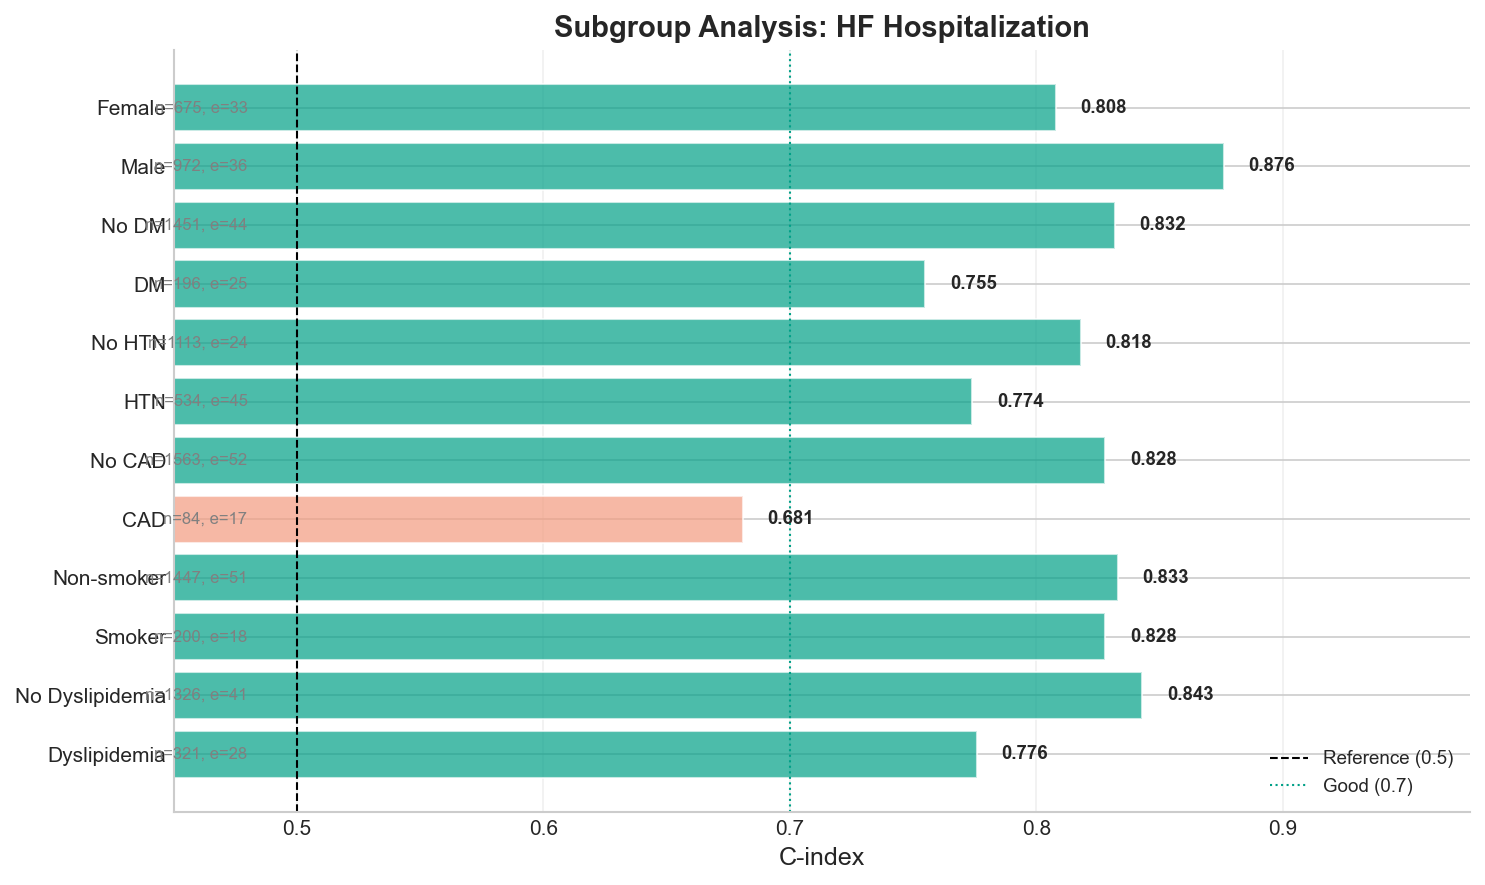


  📁 Saved: subgroup_analysis_hf.xlsx

════════════════════════════════════════════════════════════
Subgroup Analysis: All-Cause Mortality
════════════════════════════════════════════════════════════

  Model features: 37
  Test set size: 1647
  Total events: 28
  Overall test C-index: 0.820 ✅

  Checking subgroup validity:
    Sex: ✅ Valid
    Diabetes: ✅ Valid
    Hypertension: ✅ Valid
    CAD: ✅ Valid
    Atrial Fibrillation: ⚠️ Group 1 has <20 patients
    Smoking: ✅ Valid
    Dyslipidemia: ✅ Valid

  ──────────────────────────────────────────────────
  RESULTS:
  ──────────────────────────────────────────────────

  Sex:
Subgroup   N  Events  Event_Rate (%)  C_index Note
  Female 675      14             2.1    0.793     
    Male 972      14             1.4    0.844     

  Diabetes:
Subgroup    N  Events  Event_Rate (%)  C_index Note
   No DM 1451      14             1.0    0.742     
      DM  196      14             7.1    0.756     

  Hypertension:
Subgroup    N  Events  Even

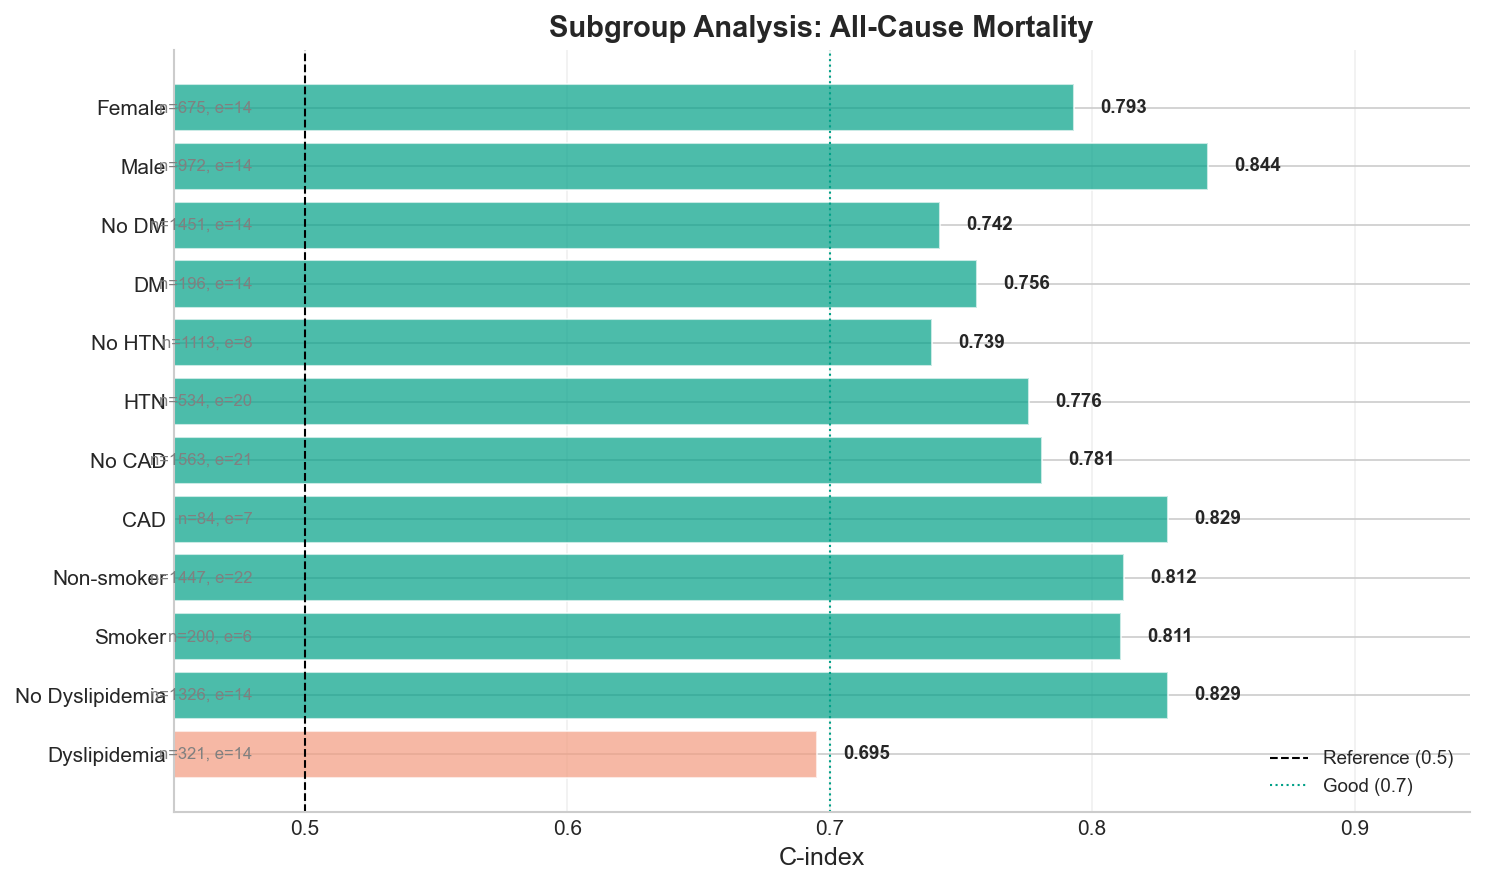


  📁 Saved: subgroup_analysis_death.xlsx

✅ SUBGROUP ANALYSIS COMPLETE


In [248]:
# =============================================
# PART 17: SUBGROUP ANALYSES
# =============================================
print("\n" + "=" * 90)
print("PART 17: SUBGROUP ANALYSES")
print("=" * 90)


def subgroup_analysis(data, cph, time_col, event_col, subgroup_var,
                      subgroup_labels=None, var_label=None, min_events=5):
    """
    Perform subgroup analysis: calculate C-index within subgroups.
    """
    data = data.copy()

    if var_label is None:
        var_label = var_labels.get(subgroup_var, subgroup_var)

    # Handle Series vs DataFrame
    if isinstance(data[subgroup_var], pd.DataFrame):
        subgroup_series = data[subgroup_var].iloc[:, 0]
    else:
        subgroup_series = data[subgroup_var]

    unique_vals = sorted(subgroup_series.dropna().unique())

    if subgroup_labels is None:
        subgroup_labels = {v: f'{var_label}={v}' for v in unique_vals}

    # ═══════════════════════════════════════════
    # Get the columns the model was trained on
    # ═══════════════════════════════════════════
    model_features = cph.params_.index.tolist()

    results = []

    for val in unique_vals:
        subset = data[subgroup_series == val].copy()

        n_total = len(subset)
        n_events = int(subset[event_col].sum())
        event_rate = n_events / n_total * 100 if n_total > 0 else 0

        if n_events < min_events:
            c_index = np.nan
            c_index_note = f"<{min_events} events"
        elif n_total - n_events < 2:
            c_index = np.nan
            c_index_note = "Too few censored"
        else:
            try:
                # ═══════════════════════════════════════════
                # FIX: Only pass PREDICTOR columns to model
                # ═══════════════════════════════════════════
                subset_for_pred = subset[model_features].copy()

                # Check for missing values in predictors
                if subset_for_pred.isna().any().any():
                    subset_for_pred = subset_for_pred.dropna()
                    subset = subset.loc[subset_for_pred.index]
                    n_total = len(subset)
                    n_events = int(subset[event_col].sum())

                if n_events < min_events or n_total < 10:
                    c_index = np.nan
                    c_index_note = "After dropna: insufficient"
                else:
                    pred = cph.predict_partial_hazard(subset_for_pred)
                    c_index = concordance_index(
                        subset[time_col],
                        -pred,
                        subset[event_col]
                    )
                    c_index_note = ""

            except Exception as e:
                c_index = np.nan
                c_index_note = f"Error"
                print(f"      Debug - {subgroup_labels.get(val, val)}: {str(e)[:60]}")

        results.append({
            'Subgroup': subgroup_labels.get(val, f'{var_label}={val}'),
            'N': n_total,
            'Events': n_events,
            'Event_Rate (%)': round(event_rate, 1),
            'C_index': round(c_index, 3) if pd.notna(c_index) else np.nan,
            'Note': c_index_note
        })

    return pd.DataFrame(results)


def check_subgroup_validity(data, var, min_per_group=20, min_events_per_group=5, event_col=None):
    """Check if a variable is valid for subgroup analysis."""
    if var not in data.columns:
        return False, "Variable not found"

    if isinstance(data[var], pd.DataFrame):
        col_data = data[var].iloc[:, 0]
    else:
        col_data = data[var]

    unique_vals = col_data.dropna().unique()
    if len(unique_vals) < 2:
        return False, "Less than 2 groups"

    for val in unique_vals:
        subset = data[col_data == val]
        if len(subset) < min_per_group:
            return False, f"Group {val} has <{min_per_group} patients"
        if event_col and subset[event_col].sum() < min_events_per_group:
            return False, f"Group {val} has <{min_events_per_group} events"

    return True, "OK"


def plot_subgroup_forest(subgroup_results_all, outcome_label, out_path=None):
    """Plot forest plot of subgroup C-indices."""
    all_results = []
    for var, results in subgroup_results_all.items():
        results = results.copy()
        results['Variable'] = var
        all_results.append(results)

    if len(all_results) == 0:
        print("  No subgroup results to plot")
        return

    combined = pd.concat(all_results, ignore_index=True)
    valid_combined = combined[combined['C_index'].notna()].copy()

    if len(valid_combined) == 0:
        print("  No valid C-indices to plot")
        return

    fig, ax = plt.subplots(figsize=(10, max(6, len(valid_combined) * 0.5)))

    y_pos = range(len(valid_combined))
    colors = [COLORS['teal'] if c >= 0.7 else COLORS['orange'] if c >= 0.6 else COLORS['red']
              for c in valid_combined['C_index']]

    ax.barh(y_pos, valid_combined['C_index'], color=colors, alpha=0.7, edgecolor='white')
    ax.axvline(0.5, color='black', linestyle='--', linewidth=1, label='Reference (0.5)')
    ax.axvline(0.7, color=COLORS['teal'], linestyle=':', linewidth=1, label='Good (0.7)')

    for i, (idx, row) in enumerate(valid_combined.iterrows()):
        ax.text(row['C_index'] + 0.01, i, f'{row["C_index"]:.3f}',
                va='center', fontsize=9, fontweight='bold')
        ax.text(0.48, i, f'n={row["N"]}, e={row["Events"]}',
                va='center', ha='right', fontsize=8, color='gray')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(valid_combined['Subgroup'])
    ax.set_xlabel('C-index', fontsize=12)
    ax.set_title(f'Subgroup Analysis: {outcome_label}', fontsize=14, fontweight='bold')
    ax.set_xlim([0.45, min(1.0, valid_combined['C_index'].max() + 0.1)])
    ax.invert_yaxis()
    ax.grid(True, axis='x', alpha=0.3)
    ax.legend(loc='lower right', fontsize=9)

    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"📁 Saved: {out_path}")
    plt.show()


# ─────────────────────────────────────────────
# DEFINE SUBGROUPS
# ─────────────────────────────────────────────
subgroups_config = {
    'sex': {'labels': {0: 'Female', 1: 'Male'}, 'var_label': 'Sex'},
    'dm': {'labels': {0: 'No DM', 1: 'DM'}, 'var_label': 'Diabetes'},
    'htn': {'labels': {0: 'No HTN', 1: 'HTN'}, 'var_label': 'Hypertension'},
    'cad': {'labels': {0: 'No CAD', 1: 'CAD'}, 'var_label': 'CAD'},
    'baseline_af': {'labels': {0: 'No AF', 1: 'AF'}, 'var_label': 'Atrial Fibrillation'},
    'smoker': {'labels': {0: 'Non-smoker', 1: 'Smoker'}, 'var_label': 'Smoking'},
    'hyperlipidemia': {'labels': {0: 'No Dyslipidemia', 1: 'Dyslipidemia'}, 'var_label': 'Dyslipidemia'}
}

# ─────────────────────────────────────────────
# RUN SUBGROUP ANALYSES
# ─────────────────────────────────────────────
subgroup_results_all_outcomes = {}

for outcome_key, outcome_info in OUTCOMES.items():
    print(f"\n{'═' * 60}")
    print(f"Subgroup Analysis: {outcome_info['label']}")
    print(f"{'═' * 60}")

    results = model_results[outcome_key]
    cph = results['model']

    time_col = outcome_info['time_col']
    event_col = outcome_info['event_col']

    # ═══════════════════════════════════════════
    # Get model features
    # ═══════════════════════════════════════════
    model_features = cph.params_.index.tolist()
    print(f"\n  Model features: {len(model_features)}")

    # ═══════════════════════════════════════════
    # Prepare test data with all needed columns
    # ═══════════════════════════════════════════
    subgroup_vars = list(subgroups_config.keys())
    available_subgroup_vars = [v for v in subgroup_vars if v in test_scaled.columns]

    # Columns needed: model features + time + event + subgroup vars
    all_needed_cols = list(set(model_features + [time_col, event_col] + available_subgroup_vars))
    all_needed_cols = [c for c in all_needed_cols if c in test_scaled.columns]

    cox_test_clean = test_scaled[all_needed_cols].copy()
    cox_test_clean = cox_test_clean.loc[:, ~cox_test_clean.columns.duplicated()]

    # Drop rows with missing predictors
    cox_test_clean = cox_test_clean.dropna(subset=model_features + [time_col, event_col])
    cox_test_clean[event_col] = cox_test_clean[event_col].astype(int)

    print(f"  Test set size: {len(cox_test_clean)}")
    print(f"  Total events: {int(cox_test_clean[event_col].sum())}")

    # ═══════════════════════════════════════════
    # Verify model works on this data
    # ═══════════════════════════════════════════
    try:
        test_pred = cph.predict_partial_hazard(cox_test_clean[model_features])
        test_c = concordance_index(cox_test_clean[time_col], -test_pred, cox_test_clean[event_col])
        print(f"  Overall test C-index: {test_c:.3f} ✅")
    except Exception as e:
        print(f"  ⚠️ Model prediction failed: {e}")
        continue

    # Check subgroup validity
    print(f"\n  Checking subgroup validity:")
    valid_subgroups = {}

    for var, config in subgroups_config.items():
        if var not in cox_test_clean.columns:
            print(f"    {config['var_label']}: ❌ Not in data")
            continue

        is_valid, reason = check_subgroup_validity(
            cox_test_clean, var,
            min_per_group=20,
            min_events_per_group=5,
            event_col=event_col
        )

        if is_valid:
            valid_subgroups[var] = config
            print(f"    {config['var_label']}: ✅ Valid")
        else:
            print(f"    {config['var_label']}: ⚠️ {reason}")

    # Run analysis
    subgroup_results = {}

    if len(valid_subgroups) > 0:
        print(f"\n  {'─' * 50}")
        print(f"  RESULTS:")
        print(f"  {'─' * 50}")

        for var, config in valid_subgroups.items():
            sg_results = subgroup_analysis(
                cox_test_clean, cph, time_col, event_col, var,
                subgroup_labels=config.get('labels'),
                var_label=config.get('var_label'),
                min_events=5
            )

            print(f"\n  {config.get('var_label', var)}:")
            print(sg_results.to_string(index=False))

            subgroup_results[var] = sg_results

    subgroup_results_all_outcomes[outcome_key] = subgroup_results

    # Plot and save
    if len(subgroup_results) > 0:
        plot_subgroup_forest(subgroup_results, outcome_info['label'],
                             out_path=f'subgroup_forest_{outcome_key}.png')

        all_sg = pd.concat([df.assign(Subgroup_Variable=var)
                            for var, df in subgroup_results.items()], ignore_index=True)
        all_sg.to_excel(f'subgroup_analysis_{outcome_key}.xlsx', index=False)
        print(f"\n  📁 Saved: subgroup_analysis_{outcome_key}.xlsx")

print("\n" + "=" * 90)
print("✅ SUBGROUP ANALYSIS COMPLETE")
print("=" * 90)

In [249]:
# =============================================
# PART 18: FINAL MODEL SUMMARY & REPORTING
# =============================================
print("\n" + "=" * 90)
print("PART 18: FINAL MODEL SUMMARY & REPORTING")
print("=" * 90)


def create_model_summary_table(model_results, bootstrap_results, calibration_results):
    """Create comprehensive model performance summary table."""

    summary_rows = []

    for outcome_key in model_results.keys():
        mr = model_results[outcome_key]
        br = bootstrap_results.get(outcome_key, {})

        # Get calibration at 5 years
        calib_key = f'{outcome_key}_5yr'
        cr = calibration_results.get(calib_key, {}).get('stats', {})

        summary_rows.append({
            'Outcome': OUTCOMES[outcome_key]['label'],
            'N_Train': len(mr['cox_train']),
            'N_Test': len(mr['cox_test']),
            'N_Events_Train': int(mr['cox_train'][OUTCOMES[outcome_key]['event_col']].sum()),
            'N_Events_Test': int(mr['cox_test'][OUTCOMES[outcome_key]['event_col']].sum()),
            'EPV': round(mr['epv_ratio'], 1),
            'N_Predictors_Selected': len(mr['non_zero_coefs']),
            'CV_C_index': round(mr['cv_c_index'], 3),
            'Train_C_index': round(mr['train_c_index'], 3),
            'Test_C_index': round(mr['test_c_index'], 3),
            'Optimism_Corrected_C': round(br.get('corrected_c_index', np.nan), 3),
            'Calibration_Slope': round(cr.get('slope', np.nan), 3),
            'HL_P_Value': round(cr.get('hl_p_value', np.nan), 3)
        })

    return pd.DataFrame(summary_rows)


# Create summary table
print("\nComprehensive Model Performance Summary:")
summary_table = create_model_summary_table(model_results, bootstrap_results, calibration_results)
print(summary_table.to_string(index=False))

summary_table.to_excel('model_performance_summary.xlsx', index=False)
print(f"\n📁 Saved: model_performance_summary.xlsx")

# ─────────────────────────────────────────────
# Create manuscript-ready tables
# ─────────────────────────────────────────────
print("\n" + "─" * 60)
print("Manuscript-Ready Performance Table")
print("─" * 60)

manuscript_table = []
for outcome_key in model_results.keys():
    mr = model_results[outcome_key]
    br = bootstrap_results.get(outcome_key, {})
    aucs = mr.get('test_aucs', {})

    manuscript_table.append({
        'Outcome': OUTCOMES[outcome_key]['label'],
        'C-statistic (95% CI)': f"{br.get('corrected_c_index', mr['test_c_index']):.3f} ({br.get('ci_lower', 0):.3f}-{br.get('ci_upper', 1):.3f})",
        '3-Year AUC': f"{aucs.get(3, np.nan):.3f}" if pd.notna(aucs.get(3)) else 'N/A',
        '5-Year AUC': f"{aucs.get(5, np.nan):.3f}" if pd.notna(aucs.get(5)) else 'N/A',
        'Calibration Slope': f"{calibration_results.get(f'{outcome_key}_5yr', {}).get('stats', {}).get('slope', np.nan):.2f}"
    })

manuscript_df = pd.DataFrame(manuscript_table)
print(manuscript_df.to_string(index=False))

manuscript_df.to_excel('manuscript_table_performance.xlsx', index=False)
print(f"📁 Saved: manuscript_table_performance.xlsx")

# ─────────────────────────────────────────────
# FINAL OUTPUT SUMMARY
# ─────────────────────────────────────────────
print("\n" + "=" * 90)
print("ANALYSIS COMPLETE - FILES GENERATED")
print("=" * 90)

print("""
📁 CORE MODEL FILES:
├── train_df.xlsx, test_df.xlsx
├── cox_summary_hf.xlsx, cox_summary_death.xlsx
├── hazard_ratios_hf.xlsx, hazard_ratios_death.xlsx
└── stability_hf.xlsx, stability_death.xlsx

📁 VALIDATION FILES:
├── ph_test_hf.xlsx, ph_test_death.xlsx (Proportional Hazards)
├── bootstrap_hf.png, bootstrap_death.png (Internal Validation)
├── calibration_data_*.xlsx (Calibration Data)
└── calibration_*.png (Calibration Plots)

📁 CLINICAL UTILITY:
├── dca_*.xlsx, dca_*.png (Decision Curve Analysis)
├── subgroup_analysis_*.xlsx (Subgroup Results)
└── subgroup_forest_*.png (Forest Plots)

📁 SUMMARY TABLES:
├── model_performance_summary.xlsx
├── manuscript_table_performance.xlsx
└── missing_data_analysis.xlsx

📁 FIGURES:
├── km_train_*.png (Kaplan-Meier Curves)
├── forest_plot_*.png (Hazard Ratio Forest Plots)
├── roc_*.png (Time-Dependent ROC)
├── stability_analysis_*.png (Stability Selection)
└── schoenfeld_residuals_*.png (PH Assumption)
""")



PART 18: FINAL MODEL SUMMARY & REPORTING

Comprehensive Model Performance Summary:
            Outcome  N_Train  N_Test  N_Events_Train  N_Events_Test  EPV  N_Predictors_Selected  CV_C_index  Train_C_index  Test_C_index  Optimism_Corrected_C  Calibration_Slope  HL_P_Value
 HF Hospitalization     3842    1647             160             69  4.3                     37       0.829          0.845         0.843                 0.830                NaN         NaN
All-Cause Mortality     3842    1647              68             28  1.8                     37       0.893          0.921         0.820                 0.901                NaN         NaN

📁 Saved: model_performance_summary.xlsx

────────────────────────────────────────────────────────────
Manuscript-Ready Performance Table
────────────────────────────────────────────────────────────
            Outcome C-statistic (95% CI) 3-Year AUC 5-Year AUC Calibration Slope
 HF Hospitalization  0.830 (0.802-0.857)      0.852      0.837    